In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-06-17 16:31:07 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-17 16:31:07 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-06-17 16:31:07 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
from src.utils.training_utils import get_device_map
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

device_map = get_device_map(model_key, 30, n_gpus=8)
device_map

2025-06-17 16:31:08 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-17 16:31:08 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-06-17 16:31:09 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-06-17 16:31:09 wandb.docker.auth DEBUG    No config file found


{'model.embed_tokens': 7,
 'model.norm': 7,
 'model.rotary_emb': 7,
 'lm_head': 7,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 2,
 'model.layers.3': 3,
 'model.layers.4': 4,
 'model.layers.5': 5,
 'model.layers.6': 6,
 'model.layers.7': 7,
 'model.layers.8': 0,
 'model.layers.9': 1,
 'model.layers.10': 2,
 'model.layers.11': 3,
 'model.layers.12': 4,
 'model.layers.13': 5,
 'model.layers.14': 6,
 'model.layers.15': 7,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 2,
 'model.layers.19': 3,
 'model.layers.20': 4,
 'model.layers.21': 5,
 'model.layers.22': 6,
 'model.layers.23': 7,
 'model.layers.24': 0,
 'model.layers.25': 1,
 'model.layers.26': 2,
 'model.layers.27': 3,
 'model.layers.28': 4,
 'model.layers.29': 5,
 'model.layers.30': 0,
 'model.layers.31': 1,
 'model.layers.32': 2,
 'model.layers.33': 3,
 'model.layers.34': 4,
 'model.layers.35': 5,
 'model.layers.36': 6,
 'model.layers.37': 7,
 'model.layers.38': 0,
 'model.layers.39': 1,
 'model

## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-06-17 16:31:09 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-06-17 16:31:09 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-06-17 16:31:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-06-17 16:31:09 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]

2025-06-17 16:31:35 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-06-17 16:31:36 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-06-17 16:31:46 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

In [8]:
# Trainable_CLS.defuse_from_model(
#     mt._model,
#     loaded_deltas,
#     # param_delta_dict=loaded_deltas,
# )

## Load cachecd patching samples

In [9]:
################################################################
target_attribute = "profession"
# target_attribute = "nationality"
################################################################


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

In [10]:
sample = samples[0]
print(sample)

Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"


## Utils

In [9]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

# clean_pred = predict_next_token(
#     mt=mt,
#     inputs=sample.prompt_template.format(sample.clean_entity),
# )
# clean_pred

In [10]:
from src.functional import interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal


@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs,
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt=mt,
            inputs=inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches=patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False,  # don't need to
            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f'"{answer[0]}"')

    logits = get_hs(
        mt=mt,
        input=inputs,
        locations=[(mt.lm_head_name, -1)],
        patches=patches,
        return_dict=False,
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt, logits=logits, interested_tokens=ans_tokens, **next_tok_kwargs
    )

    score = get_score(logits=logits, token_id=ans_tokens, metric=metric)

    return score, pred, track

In [11]:
import baukit
from src.functional import PatchSpec
from src.utils.typing import Model
from src.models import unwrap_model
from nnsight import LanguageModel


def patch_with_baukit(
    model: ModelandTokenizer | Model,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    model_kwargs: dict = {},
):
    if isinstance(model, ModelandTokenizer):
        model = unwrap_model(model)
    if isinstance(model, LanguageModel):
        model = model._model

    layers_to_indices = {}
    patch_dict = {}
    for patch in patches:
        layer, idx = patch.location
        if layer not in layers_to_indices:
            layers_to_indices[layer] = []
        layers_to_indices[layer].append(idx)
        patch_dict[patch.location] = patch.patch

    unique_modules = list(layers_to_indices.keys())

    def perform_patch(repr, layer_name):
        # print(layer_name)
        if layer_name not in unique_modules:
            return repr

        current_state = repr if "mlp" in layer_name else repr[0]
        for index in layers_to_indices[layer_name]:
            current_state[:, index, :] = patch_dict[(layer_name, index)]

        return repr

    with baukit.TraceDict(
        module=model, layers=unique_modules, edit_output=perform_patch
    ):
        output = model(**inputs, **model_kwargs)

    return output

In [12]:
import types
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
from src.utils.typing import PredictedToken
from src.probing.prompt import ProbingPrompt

def get_edges_to_be_ablated(
    prompt: ProbingPrompt,
    focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all",
    Q_IDX: int = -1,  # almost always the last token position
    whitelist_key_indices: list[int] = [0, -1],
):
    for idx, ti in enumerate(whitelist_key_indices):
        if ti < 0:
            whitelist_key_indices[idx] = prompt.tokenized["input_ids"][0].shape[-1] + ti

    if focus_strategy == "entities":
        whitelist_key_indices += list(range(*prompt.entity_ranges[0])) + list(
            range(*prompt.entity_ranges[1])
        )
    elif focus_strategy == "entities_last":
        whitelist_key_indices += [
            prompt.entity_ranges[0][1] - 1,
            prompt.entity_ranges[1][1] - 1,
        ]
    elif focus_strategy == "ablate_all":
        pass
    else:
        raise ValueError(f"{focus_strategy=}")

    whitelist_key_indices = list(set(whitelist_key_indices))
    if Q_IDX < 0:
        Q_IDX = prompt.tokenized["input_ids"][0].shape[-1] + Q_IDX

    block_edges: list[AttentionEdge] = []
    for k_idx in range(0, prompt.tokenized["input_ids"][0].shape[-1]):
        if k_idx in whitelist_key_indices:
            continue
        block_edges.append(
            AttentionEdge(
                q_idx=Q_IDX,
                k_idx=k_idx,
            )
        )

    return block_edges

## Ablating the heads to check their importance -- doesn't give clean results

In [123]:
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token


@torch.inference_mode()
def attn_blocking_sweep_cumulative(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    direction: Literal["asc", "desc"] = "asc",
    step: int = 1,
    verbose: bool = False,
):
    inputs = TokenizerOutput(data=prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    effects = {}

    if direction == "asc":
        progress = tqdm(range(0, mt.n_layer, step))
    elif direction == "desc":
        progress = tqdm(range(mt.n_layer - 1, -1, -step))

    progress.set_description(f"{direction=}")

    for layer_idx in progress:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        # attn_block = get_module_nnsight(mt, attn_block_name)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name, cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block,
        )

        ablated_pred, track_ans = predict_next_token(
            mt=mt, inputs=inputs, token_of_interest=[clean_answer.token_id]
        )
        # output = mt._model(**inputs)
        # logits = output.logits[:, -1, :].squeeze()
        # ablated_pred, track_ans = interpret_logits(tokenizer=mt, logits=logits, interested_tokens=[answer.token_id])

        if verbose:
            logger.debug(f"{layer_idx}: {track_ans=}")

        effects[layer_idx] = {
            "track_ans": track_ans,
            "ablated_pred": ablated_pred,
        }

    mt.reset_forward()
    return effects


block_edges = get_edges_to_be_ablated(
    prompt=prompt, focus_strategy="entities", Q_IDX=-1, whitelist_key_indices=[0, -1]
)

blocking_effects = attn_blocking_sweep_cumulative(
    mt=mt,
    prompt=prompt,
    block_edges=block_edges,
    clean_answer=clean_pred[0][0],
    direction="desc",
)

direction='desc': 100%|██████████| 48/48 [01:23<00:00,  1.73s/it]


In [12]:
# focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# block_edges = get_edges_to_be_ablated(
#     prompt=prompt,
#     focus_strategy=focus_strategy,
#     Q_IDX=-1,
#     whitelist_key_indices=[0, -1]
# )

# effects_asc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="asc",
# )
# effects_desc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="desc",
# )

In [13]:
# clean_pred[0][0]

In [14]:
# import matplotlib.pyplot as plt

# metric = "prob"

# denom = getattr(clean_pred[0][0], metric)

# layers = list(range(mt.n_layer))
# values_asc = []
# for layer_idx in layers:
#     track_ans = list(effects_asc[layer_idx]["track_ans"][0].values())[0][1]
#     values_asc.append(getattr(track_ans, metric) / denom)

# values_desc = []
# for layer_idx in layers:
#     track_ans = list(effects_desc[layer_idx]["track_ans"][0].values())[0][1]
#     values_desc.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.title(f"ATTN Ablation Effects ({metric}) | {focus_strategy}")

# plt.plot(values_asc, marker="o", label="asc")
# plt.plot(values_desc, marker="o", label="desc")

# plt.xticks(layers)
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.legend()

# plt.show()

In [15]:
@torch.inference_mode()
def ablate_attn_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    layer_window: list[int],
    k=5,
    debug_full_answer=False,
):
    inputs = TokenizerOutput(data=prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    for layer_idx in layer_window:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name, cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block,
        )

    if debug_full_answer:
        answer = get_lm_generated_answer(
            mt=mt,
            prompt=prompt,
            is_a_reasoning_model="deepseek" in model_key.lower(),
            use_kv_cache=False,
        )
        print(f"{answer=}")

    ablated_pred, track_ans = predict_next_token(
        mt=mt, inputs=inputs, token_of_interest=[clean_answer.token_id], k=k
    )

    mt.reset_forward()

    return ablated_pred, track_ans

In [14]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# layer_window = list(range(0, 5))
# layer_window = list(range(0, mt.n_layer))
# layer_window = list(range(10, 20))
layer_window = list(
    range(20, 45)
)  #! critical layers! "ablate_all" works. but "entities" does not work

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy=focus_strategy,
    Q_IDX=-1,
    whitelist_key_indices=[0, -1],
)

track_ans = ablate_attn_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=layer_window,
    debug_full_answer=True,
)

track_ans

answer='mammals.'


([[PredictedToken(token=' mammals', prob=0.0322265625, logit=14.0625, token_id=55569),
   PredictedToken(token=' very', prob=0.0302734375, logit=14.0, token_id=1602),
   PredictedToken(token=' in', prob=0.020751953125, logit=13.625, token_id=304),
   PredictedToken(token=' created', prob=0.018310546875, logit=13.5, token_id=3465),
   PredictedToken(token=' animals', prob=0.0172119140625, logit=13.4375, token_id=9898)]],
 [{71527: (144,
    PredictedToken(token=' apex', prob=0.0010986328125, logit=10.6875, token_id=71527))}])

In [15]:
from src.trace import get_window


def attn_blocking_sweep_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    window_size: int,
):
    effects = {}

    for layer_idx in tqdm(range(mt.n_layer), desc=f"{window_size=}"):
        layer_window = get_window("{}", layer_idx, window_size, mt.n_layer)
        layer_window = [int(l) for l in layer_window]
        ablated_pred, track_ans = ablate_attn_window(
            mt=mt,
            prompt=prompt,
            clean_answer=clean_answer,
            block_edges=block_edges,
            layer_window=layer_window,
        )
        effects[layer_idx] = dict(
            track_ans=track_ans,
            ablated_pred=ablated_pred,
        )
    return effects


window_ablation_effects = attn_blocking_sweep_window(
    mt=mt,
    prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    window_size=11,
)

window_size=11: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


In [17]:
# window_ablation_effects

In [18]:
# from matplotlib import pyplot as plt

# metric = "prob"
# denom = getattr(clean_pred[0][0], metric)

# values = []
# layers = list(range(mt.n_layer))
# for layer_idx in layers:
#     track_ans = list(window_ablation_effects[layer_idx]["track_ans"][0].values())[0][1]
#     values.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.plot(values, marker="o")
# plt.xticks(layers)

# plt.title(f"Ablate ATTN sweep (window size={5})")
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.ylim(bottom=0)
# plt.legend()

In [19]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-19 10:47:42 __main__ INFO     len(coincidences['examples'])=20


In [28]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "entities"

effects = []

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx + 1}/{len(coincidences['examples'])})  {entities=}")

    prompt = prepare_probing_input(
        mt=mt,
        entities=entities,
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
    )

    clean_answer = predict_next_token(
        mt=mt, inputs=TokenizerOutput(data=prompt.tokenized), k=1
    )[0][0]
    logger.info(f"{clean_answer=}")

    block_edges = get_edges_to_be_ablated(
        prompt=prompt,
        focus_strategy=focus_strategy,
        Q_IDX=-2,
        whitelist_key_indices=[0],
        # whitelist_key_indices=[0, -1]
    )

    cumulative_effects_asc = attn_blocking_sweep_cumulative(
        mt=mt,
        prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="asc",
    )

    cumulative_effects_desc = attn_blocking_sweep_cumulative(
        mt=mt,
        prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="desc",
    )

    attn_ablation_effects = attn_blocking_sweep_window(
        mt=mt,
        prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        window_size=5,
    )

    effects.append(
        dict(
            entities=entities,
            clean_answer=clean_answer,
            attn_ablation_effects=attn_ablation_effects,
            cumulative_effects=dict(
                asc=cumulative_effects_asc, desc=cumulative_effects_desc
            ),
        )
    )

    print("-" * 80)

2025-02-19 11:17:53 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


2025-02-19 11:17:53 __main__ INFO     clean_answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:19:09 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']


2025-02-19 11:19:09 __main__ INFO     clean_answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]

--------------------------------------------------------------------------------
2025-02-19 11:20:24 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']


2025-02-19 11:20:25 __main__ INFO     clean_answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:21:41 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']


2025-02-19 11:21:41 __main__ INFO     clean_answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:22:55 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']


2025-02-19 11:22:56 __main__ INFO     clean_answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]

--------------------------------------------------------------------------------
2025-02-19 11:24:10 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']


2025-02-19 11:24:10 __main__ INFO     clean_answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:25:26 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']


2025-02-19 11:25:26 __main__ INFO     clean_answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]

--------------------------------------------------------------------------------
2025-02-19 11:26:42 __main__ INFO     (8/20)  entities=['Memento', 'Inception']


2025-02-19 11:26:42 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------
2025-02-19 11:27:57 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']


2025-02-19 11:27:58 __main__ INFO     clean_answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]

--------------------------------------------------------------------------------
2025-02-19 11:29:14 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']


2025-02-19 11:29:14 __main__ INFO     clean_answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:30:31 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']


2025-02-19 11:30:31 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:31:48 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']


2025-02-19 11:31:48 __main__ INFO     clean_answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]

--------------------------------------------------------------------------------
2025-02-19 11:33:08 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']


2025-02-19 11:33:09 __main__ INFO     clean_answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

--------------------------------------------------------------------------------
2025-02-19 11:34:33 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']


2025-02-19 11:34:34 __main__ INFO     clean_answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]

--------------------------------------------------------------------------------
2025-02-19 11:35:52 __main__ INFO     (15/20)  entities=['Brazil', 'Turkey']


2025-02-19 11:35:52 __main__ INFO     clean_answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:37:08 __main__ INFO     (16/20)  entities=['jellyfish', 'lobster']


2025-02-19 11:37:08 __main__ INFO     clean_answer=PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:38:23 __main__ INFO     (17/20)  entities=['corn', 'wheat']


2025-02-19 11:38:23 __main__ INFO     clean_answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:39:39 __main__ INFO     (18/20)  entities=['crocodile', 'shark']


2025-02-19 11:39:39 __main__ INFO     clean_answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:40:55 __main__ INFO     (19/20)  entities=['crab', 'spider']


2025-02-19 11:40:56 __main__ INFO     clean_answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]

--------------------------------------------------------------------------------
2025-02-19 11:42:12 __main__ INFO     (20/20)  entities=['copper', 'gold']


2025-02-19 11:42:12 __main__ INFO     clean_answer=PredictedToken(token=' used', prob=0.4423828125, logit=18.171875, token_id=1511)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------


In [31]:
def get_metric_value(track_ans, metric):
    rank, pred = list(track_ans[0].values())[0]
    if metric in ["prob", "logit"]:
        return getattr(pred, metric)
    elif metric == "reciprocal_rank":
        return 1 / rank


from src.utils.metrics import AggregateMetric
from typing import Optional


def process_effects_per_layer(
    effects: list[dict],
    metric: Literal["logit", "prob", "reciprocal_rank"] = "prob",
    v_clean_ans: Optional[list[float]] = None,
):
    if v_clean_ans is not None:
        assert metric in ["logit", "prob"]
        assert len(v_clean_ans) == len(effects)

    layer_wise_results: dict[int, AggregateMetric] = {}
    layer_indices = list(range(mt.n_layer))
    for layer_idx in layer_indices:
        values = []
        for idx, e in enumerate(effects):
            track_ans = e[int(layer_idx)]["track_ans"]
            v = get_metric_value(track_ans, metric)
            if v_clean_ans is not None:
                v /= v_clean_ans[idx]
            values.append(v)
        layer_wise_results[layer_idx] = AggregateMetric.aggregate(values)
    return layer_wise_results

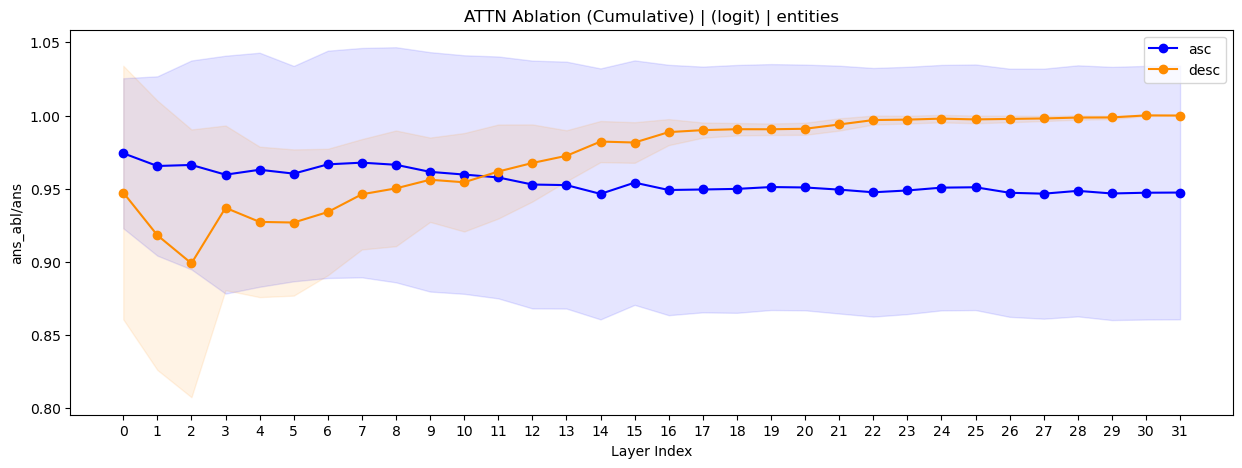

In [36]:
from matplotlib import pyplot as plt

metric: Literal["logit", "prob", "reciprocal_rank"] = "logit"

effects_asc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["asc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects]
    if metric in ["logit", "prob"]
    else None,
)


effects_desc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["desc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects]
    if metric in ["logit", "prob"]
    else None,
)


def plot_metric(
    results: dict[int, AggregateMetric], keys: list, label: str, color: str, canvas=plt
):
    values = [results[k].mean for k in keys]
    stds = [results[k].stdev for k in keys]
    canvas.plot(values, marker="o", label=label, color=color)
    canvas.fill_between(
        keys,
        [v - s for v, s in zip(values, stds)],
        [v + s for v, s in zip(values, stds)],
        alpha=0.1,
        color=color,
    )


plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (Cumulative) | ({metric}) | {focus_strategy}")

layers = list(range(mt.n_layer))
plot_metric(effects_asc, layers, "asc", color="blue")
plot_metric(effects_desc, layers, "desc", color="darkorange")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

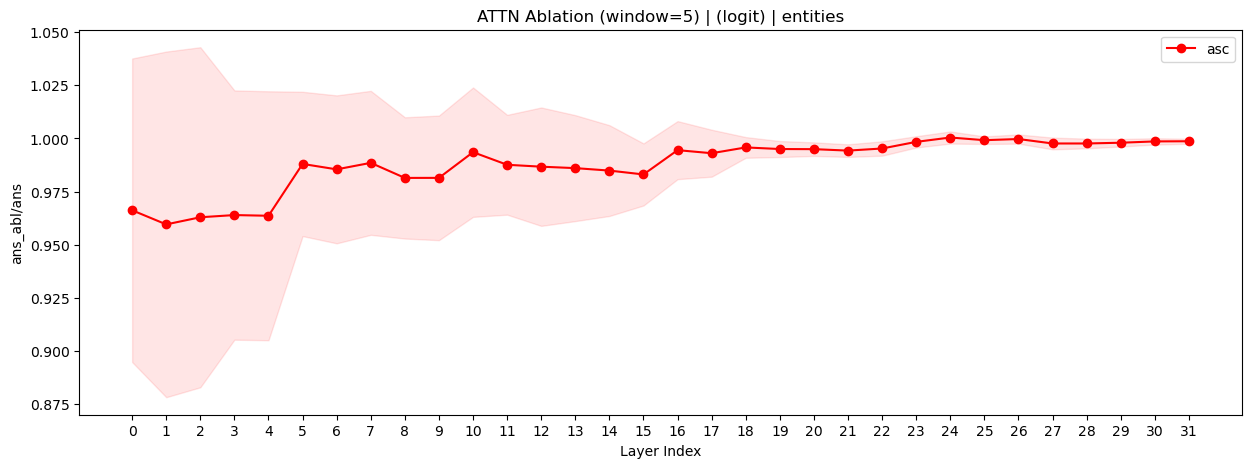

In [37]:
effects_window = process_effects_per_layer(
    effects=[e["attn_ablation_effects"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects]
    if metric in ["logit", "prob"]
    else None,
)

plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (window=5) | ({metric}) | {focus_strategy}")

plot_metric(effects_window, list(effects_asc.keys()), "asc", color="red")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

## Patching from a different run to check contribution

In [15]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix

set_seed(142)

prefix_generator = prefix_generator_cls(
    filter_attributes=["nationality", "profession", "school"],
    format="_3",
)

prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-17 12:51:02 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [16]:
from src.probing.prompt import prepare_probing_input
from src.probing.utils import get_lm_generated_answer

patch_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample.patched_entity, sample.common_entity),
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)


answer = get_lm_generated_answer(
    mt=mt,
    prompt=patch_prompt,
    is_a_reasoning_model=False,
    # is_a_reasoning_model=True
)
print(f"{(sample.patched_entity, sample.common_entity)} >> {answer=}")

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample.clean_entity, sample.common_entity),
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

clean_answer = get_lm_generated_answer(
    mt=mt,
    prompt=clean_prompt,
    is_a_reasoning_model=False,
    # is_a_reasoning_model=True
)
print(f"{(sample.clean_entity, sample.common_entity)} >> {clean_answer=}")

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


('Fatima Sheikh', 'Grace Wanjiru') >> answer='Urban Planner - they are both urban planners.<|eot_id|>'
('James Mwangi', 'Grace Wanjiru') >> clean_answer='Kenyan - they are both Kenyan.<|eot_id|>'


In [17]:
from src.functional import get_keywords_from_text

# keywords = get_keywords_from_text(text=answer, tokenizer=mt)
keywords = [predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data=patch_prompt.tokenized),
)[0][0].token_id]

[f"\"{mt.tokenizer.decode(k)}\"[{k}]" for k in keywords]

['" Urban"[29422]']

In [18]:
patch_attn_outputs = get_hs(
    mt=mt,
    input=patch_prompt.prompt,
    locations=[(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True,
)

In [19]:
gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=patch_prompt.tokenized),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric="logit",
)
print(f"{gold_score=}")

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=clean_prompt.tokenized),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric="logit",
)
print(f"{corrupt_score=}")

gold_score=18.0
corrupt_score=7.46875


In [20]:
patch_attn_outputs = get_hs(
    mt=mt,
    input=patch_prompt.prompt,
    locations=[(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True,
)

# layer_idx = 30
# layer_window = get_window(mt.attn_module_name_format, layer_idx, 5, mt.n_layer)
layer_window = range(30, 42) #! critical range
# layer_window = range(10, 30) #! too early
# layer_window = range(50, mt.n_layer-2) #! too late


layer_window = [mt.attn_module_name_format.format(l) for l in layer_window]
tokenized_input = TokenizerOutput(data=clean_prompt.tokenized)
last_tok_idx = tokenized_input.input_ids.shape[1] - 1

patches = [
    PatchSpec(location=(layer, last_tok_idx), patch=2 * patch_attn_outputs[(layer, -1)])
    for layer in layer_window
]
# patches = []

patched_score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=patches,
    ans_tokens=keywords,
    generate_full_ans=True,
    metric="logit",
)

print(f"{patched_score=}")
pred_print = [str(pred) for pred in pred]
print(f"{pred_print}")
print(f"{track=}")


indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

" Urban Planning - they are both urban planners."
patched_score=18.625
['" Urban"[29422] (p=0.547, logit=18.625)', '" Architect"[24979] (p=0.178, logit=17.500)', '" University"[3907] (p=0.107, logit=17.000)', '" urban"[16036] (p=0.037, logit=15.938)', '" Harvard"[25996] (p=0.026, logit=15.562)']
track={29422: (1, PredictedToken(token=' Urban', prob=0.546875, logit=18.625, token_id=29422, metadata=None))}
indirect_effect=1.0593471810089021


In [21]:
from src.functional import get_keywords_from_text
from typing import Optional
from tqdm import tqdm
from src.trace import get_window



@torch.inference_mode()
def do_patching_sweep(
    mt: ModelandTokenizer,
    samples: list[ActivationPatchingSamples],
    layers: Optional[list[int]] = None,
    token_idx=-1,  # TODO: incorporate different key positions like: subj_last, token_last, all_subj, ...
    metric: Literal["logit", "prob"] = "logit",
    coeff: float = 1.0,
    kind: Literal["mlp", "attn", "residual"] = "attn",
    window: int | Literal["from", "upto"] = 5,
) -> dict:
    layers = list(range(mt.n_layer)) if layers is None else layers
    module_name_format = {
        "residual": mt.layer_name_format,
        "mlp": mt.mlp_module_name_format,
        "attn": mt.attn_module_name_format,
    }[kind]

    results = []
    for idx, sample in tqdm(enumerate(samples)):
        logger.info(f"({idx + 1}/{len(samples)})  {sample}")
        if sample.clean_entity is None:
            logger.warning(f"Skipping sample {idx} with no clean entity.")
            continue

        kwargs = dict(
            prefix=prefix,
            answer_marker=prefix_generator_cls.answer_marker,
            question_marker=prefix_generator_cls.question_marker,
            block_separator=prefix_generator_cls.block_separator,
            is_a_reasoning_model=False,
            answer_prefix=" Yes -",
        )

        patch_prompt = prepare_probing_input(
            mt=mt,
            entities=(sample.patched_entity, sample.common_entity),
            **kwargs,
        )

        answer = get_lm_generated_answer(
            mt=mt,
            prompt=patch_prompt,
            is_a_reasoning_model=False,
        )
        logger.info(f"{(sample.patched_entity, sample.common_entity)} >> {answer=}")

        clean_prompt = prepare_probing_input(
            mt=mt, entities=(sample.clean_entity, sample.common_entity), **kwargs
        )

        clean_answer = get_lm_generated_answer(
            mt=mt,
            prompt=clean_prompt,
            is_a_reasoning_model=False,
        )
        logger.info(f"{(sample.clean_entity, sample.common_entity)} >> {clean_answer=}")

        # answer_tokens = get_keywords_from_text(text=answer, tokenizer=mt)
        answer_tokens = [
            predict_next_token(
                mt=mt,
                inputs=TokenizerOutput(data=patch_prompt.tokenized),
            )[0][0].token_id
        ]
        logger.info(f"{[f'{t}({mt.tokenizer.decode(t)})' for t in answer_tokens]}")

        gold_score, gold_pred, gold_track = patched_run(
            mt=mt,
            inputs=TokenizerOutput(data=patch_prompt.tokenized),
            patches=[],
            ans_tokens=answer_tokens,
            metric=metric,
        )
        logger.info(f"{gold_score=}")

        corrupt_score, corrupt_pred, corrupt_track = patched_run(
            mt=mt,
            inputs=TokenizerOutput(data=clean_prompt.tokenized),
            patches=[],
            ans_tokens=answer_tokens,
            metric=metric,
        )
        logger.info(f"{corrupt_score=}")

        patch_layers = {}
        unique_layers = []
        for layer_idx in layers:
            if window == "from":
                layer_window = range(layer_idx, mt.n_layer)
            elif window == "upto":
                layer_window = range(0, layer_idx + 1)
            else:
                assert isinstance(window, int)
                layer_window = [
                    int(l) for l in get_window("{}", layer_idx, window, mt.n_layer)
                ]

            patch_layers[layer_idx] = [
                module_name_format.format(l) for l in layer_window
            ]
            unique_layers += patch_layers[layer_idx]

        unique_layers = set(unique_layers)

        patch_outputs = get_hs(
            mt=mt,
            input=patch_prompt.prompt,
            locations=[(l, token_idx) for l in unique_layers],
            return_dict=True,
        )

        patching_results = {}
        clean_input = TokenizerOutput(data=clean_prompt.tokenized)

        #! currently assumes `token_idx to cache state from LM(patch_input) == token_idx to patch to LM(clean_input)` (change?)
        patch_token_idx = token_idx
        if patch_token_idx < 0:
            patch_token_idx = clean_input.input_ids.shape[1] + token_idx

        for layer_idx, layer_window in patch_layers.items():
            patches = [
                PatchSpec(
                    location=(layer, patch_token_idx),
                    patch=coeff * patch_outputs[(layer, token_idx)],
                )
                for layer in layer_window
            ]

            patched_score, pred, track = patched_run(
                mt=mt,
                inputs=clean_input,
                patches=patches,
                ans_tokens=answer_tokens,
                generate_full_ans=False,
                metric=metric,
            )

            logger.debug(f"         {layer_idx=}, {patched_score=}")
            # print(layer_window)

            patching_results[layer_idx] = dict(
                score=patched_score,
                pred=pred,
                track=track,
            )

        logger.debug("-" * 30)

        results.append(
            dict(
                sample=sample,
                answer=answer,
                answer_tokens=answer_tokens,
                gold_score=gold_score,
                corrupt_score=corrupt_score,
                patching_results=patching_results,
            )
        )

    return results

In [22]:
target_attribute

'profession'

In [23]:
activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
first_atten_look_path = os.path.join(activation_patching_path, "1st_attn_look")
os.makedirs(first_atten_look_path, exist_ok=True)

### Running the ATTN patching sweep and caching the results

In [99]:
kwargs = dict(
    mt=mt,
    # samples = [coincidences["examples"][sample_idx]],
    samples=samples,
    token_idx=-1,
    metric="logit",
    coeff=1.0,
    kind="attn",
)

res_from = do_patching_sweep(
    **kwargs,
    window="from",
)

with open(os.path.join(first_atten_look_path, "res_from.json"), "w") as f:
    json.dump(res_from, f, indent=4, default=str)



res_upto = do_patching_sweep(
    **kwargs,
    window="upto",
)

with open(os.path.join(first_atten_look_path, "res_upto.json"), "w") as f:
    json.dump(res_upto, f, indent=4, default=str)


res_win = do_patching_sweep(
    **kwargs,
    window=5,
)

with open(os.path.join(first_atten_look_path, "res_win.json"), "w") as f:
    json.dump(res_win, f, indent=4, default=str)

0it [00:00, ?it/s]

2025-06-11 09:18:12 __main__ INFO     (1/32)  Fatima Sheikh | Siriporn Suwannarat => " University" | <-- | Mohammad Aziz => " Pakistani"


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-06-11 09:18:14 __main__ INFO     ('Mohammad Aziz', 'Fatima Sheikh') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:18:15 __main__ INFO     ('Siriporn Suwannarat', 'Fatima Sheikh') >> clean_answer='Oxford University - they both graduated from Oxford University.<|eot_id|>'
2025-06-11 09:18:16 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:18:16 __main__ INFO     gold_score=18.5
2025-06-11 09:18:16 __main__ INFO     corrupt_score=12.375
2025-06-11 09:18:17 __main__ DEBUG             layer_idx=0, patched_score=18.5
2025-06-11 09:18:17 __main__ DEBUG             layer_idx=1, patched_score=18.5
2025-06-11 09:18:17 __main__ DEBUG             layer_idx=2, patched_score=18.625
2025-06-11 09:18:18 __main__ DEBUG             layer_idx=3, patched_score=18.625
2025-06-11 09:18:18 __main__ DEBUG             layer_idx=4, patched_score=18.5
2025-06-11 09:18:18 __main__ DEBUG             layer_idx=5, patched_score=18.625
2025-06-11 09:18:19 __main__ DEBUG          

1it [00:27, 27.77s/it]

2025-06-11 09:18:40 __main__ INFO     (2/32)  Mohammad Aziz | Sophie Evans => " University" | <-- | Fatima Sheikh => " Pakistani"
2025-06-11 09:18:41 __main__ INFO     ('Fatima Sheikh', 'Mohammad Aziz') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:18:43 __main__ INFO     ('Sophie Evans', 'Mohammad Aziz') >> clean_answer='University of Edinburgh - they both graduated from University of Edinburgh.<|eot_id|>'
2025-06-11 09:18:44 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:18:44 __main__ INFO     gold_score=18.5
2025-06-11 09:18:44 __main__ INFO     corrupt_score=13.0
2025-06-11 09:18:45 __main__ DEBUG             layer_idx=0, patched_score=18.5
2025-06-11 09:18:45 __main__ DEBUG             layer_idx=1, patched_score=18.5
2025-06-11 09:18:45 __main__ DEBUG             layer_idx=2, patched_score=18.5
2025-06-11 09:18:45 __main__ DEBUG             layer_idx=3, patched_score=18.5
2025-06-11 09:18:46 __main__ DEBUG             layer_idx=4, patched_score=1

2it [00:51, 25.30s/it]

2025-06-11 09:19:04 __main__ INFO     (3/32)  Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-06-11 09:19:05 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:19:06 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> clean_answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-11 09:19:07 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:19:07 __main__ INFO     gold_score=19.75
2025-06-11 09:19:07 __main__ INFO     corrupt_score=10.75
2025-06-11 09:19:08 __main__ DEBUG             layer_idx=0, patched_score=19.75
2025-06-11 09:19:08 __main__ DEBUG             layer_idx=1, patched_score=19.75
2025-06-11 09:19:09 __main__ DEBUG             layer_idx=2, patched_score=19.75
2025-06-11 09:19:09 __main__ DEBUG             layer_idx=3, patched_score=19.75
2025-06-11 09:19:09 __main__ DEBUG             layer_idx=4, patched_score=19.75
2025-06-11 09:19

3it [01:18, 26.33s/it]

2025-06-11 09:19:31 __main__ INFO     (4/32)  Takeshi Yamamoto | Rahman Ali => " Civil" | <-- | Yuki Tanaka => " Japanese"
2025-06-11 09:19:32 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:19:34 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:19:34 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:19:35 __main__ INFO     gold_score=20.125
2025-06-11 09:19:35 __main__ INFO     corrupt_score=14.4375
2025-06-11 09:19:36 __main__ DEBUG             layer_idx=0, patched_score=20.125
2025-06-11 09:19:36 __main__ DEBUG             layer_idx=1, patched_score=20.125
2025-06-11 09:19:36 __main__ DEBUG             layer_idx=2, patched_score=20.125
2025-06-11 09:19:36 __main__ DEBUG             layer_idx=3, patched_score=20.125
2025-06-11 09:19:37 __main__ DEBUG             layer_idx=4, patched_score=20.125
2025-06-11 09:19:

4it [01:46, 26.82s/it]

2025-06-11 09:19:59 __main__ INFO     (5/32)  Chinedu Okafor | Nguyen Van Duc => " Doctor" | <-- | Amara Adeyemi => " Nigerian"
2025-06-11 09:20:00 __main__ INFO     ('Amara Adeyemi', 'Chinedu Okafor') >> answer='Nigerian - they are both Nigerian.<|eot_id|>'
2025-06-11 09:20:01 __main__ INFO     ('Nguyen Van Duc', 'Chinedu Okafor') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:20:02 __main__ INFO     ['55433( Nigerian)']
2025-06-11 09:20:02 __main__ INFO     gold_score=19.75
2025-06-11 09:20:02 __main__ INFO     corrupt_score=9.5
2025-06-11 09:20:03 __main__ DEBUG             layer_idx=0, patched_score=19.75
2025-06-11 09:20:03 __main__ DEBUG             layer_idx=1, patched_score=19.75
2025-06-11 09:20:03 __main__ DEBUG             layer_idx=2, patched_score=19.75
2025-06-11 09:20:04 __main__ DEBUG             layer_idx=3, patched_score=19.75
2025-06-11 09:20:04 __main__ DEBUG             layer_idx=4, patched_score=19.75
2025-06-11 09:20:04 __main__ DEBUG  

5it [02:13, 27.02s/it]

2025-06-11 09:20:26 __main__ INFO     (6/32)  Anna Schmidt | None => "None" | <-- | Hans Mueller => " German"
2025-06-11 09:20:26 __main__ WARNING  Skipping sample 5 with no clean entity.
2025-06-11 09:20:26 __main__ INFO     (7/32)  Hans Mueller | Elena Georgiou => " University" | <-- | Anna Schmidt => " German"
2025-06-11 09:20:27 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> answer='German - they are both German.<|eot_id|>'
2025-06-11 09:20:29 __main__ INFO     ('Elena Georgiou', 'Hans Mueller') >> clean_answer='University of Toronto - they both graduated from University of Toronto.<|eot_id|>'
2025-06-11 09:20:30 __main__ INFO     ['6063( German)']
2025-06-11 09:20:30 __main__ INFO     gold_score=20.625
2025-06-11 09:20:30 __main__ INFO     corrupt_score=14.875
2025-06-11 09:20:30 __main__ DEBUG             layer_idx=0, patched_score=20.625
2025-06-11 09:20:31 __main__ DEBUG             layer_idx=1, patched_score=20.625
2025-06-11 09:20:31 __main__ DEBUG             layer_id

7it [02:37, 19.24s/it]

2025-06-11 09:20:50 __main__ INFO     (8/32)  Carlos Rodriguez | Jose Cruz => " Stanford" | <-- | Sofia Hernandez => " Mexico"
2025-06-11 09:20:51 __main__ INFO     ('Sofia Hernandez', 'Carlos Rodriguez') >> answer='Mexico - they are both Mexican.<|eot_id|>'
2025-06-11 09:20:52 __main__ INFO     ('Jose Cruz', 'Carlos Rodriguez') >> clean_answer='Stanford University - they both graduated from Stanford University.<|eot_id|>'
2025-06-11 09:20:53 __main__ INFO     ['12550( Mexico)']
2025-06-11 09:20:53 __main__ INFO     gold_score=17.25
2025-06-11 09:20:53 __main__ INFO     corrupt_score=11.8125
2025-06-11 09:20:54 __main__ DEBUG             layer_idx=0, patched_score=17.25
2025-06-11 09:20:54 __main__ DEBUG             layer_idx=1, patched_score=17.25
2025-06-11 09:20:54 __main__ DEBUG             layer_idx=2, patched_score=17.25
2025-06-11 09:20:54 __main__ DEBUG             layer_idx=3, patched_score=17.25
2025-06-11 09:20:55 __main__ DEBUG             layer_idx=4, patched_score=17.25
2

8it [03:00, 20.28s/it]

2025-06-11 09:21:13 __main__ INFO     (9/32)  Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"
2025-06-11 09:21:14 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:21:15 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> clean_answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-11 09:21:16 __main__ INFO     ['7904( Indian)']
2025-06-11 09:21:16 __main__ INFO     gold_score=16.625
2025-06-11 09:21:16 __main__ INFO     corrupt_score=11.375
2025-06-11 09:21:17 __main__ DEBUG             layer_idx=0, patched_score=16.625
2025-06-11 09:21:17 __main__ DEBUG             layer_idx=1, patched_score=16.5
2025-06-11 09:21:17 __main__ DEBUG             layer_idx=2, patched_score=16.625
2025-06-11 09:21:18 __main__ DEBUG             layer_idx=3, patched_score=16.625
2025-06-11 09:21:18 __main__ DEBUG             layer_idx=4, patched_score=16.625
2025-06-11 09:21:18 __main

9it [03:23, 21.09s/it]

2025-06-11 09:21:36 __main__ INFO     (10/32)  Rajesh Kumar | Ayse Kaya => " Doctor" | <-- | Priya Patel => " Indian"
2025-06-11 09:21:37 __main__ INFO     ('Priya Patel', 'Rajesh Kumar') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:21:38 __main__ INFO     ('Ayse Kaya', 'Rajesh Kumar') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:21:39 __main__ INFO     ['7904( Indian)']
2025-06-11 09:21:39 __main__ INFO     gold_score=19.125
2025-06-11 09:21:39 __main__ INFO     corrupt_score=12.125
2025-06-11 09:21:40 __main__ DEBUG             layer_idx=0, patched_score=19.125
2025-06-11 09:21:40 __main__ DEBUG             layer_idx=1, patched_score=19.125
2025-06-11 09:21:41 __main__ DEBUG             layer_idx=2, patched_score=19.125
2025-06-11 09:21:41 __main__ DEBUG             layer_idx=3, patched_score=19.125
2025-06-11 09:21:41 __main__ DEBUG             layer_idx=4, patched_score=19.0
2025-06-11 09:21:42 __main__ DEBUG             layer_idx=

10it [03:50, 22.87s/it]

2025-06-11 09:22:03 __main__ INFO     (11/32)  Layla Mahmoud | Rajesh Kumar => " Doctor" | <-- | Ahmed Hassan => " Egyptian"
2025-06-11 09:22:04 __main__ INFO     ('Ahmed Hassan', 'Layla Mahmoud') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:22:06 __main__ INFO     ('Rajesh Kumar', 'Layla Mahmoud') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:22:06 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:22:06 __main__ INFO     gold_score=19.875
2025-06-11 09:22:07 __main__ INFO     corrupt_score=16.5
2025-06-11 09:22:07 __main__ DEBUG             layer_idx=0, patched_score=19.875
2025-06-11 09:22:07 __main__ DEBUG             layer_idx=1, patched_score=19.875
2025-06-11 09:22:08 __main__ DEBUG             layer_idx=2, patched_score=19.875
2025-06-11 09:22:08 __main__ DEBUG             layer_idx=3, patched_score=19.875
2025-06-11 09:22:08 __main__ DEBUG             layer_idx=4, patched_score=19.875
2025-06-11 09:22:09 __main__ DEBUG   

11it [04:18, 24.10s/it]

2025-06-11 09:22:31 __main__ INFO     (12/32)  Ahmed Hassan | João Silva => " Doctor" | <-- | Layla Mahmoud => " Egyptian"
2025-06-11 09:22:32 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:22:33 __main__ INFO     ('João Silva', 'Ahmed Hassan') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:22:33 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:22:33 __main__ INFO     gold_score=20.125
2025-06-11 09:22:34 __main__ INFO     corrupt_score=12.3125
2025-06-11 09:22:34 __main__ DEBUG             layer_idx=0, patched_score=20.125
2025-06-11 09:22:34 __main__ DEBUG             layer_idx=1, patched_score=20.125
2025-06-11 09:22:35 __main__ DEBUG             layer_idx=2, patched_score=20.125
2025-06-11 09:22:35 __main__ DEBUG             layer_idx=3, patched_score=20.125
2025-06-11 09:22:35 __main__ DEBUG             layer_idx=4, patched_score=20.125
2025-06-11 09:22:35 __main__ DEBUG     

12it [04:40, 23.72s/it]

2025-06-11 09:22:53 __main__ INFO     (13/32)  Grace Wanjiru | Fatima Sheikh => " Urban" | <-- | James Mwangi => " Ken"
2025-06-11 09:22:55 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:22:56 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> clean_answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-11 09:22:57 __main__ INFO     ['14594( Ken)']
2025-06-11 09:22:57 __main__ INFO     gold_score=20.5
2025-06-11 09:22:57 __main__ INFO     corrupt_score=10.75
2025-06-11 09:22:58 __main__ DEBUG             layer_idx=0, patched_score=20.5
2025-06-11 09:22:58 __main__ DEBUG             layer_idx=1, patched_score=20.625
2025-06-11 09:22:58 __main__ DEBUG             layer_idx=2, patched_score=20.5
2025-06-11 09:22:59 __main__ DEBUG             layer_idx=3, patched_score=20.625
2025-06-11 09:22:59 __main__ DEBUG             layer_idx=4, patched_score=20.5
2025-06-11 09:22:59 __main__ DEBUG         

13it [05:08, 24.92s/it]

2025-06-11 09:23:21 __main__ INFO     (14/32)  James Mwangi | Piotr Kowalski => " Doctor" | <-- | Grace Wanjiru => " Ken"
2025-06-11 09:23:23 __main__ INFO     ('Grace Wanjiru', 'James Mwangi') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:23:24 __main__ INFO     ('Piotr Kowalski', 'James Mwangi') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:23:24 __main__ INFO     ['14594( Ken)']
2025-06-11 09:23:24 __main__ INFO     gold_score=20.125
2025-06-11 09:23:25 __main__ INFO     corrupt_score=11.0625
2025-06-11 09:23:25 __main__ DEBUG             layer_idx=0, patched_score=20.125
2025-06-11 09:23:26 __main__ DEBUG             layer_idx=1, patched_score=20.0
2025-06-11 09:23:26 __main__ DEBUG             layer_idx=2, patched_score=20.0
2025-06-11 09:23:26 __main__ DEBUG             layer_idx=3, patched_score=20.0
2025-06-11 09:23:27 __main__ DEBUG             layer_idx=4, patched_score=20.0
2025-06-11 09:23:27 __main__ DEBUG             layer_

14it [05:36, 25.72s/it]

2025-06-11 09:23:49 __main__ INFO     (15/32)  Katarzyna Nowak | Erik Andersson => " Doctor" | <-- | Piotr Kowalski => " Poland"
2025-06-11 09:23:50 __main__ INFO     ('Piotr Kowalski', 'Katarzyna Nowak') >> answer='Poland - they are both Polish.<|eot_id|>'
2025-06-11 09:23:51 __main__ INFO     ('Erik Andersson', 'Katarzyna Nowak') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:23:52 __main__ INFO     ['28702( Poland)']
2025-06-11 09:23:52 __main__ INFO     gold_score=18.625
2025-06-11 09:23:52 __main__ INFO     corrupt_score=12.5625
2025-06-11 09:23:53 __main__ DEBUG             layer_idx=0, patched_score=18.625
2025-06-11 09:23:53 __main__ DEBUG             layer_idx=1, patched_score=18.625
2025-06-11 09:23:53 __main__ DEBUG             layer_idx=2, patched_score=18.625
2025-06-11 09:23:54 __main__ DEBUG             layer_idx=3, patched_score=18.625
2025-06-11 09:23:54 __main__ DEBUG             layer_idx=4, patched_score=18.625
2025-06-11 09:23:54 __main__

15it [06:03, 26.22s/it]

2025-06-11 09:24:16 __main__ INFO     (16/32)  Siriporn Suwannarat | Marie Laurent => " Le" | <-- | Somchai Jaidee => " Thai"
2025-06-11 09:24:17 __main__ INFO     ('Somchai Jaidee', 'Siriporn Suwannarat') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:24:18 __main__ INFO     ('Marie Laurent', 'Siriporn Suwannarat') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:24:19 __main__ INFO     ['27490( Thai)']
2025-06-11 09:24:19 __main__ INFO     gold_score=16.875
2025-06-11 09:24:20 __main__ INFO     corrupt_score=12.1875
2025-06-11 09:24:20 __main__ DEBUG             layer_idx=0, patched_score=16.875
2025-06-11 09:24:20 __main__ DEBUG             layer_idx=1, patched_score=16.875
2025-06-11 09:24:21 __main__ DEBUG             layer_idx=2, patched_score=16.875
2025-06-11 09:24:21 __main__ DEBUG             layer_idx=3, patched_score=16.875
2025-06-11 09:24:21 __main__ DEBUG             layer_idx=4, patched_score=16.75
2025-06-11 09:24:22 __main__ DE

16it [06:31, 26.57s/it]

2025-06-11 09:24:44 __main__ INFO     (17/32)  Somchai Jaidee | Jan de Vries => " Doctor" | <-- | Siriporn Suwannarat => " Thai"
2025-06-11 09:24:45 __main__ INFO     ('Siriporn Suwannarat', 'Somchai Jaidee') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:24:46 __main__ INFO     ('Jan de Vries', 'Somchai Jaidee') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:24:46 __main__ INFO     ['27490( Thai)']
2025-06-11 09:24:47 __main__ INFO     gold_score=18.75
2025-06-11 09:24:47 __main__ INFO     corrupt_score=10.0
2025-06-11 09:24:48 __main__ DEBUG             layer_idx=0, patched_score=18.75
2025-06-11 09:24:48 __main__ DEBUG             layer_idx=1, patched_score=18.75
2025-06-11 09:24:48 __main__ DEBUG             layer_idx=2, patched_score=18.75
2025-06-11 09:24:48 __main__ DEBUG             layer_idx=3, patched_score=18.75
2025-06-11 09:24:49 __main__ DEBUG             layer_idx=4, patched_score=18.625
2025-06-11 09:24:49 __main__ DEBUG       

17it [06:58, 26.81s/it]

2025-06-11 09:25:11 __main__ INFO     (18/32)  Fatima Alaoui | Camila Torres => " University" | <-- | Youssef Benali => " Morocco"
2025-06-11 09:25:12 __main__ INFO     ('Youssef Benali', 'Fatima Alaoui') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:25:14 __main__ INFO     ('Camila Torres', 'Fatima Alaoui') >> clean_answer='University of California, Berkeley - they both graduated from University of California, Berkeley.<|eot_id|>'
2025-06-11 09:25:15 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:25:15 __main__ INFO     gold_score=17.75
2025-06-11 09:25:15 __main__ INFO     corrupt_score=7.09375
2025-06-11 09:25:16 __main__ DEBUG             layer_idx=0, patched_score=17.75
2025-06-11 09:25:16 __main__ DEBUG             layer_idx=1, patched_score=17.875
2025-06-11 09:25:17 __main__ DEBUG             layer_idx=2, patched_score=17.75
2025-06-11 09:25:17 __main__ DEBUG             layer_idx=3, patched_score=17.875
2025-06-11 09:25:17 __main__ DEBUG           

18it [07:26, 27.27s/it]

2025-06-11 09:25:39 __main__ INFO     (19/32)  Youssef Benali | Sarah MacDonald => " Doctor" | <-- | Fatima Alaoui => " Morocco"
2025-06-11 09:25:40 __main__ INFO     ('Fatima Alaoui', 'Youssef Benali') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:25:42 __main__ INFO     ('Sarah MacDonald', 'Youssef Benali') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:25:42 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:25:42 __main__ INFO     gold_score=18.625
2025-06-11 09:25:43 __main__ INFO     corrupt_score=9.375
2025-06-11 09:25:43 __main__ DEBUG             layer_idx=0, patched_score=18.625
2025-06-11 09:25:44 __main__ DEBUG             layer_idx=1, patched_score=18.625
2025-06-11 09:25:44 __main__ DEBUG             layer_idx=2, patched_score=18.625
2025-06-11 09:25:44 __main__ DEBUG             layer_idx=3, patched_score=18.625
2025-06-11 09:25:45 __main__ DEBUG             layer_idx=4, patched_score=18.625
2025-06-11 09:25:45 __main__

19it [07:54, 27.30s/it]

2025-06-11 09:26:07 __main__ INFO     (20/32)  Jack Wilson | António Costa => " Software" | <-- | Emma Taylor => " Australian"
2025-06-11 09:26:08 __main__ INFO     ('Emma Taylor', 'Jack Wilson') >> answer='Australian - they are both Australian.<|eot_id|>'
2025-06-11 09:26:09 __main__ INFO     ('António Costa', 'Jack Wilson') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:26:09 __main__ INFO     ['13673( Australian)']
2025-06-11 09:26:10 __main__ INFO     gold_score=18.25
2025-06-11 09:26:10 __main__ INFO     corrupt_score=9.5
2025-06-11 09:26:10 __main__ DEBUG             layer_idx=0, patched_score=18.25
2025-06-11 09:26:11 __main__ DEBUG             layer_idx=1, patched_score=18.25
2025-06-11 09:26:11 __main__ DEBUG             layer_idx=2, patched_score=18.25
2025-06-11 09:26:11 __main__ DEBUG             layer_idx=3, patched_score=18.25
2025-06-11 09:26:12 __main__ DEBUG             layer_idx=4, patched_score=18.25
2025-06-11 09:26:12 __main__ DEBUG      

20it [08:21, 27.26s/it]

2025-06-11 09:26:34 __main__ INFO     (21/32)  Tran Thi Mai | Marco Rossi => " Architect" | <-- | Nguyen Van Duc => " Vietnamese"
2025-06-11 09:26:35 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:26:36 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> clean_answer='Architect - they are both architects.<|eot_id|>'
2025-06-11 09:26:37 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:26:37 __main__ INFO     gold_score=19.125
2025-06-11 09:26:37 __main__ INFO     corrupt_score=10.75
2025-06-11 09:26:38 __main__ DEBUG             layer_idx=0, patched_score=19.125
2025-06-11 09:26:38 __main__ DEBUG             layer_idx=1, patched_score=19.125
2025-06-11 09:26:38 __main__ DEBUG             layer_idx=2, patched_score=19.125
2025-06-11 09:26:38 __main__ DEBUG             layer_idx=3, patched_score=19.125
2025-06-11 09:26:39 __main__ DEBUG             layer_idx=4, patched_score=19.125
2025-06-11 09:26:39 

21it [08:44, 25.99s/it]

2025-06-11 09:26:57 __main__ INFO     (22/32)  Nguyen Van Duc | Chinedu Okafor => " Doctor" | <-- | Tran Thi Mai => " Vietnamese"
2025-06-11 09:26:58 __main__ INFO     ('Tran Thi Mai', 'Nguyen Van Duc') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:26:59 __main__ INFO     ('Chinedu Okafor', 'Nguyen Van Duc') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:27:00 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:27:00 __main__ INFO     gold_score=19.875
2025-06-11 09:27:00 __main__ INFO     corrupt_score=10.875
2025-06-11 09:27:01 __main__ DEBUG             layer_idx=0, patched_score=19.875
2025-06-11 09:27:01 __main__ DEBUG             layer_idx=1, patched_score=19.75
2025-06-11 09:27:01 __main__ DEBUG             layer_idx=2, patched_score=19.75
2025-06-11 09:27:02 __main__ DEBUG             layer_idx=3, patched_score=19.75
2025-06-11 09:27:02 __main__ DEBUG             layer_idx=4, patched_score=19.875
2025-06-11 09:27:02 __m

22it [09:11, 26.41s/it]

2025-06-11 09:27:24 __main__ INFO     (23/32)  Rahman Ali | Takeshi Yamamoto => " Civil" | <-- | Nasreen Begum => " Bangladesh"
2025-06-11 09:27:26 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-11 09:27:27 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:27:28 __main__ INFO     ['39601( Bangladesh)']
2025-06-11 09:27:28 __main__ INFO     gold_score=19.0
2025-06-11 09:27:28 __main__ INFO     corrupt_score=12.4375
2025-06-11 09:27:29 __main__ DEBUG             layer_idx=0, patched_score=19.0
2025-06-11 09:27:29 __main__ DEBUG             layer_idx=1, patched_score=19.0
2025-06-11 09:27:29 __main__ DEBUG             layer_idx=2, patched_score=19.0
2025-06-11 09:27:30 __main__ DEBUG             layer_idx=3, patched_score=19.0
2025-06-11 09:27:30 __main__ DEBUG             layer_idx=4, patched_score=19.0
2025-06-11 09:27:30 _

23it [09:39, 26.85s/it]

2025-06-11 09:27:52 __main__ INFO     (24/32)  Alexandru Popescu | David Thompson => " University" | <-- | Elena Ionescu => " Romanian"
2025-06-11 09:27:53 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-11 09:27:55 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> clean_answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-11 09:27:55 __main__ INFO     ['74697( Romanian)']
2025-06-11 09:27:55 __main__ INFO     gold_score=19.0
2025-06-11 09:27:56 __main__ INFO     corrupt_score=14.125
2025-06-11 09:27:56 __main__ DEBUG             layer_idx=0, patched_score=19.0
2025-06-11 09:27:57 __main__ DEBUG             layer_idx=1, patched_score=19.0
2025-06-11 09:27:57 __main__ DEBUG             layer_idx=2, patched_score=19.125
2025-06-11 09:27:57 __main__ DEBUG             layer_idx=3, patched_score=19.0
2025-06-11 09:27:58 __main__ DEBUG             layer_idx=4, patched_

24it [10:07, 27.07s/it]

2025-06-11 09:28:20 __main__ INFO     (25/32)  Akosua Boateng | Giulia Romano => " Doctor" | <-- | Kwame Mensah => " Ghana"
2025-06-11 09:28:21 __main__ INFO     ('Kwame Mensah', 'Akosua Boateng') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:28:22 __main__ INFO     ('Giulia Romano', 'Akosua Boateng') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:28:23 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:28:23 __main__ INFO     gold_score=21.375
2025-06-11 09:28:23 __main__ INFO     corrupt_score=5.8125
2025-06-11 09:28:24 __main__ DEBUG             layer_idx=0, patched_score=21.375
2025-06-11 09:28:24 __main__ DEBUG             layer_idx=1, patched_score=21.375
2025-06-11 09:28:25 __main__ DEBUG             layer_idx=2, patched_score=21.375
2025-06-11 09:28:25 __main__ DEBUG             layer_idx=3, patched_score=21.375
2025-06-11 09:28:25 __main__ DEBUG             layer_idx=4, patched_score=21.375
2025-06-11 09:28:25 __main__ DEBUG  

25it [10:34, 27.23s/it]

2025-06-11 09:28:47 __main__ INFO     (26/32)  Kwame Mensah | Min-jun Park => " Ge" | <-- | Akosua Boateng => " Ghana"
2025-06-11 09:28:49 __main__ INFO     ('Akosua Boateng', 'Kwame Mensah') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:28:50 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> clean_answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-11 09:28:51 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:28:51 __main__ INFO     gold_score=20.25
2025-06-11 09:28:51 __main__ INFO     corrupt_score=13.4375
2025-06-11 09:28:52 __main__ DEBUG             layer_idx=0, patched_score=20.25
2025-06-11 09:28:52 __main__ DEBUG             layer_idx=1, patched_score=20.25
2025-06-11 09:28:52 __main__ DEBUG             layer_idx=2, patched_score=20.25
2025-06-11 09:28:53 __main__ DEBUG             layer_idx=3, patched_score=20.25
2025-06-11 09:28:53 __main__ DEBUG             layer_idx=4, patched_score=20.25
2025-06-11 09:28:53 __main__ DEBUG         

26it [11:02, 27.41s/it]

2025-06-11 09:29:15 __main__ INFO     (27/32)  Natasha Ivanova | Valentina Lopez => " Doctor" | <-- | Ivan Petrov => " Russian"
2025-06-11 09:29:16 __main__ INFO     ('Ivan Petrov', 'Natasha Ivanova') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:29:17 __main__ INFO     ('Valentina Lopez', 'Natasha Ivanova') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:29:18 __main__ INFO     ['8690( Russian)']
2025-06-11 09:29:18 __main__ INFO     gold_score=21.25
2025-06-11 09:29:19 __main__ INFO     corrupt_score=12.625
2025-06-11 09:29:19 __main__ DEBUG             layer_idx=0, patched_score=21.25
2025-06-11 09:29:19 __main__ DEBUG             layer_idx=1, patched_score=21.25
2025-06-11 09:29:20 __main__ DEBUG             layer_idx=2, patched_score=21.25
2025-06-11 09:29:20 __main__ DEBUG             layer_idx=3, patched_score=21.25
2025-06-11 09:29:20 __main__ DEBUG             layer_idx=4, patched_score=21.25
2025-06-11 09:29:21 __main__ DEBUG  

27it [11:30, 27.39s/it]

2025-06-11 09:29:43 __main__ INFO     (28/32)  Ivan Petrov | Laura Fernandez => " Doctor" | <-- | Natasha Ivanova => " Russian"
2025-06-11 09:29:44 __main__ INFO     ('Natasha Ivanova', 'Ivan Petrov') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:29:45 __main__ INFO     ('Laura Fernandez', 'Ivan Petrov') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:29:45 __main__ INFO     ['8690( Russian)']
2025-06-11 09:29:46 __main__ INFO     gold_score=19.625
2025-06-11 09:29:46 __main__ INFO     corrupt_score=13.8125
2025-06-11 09:29:46 __main__ DEBUG             layer_idx=0, patched_score=19.625
2025-06-11 09:29:47 __main__ DEBUG             layer_idx=1, patched_score=19.5
2025-06-11 09:29:47 __main__ DEBUG             layer_idx=2, patched_score=19.5
2025-06-11 09:29:47 __main__ DEBUG             layer_idx=3, patched_score=19.625
2025-06-11 09:29:47 __main__ DEBUG             layer_idx=4, patched_score=19.5
2025-06-11 09:29:48 __main__ DEBUG     

28it [11:53, 26.07s/it]

2025-06-11 09:30:06 __main__ INFO     (29/32)  Rodrigo Gonzalez | Maria dela Rosa => " Mechanical" | <-- | Camila Torres => " Chile"
2025-06-11 09:30:07 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-11 09:30:08 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> clean_answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-11 09:30:09 __main__ INFO     ['34100( Chile)']
2025-06-11 09:30:09 __main__ INFO     gold_score=17.25
2025-06-11 09:30:09 __main__ INFO     corrupt_score=9.8125
2025-06-11 09:30:10 __main__ DEBUG             layer_idx=0, patched_score=17.25
2025-06-11 09:30:10 __main__ DEBUG             layer_idx=1, patched_score=17.25
2025-06-11 09:30:10 __main__ DEBUG             layer_idx=2, patched_score=17.25
2025-06-11 09:30:11 __main__ DEBUG             layer_idx=3, patched_score=17.25
2025-06-11 09:30:11 __main__ DEBUG             

29it [12:16, 25.33s/it]

2025-06-11 09:30:29 __main__ INFO     (30/32)  Ali Rezaei | João Silva => " Doctor" | <-- | Zahra Hosseini => " Iranian"
2025-06-11 09:30:30 __main__ INFO     ('Zahra Hosseini', 'Ali Rezaei') >> answer='Iranian - they are both Iranian.<|eot_id|>'
2025-06-11 09:30:31 __main__ INFO     ('João Silva', 'Ali Rezaei') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:30:32 __main__ INFO     ['28501( Iranian)']
2025-06-11 09:30:32 __main__ INFO     gold_score=17.75
2025-06-11 09:30:32 __main__ INFO     corrupt_score=9.5
2025-06-11 09:30:33 __main__ DEBUG             layer_idx=0, patched_score=17.75
2025-06-11 09:30:33 __main__ DEBUG             layer_idx=1, patched_score=17.75
2025-06-11 09:30:34 __main__ DEBUG             layer_idx=2, patched_score=17.75
2025-06-11 09:30:34 __main__ DEBUG             layer_idx=3, patched_score=17.75
2025-06-11 09:30:34 __main__ DEBUG             layer_idx=4, patched_score=17.75
2025-06-11 09:30:35 __main__ DEBUG             layer_idx=

30it [12:44, 25.94s/it]

2025-06-11 09:30:56 __main__ INFO     (31/32)  Rachel Levy | Mehmet Yilmaz => " Harvard" | <-- | David Cohen => " Israeli"
2025-06-11 09:30:58 __main__ INFO     ('David Cohen', 'Rachel Levy') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:30:59 __main__ INFO     ('Mehmet Yilmaz', 'Rachel Levy') >> clean_answer='Harvard University - they both graduated from Harvard University.<|eot_id|>'
2025-06-11 09:31:00 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:31:00 __main__ INFO     gold_score=18.75
2025-06-11 09:31:00 __main__ INFO     corrupt_score=10.625
2025-06-11 09:31:01 __main__ DEBUG             layer_idx=0, patched_score=18.75
2025-06-11 09:31:01 __main__ DEBUG             layer_idx=1, patched_score=18.75
2025-06-11 09:31:01 __main__ DEBUG             layer_idx=2, patched_score=18.75
2025-06-11 09:31:01 __main__ DEBUG             layer_idx=3, patched_score=18.75
2025-06-11 09:31:02 __main__ DEBUG             layer_idx=4, patched_score=18.75
2025-06-11 09:31

31it [13:11, 26.40s/it]

2025-06-11 09:31:24 __main__ INFO     (32/32)  David Cohen | Jan de Vries => " Doctor" | <-- | Rachel Levy => " Israeli"
2025-06-11 09:31:25 __main__ INFO     ('Rachel Levy', 'David Cohen') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:31:26 __main__ INFO     ('Jan de Vries', 'David Cohen') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:31:27 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:31:27 __main__ INFO     gold_score=20.375
2025-06-11 09:31:27 __main__ INFO     corrupt_score=7.84375
2025-06-11 09:31:28 __main__ DEBUG             layer_idx=0, patched_score=20.375
2025-06-11 09:31:28 __main__ DEBUG             layer_idx=1, patched_score=20.375
2025-06-11 09:31:28 __main__ DEBUG             layer_idx=2, patched_score=20.375
2025-06-11 09:31:29 __main__ DEBUG             layer_idx=3, patched_score=20.375
2025-06-11 09:31:29 __main__ DEBUG             layer_idx=4, patched_score=20.375
2025-06-11 09:31:29 __main__ DEBUG            

32it [13:38, 25.58s/it]
0it [00:00, ?it/s]

2025-06-11 09:31:51 __main__ INFO     (1/32)  Fatima Sheikh | Siriporn Suwannarat => " University" | <-- | Mohammad Aziz => " Pakistani"
2025-06-11 09:31:52 __main__ INFO     ('Mohammad Aziz', 'Fatima Sheikh') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:31:54 __main__ INFO     ('Siriporn Suwannarat', 'Fatima Sheikh') >> clean_answer='Oxford University - they both graduated from Oxford University.<|eot_id|>'
2025-06-11 09:31:54 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:31:55 __main__ INFO     gold_score=18.5
2025-06-11 09:31:55 __main__ INFO     corrupt_score=12.375
2025-06-11 09:31:55 __main__ DEBUG             layer_idx=0, patched_score=12.375
2025-06-11 09:31:56 __main__ DEBUG             layer_idx=1, patched_score=12.375
2025-06-11 09:31:56 __main__ DEBUG             layer_idx=2, patched_score=12.375
2025-06-11 09:31:56 __main__ DEBUG             layer_idx=3, patched_score=12.375
2025-06-11 09:31:57 __main__ DEBUG             layer_idx=4, pat

1it [00:27, 27.81s/it]

2025-06-11 09:32:19 __main__ INFO     (2/32)  Mohammad Aziz | Sophie Evans => " University" | <-- | Fatima Sheikh => " Pakistani"
2025-06-11 09:32:20 __main__ INFO     ('Fatima Sheikh', 'Mohammad Aziz') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:32:22 __main__ INFO     ('Sophie Evans', 'Mohammad Aziz') >> clean_answer='University of Edinburgh - they both graduated from University of Edinburgh.<|eot_id|>'
2025-06-11 09:32:22 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:32:23 __main__ INFO     gold_score=18.5
2025-06-11 09:32:23 __main__ INFO     corrupt_score=13.0
2025-06-11 09:32:23 __main__ DEBUG             layer_idx=0, patched_score=12.9375
2025-06-11 09:32:24 __main__ DEBUG             layer_idx=1, patched_score=12.9375
2025-06-11 09:32:24 __main__ DEBUG             layer_idx=2, patched_score=12.9375
2025-06-11 09:32:24 __main__ DEBUG             layer_idx=3, patched_score=12.9375
2025-06-11 09:32:24 __main__ DEBUG             layer_idx=4, pat

2it [00:51, 25.35s/it]

2025-06-11 09:32:43 __main__ INFO     (3/32)  Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-06-11 09:32:44 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:32:45 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> clean_answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-11 09:32:46 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:32:46 __main__ INFO     gold_score=19.75
2025-06-11 09:32:46 __main__ INFO     corrupt_score=10.75
2025-06-11 09:32:47 __main__ DEBUG             layer_idx=0, patched_score=10.75
2025-06-11 09:32:47 __main__ DEBUG             layer_idx=1, patched_score=10.8125
2025-06-11 09:32:47 __main__ DEBUG             layer_idx=2, patched_score=10.6875
2025-06-11 09:32:48 __main__ DEBUG             layer_idx=3, patched_score=10.75
2025-06-11 09:32:48 __main__ DEBUG             layer_idx=4, patched_score=10.8125
2025-06-11

3it [01:19, 26.39s/it]

2025-06-11 09:33:10 __main__ INFO     (4/32)  Takeshi Yamamoto | Rahman Ali => " Civil" | <-- | Yuki Tanaka => " Japanese"
2025-06-11 09:33:11 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:33:13 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:33:13 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:33:14 __main__ INFO     gold_score=20.125
2025-06-11 09:33:14 __main__ INFO     corrupt_score=14.4375
2025-06-11 09:33:14 __main__ DEBUG             layer_idx=0, patched_score=14.4375
2025-06-11 09:33:15 __main__ DEBUG             layer_idx=1, patched_score=14.4375
2025-06-11 09:33:15 __main__ DEBUG             layer_idx=2, patched_score=14.4375
2025-06-11 09:33:15 __main__ DEBUG             layer_idx=3, patched_score=14.375
2025-06-11 09:33:16 __main__ DEBUG             layer_idx=4, patched_score=14.375
2025-06-11 09:

4it [01:46, 26.89s/it]

2025-06-11 09:33:38 __main__ INFO     (5/32)  Chinedu Okafor | Nguyen Van Duc => " Doctor" | <-- | Amara Adeyemi => " Nigerian"
2025-06-11 09:33:39 __main__ INFO     ('Amara Adeyemi', 'Chinedu Okafor') >> answer='Nigerian - they are both Nigerian.<|eot_id|>'
2025-06-11 09:33:40 __main__ INFO     ('Nguyen Van Duc', 'Chinedu Okafor') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:33:41 __main__ INFO     ['55433( Nigerian)']
2025-06-11 09:33:41 __main__ INFO     gold_score=19.75
2025-06-11 09:33:41 __main__ INFO     corrupt_score=9.5
2025-06-11 09:33:42 __main__ DEBUG             layer_idx=0, patched_score=9.4375
2025-06-11 09:33:42 __main__ DEBUG             layer_idx=1, patched_score=9.5625
2025-06-11 09:33:42 __main__ DEBUG             layer_idx=2, patched_score=9.5
2025-06-11 09:33:43 __main__ DEBUG             layer_idx=3, patched_score=9.5
2025-06-11 09:33:43 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:33:43 __main__ DEBUG      

5it [02:14, 27.09s/it]

2025-06-11 09:34:05 __main__ INFO     (6/32)  Anna Schmidt | None => "None" | <-- | Hans Mueller => " German"
2025-06-11 09:34:05 __main__ WARNING  Skipping sample 5 with no clean entity.
2025-06-11 09:34:05 __main__ INFO     (7/32)  Hans Mueller | Elena Georgiou => " University" | <-- | Anna Schmidt => " German"
2025-06-11 09:34:06 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> answer='German - they are both German.<|eot_id|>'
2025-06-11 09:34:08 __main__ INFO     ('Elena Georgiou', 'Hans Mueller') >> clean_answer='University of Toronto - they both graduated from University of Toronto.<|eot_id|>'
2025-06-11 09:34:09 __main__ INFO     ['6063( German)']
2025-06-11 09:34:09 __main__ INFO     gold_score=20.625
2025-06-11 09:34:09 __main__ INFO     corrupt_score=14.875
2025-06-11 09:34:09 __main__ DEBUG             layer_idx=0, patched_score=14.9375
2025-06-11 09:34:10 __main__ DEBUG             layer_idx=1, patched_score=14.9375
2025-06-11 09:34:10 __main__ DEBUG             layer_

7it [02:37, 19.30s/it]

2025-06-11 09:34:29 __main__ INFO     (8/32)  Carlos Rodriguez | Jose Cruz => " Stanford" | <-- | Sofia Hernandez => " Mexico"
2025-06-11 09:34:30 __main__ INFO     ('Sofia Hernandez', 'Carlos Rodriguez') >> answer='Mexico - they are both Mexican.<|eot_id|>'
2025-06-11 09:34:31 __main__ INFO     ('Jose Cruz', 'Carlos Rodriguez') >> clean_answer='Stanford University - they both graduated from Stanford University.<|eot_id|>'
2025-06-11 09:34:32 __main__ INFO     ['12550( Mexico)']
2025-06-11 09:34:32 __main__ INFO     gold_score=17.25
2025-06-11 09:34:32 __main__ INFO     corrupt_score=11.8125
2025-06-11 09:34:33 __main__ DEBUG             layer_idx=0, patched_score=11.75
2025-06-11 09:34:33 __main__ DEBUG             layer_idx=1, patched_score=11.8125
2025-06-11 09:34:33 __main__ DEBUG             layer_idx=2, patched_score=11.875
2025-06-11 09:34:33 __main__ DEBUG             layer_idx=3, patched_score=11.8125
2025-06-11 09:34:34 __main__ DEBUG             layer_idx=4, patched_score=11

8it [03:00, 20.34s/it]

2025-06-11 09:34:52 __main__ INFO     (9/32)  Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"
2025-06-11 09:34:53 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:34:54 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> clean_answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-11 09:34:55 __main__ INFO     ['7904( Indian)']
2025-06-11 09:34:55 __main__ INFO     gold_score=16.625
2025-06-11 09:34:56 __main__ INFO     corrupt_score=11.375
2025-06-11 09:34:56 __main__ DEBUG             layer_idx=0, patched_score=11.375
2025-06-11 09:34:56 __main__ DEBUG             layer_idx=1, patched_score=11.375
2025-06-11 09:34:56 __main__ DEBUG             layer_idx=2, patched_score=11.375
2025-06-11 09:34:57 __main__ DEBUG             layer_idx=3, patched_score=11.375
2025-06-11 09:34:57 __main__ DEBUG             layer_idx=4, patched_score=11.4375
2025-06-11 09:34:57 __m

9it [03:24, 21.16s/it]

2025-06-11 09:35:15 __main__ INFO     (10/32)  Rajesh Kumar | Ayse Kaya => " Doctor" | <-- | Priya Patel => " Indian"
2025-06-11 09:35:16 __main__ INFO     ('Priya Patel', 'Rajesh Kumar') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:35:18 __main__ INFO     ('Ayse Kaya', 'Rajesh Kumar') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:35:18 __main__ INFO     ['7904( Indian)']
2025-06-11 09:35:18 __main__ INFO     gold_score=19.125
2025-06-11 09:35:19 __main__ INFO     corrupt_score=12.125
2025-06-11 09:35:19 __main__ DEBUG             layer_idx=0, patched_score=12.0
2025-06-11 09:35:20 __main__ DEBUG             layer_idx=1, patched_score=12.0
2025-06-11 09:35:20 __main__ DEBUG             layer_idx=2, patched_score=12.125
2025-06-11 09:35:20 __main__ DEBUG             layer_idx=3, patched_score=12.0
2025-06-11 09:35:20 __main__ DEBUG             layer_idx=4, patched_score=12.0625
2025-06-11 09:35:21 __main__ DEBUG             layer_idx=5, 

10it [03:51, 22.92s/it]

2025-06-11 09:35:43 __main__ INFO     (11/32)  Layla Mahmoud | Rajesh Kumar => " Doctor" | <-- | Ahmed Hassan => " Egyptian"
2025-06-11 09:35:44 __main__ INFO     ('Ahmed Hassan', 'Layla Mahmoud') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:35:45 __main__ INFO     ('Rajesh Kumar', 'Layla Mahmoud') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:35:45 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:35:46 __main__ INFO     gold_score=19.875
2025-06-11 09:35:46 __main__ INFO     corrupt_score=16.5
2025-06-11 09:35:46 __main__ DEBUG             layer_idx=0, patched_score=16.5
2025-06-11 09:35:47 __main__ DEBUG             layer_idx=1, patched_score=16.5
2025-06-11 09:35:47 __main__ DEBUG             layer_idx=2, patched_score=16.5
2025-06-11 09:35:47 __main__ DEBUG             layer_idx=3, patched_score=16.625
2025-06-11 09:35:48 __main__ DEBUG             layer_idx=4, patched_score=16.625
2025-06-11 09:35:48 __main__ DEBUG         

11it [04:18, 24.15s/it]

2025-06-11 09:36:10 __main__ INFO     (12/32)  Ahmed Hassan | João Silva => " Doctor" | <-- | Layla Mahmoud => " Egyptian"
2025-06-11 09:36:11 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:36:12 __main__ INFO     ('João Silva', 'Ahmed Hassan') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:36:13 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:36:13 __main__ INFO     gold_score=20.125
2025-06-11 09:36:13 __main__ INFO     corrupt_score=12.3125
2025-06-11 09:36:14 __main__ DEBUG             layer_idx=0, patched_score=12.3125
2025-06-11 09:36:14 __main__ DEBUG             layer_idx=1, patched_score=12.375
2025-06-11 09:36:14 __main__ DEBUG             layer_idx=2, patched_score=12.3125
2025-06-11 09:36:14 __main__ DEBUG             layer_idx=3, patched_score=12.3125
2025-06-11 09:36:14 __main__ DEBUG             layer_idx=4, patched_score=12.3125
2025-06-11 09:36:15 __main__ DEBUG 

12it [04:41, 23.79s/it]

2025-06-11 09:36:33 __main__ INFO     (13/32)  Grace Wanjiru | Fatima Sheikh => " Urban" | <-- | James Mwangi => " Ken"
2025-06-11 09:36:34 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:36:36 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> clean_answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-11 09:36:36 __main__ INFO     ['14594( Ken)']
2025-06-11 09:36:36 __main__ INFO     gold_score=20.5
2025-06-11 09:36:37 __main__ INFO     corrupt_score=10.75
2025-06-11 09:36:37 __main__ DEBUG             layer_idx=0, patched_score=10.75
2025-06-11 09:36:38 __main__ DEBUG             layer_idx=1, patched_score=10.8125
2025-06-11 09:36:38 __main__ DEBUG             layer_idx=2, patched_score=10.8125
2025-06-11 09:36:38 __main__ DEBUG             layer_idx=3, patched_score=10.75
2025-06-11 09:36:38 __main__ DEBUG             layer_idx=4, patched_score=10.875
2025-06-11 09:36:39 __main__ DEBUG   

13it [05:09, 24.99s/it]

2025-06-11 09:37:01 __main__ INFO     (14/32)  James Mwangi | Piotr Kowalski => " Doctor" | <-- | Grace Wanjiru => " Ken"
2025-06-11 09:37:02 __main__ INFO     ('Grace Wanjiru', 'James Mwangi') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:37:03 __main__ INFO     ('Piotr Kowalski', 'James Mwangi') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:37:04 __main__ INFO     ['14594( Ken)']
2025-06-11 09:37:04 __main__ INFO     gold_score=20.125
2025-06-11 09:37:04 __main__ INFO     corrupt_score=11.0625
2025-06-11 09:37:05 __main__ DEBUG             layer_idx=0, patched_score=11.0625
2025-06-11 09:37:05 __main__ DEBUG             layer_idx=1, patched_score=11.0
2025-06-11 09:37:05 __main__ DEBUG             layer_idx=2, patched_score=11.0625
2025-06-11 09:37:06 __main__ DEBUG             layer_idx=3, patched_score=11.125
2025-06-11 09:37:06 __main__ DEBUG             layer_idx=4, patched_score=11.0
2025-06-11 09:37:06 __main__ DEBUG             

14it [05:37, 25.79s/it]

2025-06-11 09:37:28 __main__ INFO     (15/32)  Katarzyna Nowak | Erik Andersson => " Doctor" | <-- | Piotr Kowalski => " Poland"
2025-06-11 09:37:30 __main__ INFO     ('Piotr Kowalski', 'Katarzyna Nowak') >> answer='Poland - they are both Polish.<|eot_id|>'
2025-06-11 09:37:31 __main__ INFO     ('Erik Andersson', 'Katarzyna Nowak') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:37:31 __main__ INFO     ['28702( Poland)']
2025-06-11 09:37:32 __main__ INFO     gold_score=18.625
2025-06-11 09:37:32 __main__ INFO     corrupt_score=12.5625
2025-06-11 09:37:32 __main__ DEBUG             layer_idx=0, patched_score=12.625
2025-06-11 09:37:33 __main__ DEBUG             layer_idx=1, patched_score=12.5625
2025-06-11 09:37:33 __main__ DEBUG             layer_idx=2, patched_score=12.5625
2025-06-11 09:37:33 __main__ DEBUG             layer_idx=3, patched_score=12.625
2025-06-11 09:37:33 __main__ DEBUG             layer_idx=4, patched_score=12.625
2025-06-11 09:37:34 __main

15it [06:04, 26.28s/it]

2025-06-11 09:37:56 __main__ INFO     (16/32)  Siriporn Suwannarat | Marie Laurent => " Le" | <-- | Somchai Jaidee => " Thai"
2025-06-11 09:37:57 __main__ INFO     ('Somchai Jaidee', 'Siriporn Suwannarat') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:37:58 __main__ INFO     ('Marie Laurent', 'Siriporn Suwannarat') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:37:59 __main__ INFO     ['27490( Thai)']
2025-06-11 09:37:59 __main__ INFO     gold_score=16.875
2025-06-11 09:37:59 __main__ INFO     corrupt_score=12.1875
2025-06-11 09:38:00 __main__ DEBUG             layer_idx=0, patched_score=12.1875
2025-06-11 09:38:00 __main__ DEBUG             layer_idx=1, patched_score=12.25
2025-06-11 09:38:00 __main__ DEBUG             layer_idx=2, patched_score=12.25
2025-06-11 09:38:01 __main__ DEBUG             layer_idx=3, patched_score=12.1875
2025-06-11 09:38:01 __main__ DEBUG             layer_idx=4, patched_score=12.1875
2025-06-11 09:38:01 __main__ 

16it [06:32, 26.64s/it]

2025-06-11 09:38:23 __main__ INFO     (17/32)  Somchai Jaidee | Jan de Vries => " Doctor" | <-- | Siriporn Suwannarat => " Thai"
2025-06-11 09:38:24 __main__ INFO     ('Siriporn Suwannarat', 'Somchai Jaidee') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:38:26 __main__ INFO     ('Jan de Vries', 'Somchai Jaidee') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:38:26 __main__ INFO     ['27490( Thai)']
2025-06-11 09:38:27 __main__ INFO     gold_score=18.75
2025-06-11 09:38:27 __main__ INFO     corrupt_score=10.0
2025-06-11 09:38:27 __main__ DEBUG             layer_idx=0, patched_score=10.0
2025-06-11 09:38:28 __main__ DEBUG             layer_idx=1, patched_score=10.0
2025-06-11 09:38:28 __main__ DEBUG             layer_idx=2, patched_score=10.0
2025-06-11 09:38:28 __main__ DEBUG             layer_idx=3, patched_score=9.9375
2025-06-11 09:38:28 __main__ DEBUG             layer_idx=4, patched_score=10.0
2025-06-11 09:38:29 __main__ DEBUG           

17it [06:59, 26.89s/it]

2025-06-11 09:38:51 __main__ INFO     (18/32)  Fatima Alaoui | Camila Torres => " University" | <-- | Youssef Benali => " Morocco"
2025-06-11 09:38:52 __main__ INFO     ('Youssef Benali', 'Fatima Alaoui') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:38:54 __main__ INFO     ('Camila Torres', 'Fatima Alaoui') >> clean_answer='University of California, Berkeley - they both graduated from University of California, Berkeley.<|eot_id|>'
2025-06-11 09:38:55 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:38:55 __main__ INFO     gold_score=17.75
2025-06-11 09:38:55 __main__ INFO     corrupt_score=7.09375
2025-06-11 09:38:56 __main__ DEBUG             layer_idx=0, patched_score=7.0625
2025-06-11 09:38:56 __main__ DEBUG             layer_idx=1, patched_score=7.0625
2025-06-11 09:38:56 __main__ DEBUG             layer_idx=2, patched_score=7.0625
2025-06-11 09:38:57 __main__ DEBUG             layer_idx=3, patched_score=7.03125
2025-06-11 09:38:57 __main__ DEBUG        

18it [07:28, 27.35s/it]

2025-06-11 09:39:19 __main__ INFO     (19/32)  Youssef Benali | Sarah MacDonald => " Doctor" | <-- | Fatima Alaoui => " Morocco"
2025-06-11 09:39:20 __main__ INFO     ('Fatima Alaoui', 'Youssef Benali') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:39:22 __main__ INFO     ('Sarah MacDonald', 'Youssef Benali') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:39:22 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:39:22 __main__ INFO     gold_score=18.625
2025-06-11 09:39:23 __main__ INFO     corrupt_score=9.375
2025-06-11 09:39:23 __main__ DEBUG             layer_idx=0, patched_score=9.3125
2025-06-11 09:39:24 __main__ DEBUG             layer_idx=1, patched_score=9.3125
2025-06-11 09:39:24 __main__ DEBUG             layer_idx=2, patched_score=9.375
2025-06-11 09:39:24 __main__ DEBUG             layer_idx=3, patched_score=9.25
2025-06-11 09:39:24 __main__ DEBUG             layer_idx=4, patched_score=9.375
2025-06-11 09:39:25 __main__ DEB

19it [07:55, 27.38s/it]

2025-06-11 09:39:47 __main__ INFO     (20/32)  Jack Wilson | António Costa => " Software" | <-- | Emma Taylor => " Australian"
2025-06-11 09:39:48 __main__ INFO     ('Emma Taylor', 'Jack Wilson') >> answer='Australian - they are both Australian.<|eot_id|>'
2025-06-11 09:39:49 __main__ INFO     ('António Costa', 'Jack Wilson') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:39:49 __main__ INFO     ['13673( Australian)']
2025-06-11 09:39:50 __main__ INFO     gold_score=18.25
2025-06-11 09:39:50 __main__ INFO     corrupt_score=9.5
2025-06-11 09:39:50 __main__ DEBUG             layer_idx=0, patched_score=9.5625
2025-06-11 09:39:51 __main__ DEBUG             layer_idx=1, patched_score=9.5625
2025-06-11 09:39:51 __main__ DEBUG             layer_idx=2, patched_score=9.5625
2025-06-11 09:39:51 __main__ DEBUG             layer_idx=3, patched_score=9.5625
2025-06-11 09:39:52 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:39:52 __main__ DEBUG    

20it [08:22, 27.32s/it]

2025-06-11 09:40:14 __main__ INFO     (21/32)  Tran Thi Mai | Marco Rossi => " Architect" | <-- | Nguyen Van Duc => " Vietnamese"
2025-06-11 09:40:15 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:40:16 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> clean_answer='Architect - they are both architects.<|eot_id|>'
2025-06-11 09:40:17 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:40:17 __main__ INFO     gold_score=19.125
2025-06-11 09:40:17 __main__ INFO     corrupt_score=10.75
2025-06-11 09:40:18 __main__ DEBUG             layer_idx=0, patched_score=10.8125
2025-06-11 09:40:18 __main__ DEBUG             layer_idx=1, patched_score=10.875
2025-06-11 09:40:18 __main__ DEBUG             layer_idx=2, patched_score=10.8125
2025-06-11 09:40:18 __main__ DEBUG             layer_idx=3, patched_score=10.8125
2025-06-11 09:40:19 __main__ DEBUG             layer_idx=4, patched_score=10.8125
2025-06-11 09:40

21it [08:45, 26.06s/it]

2025-06-11 09:40:37 __main__ INFO     (22/32)  Nguyen Van Duc | Chinedu Okafor => " Doctor" | <-- | Tran Thi Mai => " Vietnamese"
2025-06-11 09:40:38 __main__ INFO     ('Tran Thi Mai', 'Nguyen Van Duc') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:40:39 __main__ INFO     ('Chinedu Okafor', 'Nguyen Van Duc') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:40:40 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:40:40 __main__ INFO     gold_score=19.875
2025-06-11 09:40:40 __main__ INFO     corrupt_score=10.875
2025-06-11 09:40:41 __main__ DEBUG             layer_idx=0, patched_score=10.8125
2025-06-11 09:40:41 __main__ DEBUG             layer_idx=1, patched_score=10.8125
2025-06-11 09:40:42 __main__ DEBUG             layer_idx=2, patched_score=10.8125
2025-06-11 09:40:42 __main__ DEBUG             layer_idx=3, patched_score=10.8125
2025-06-11 09:40:42 __main__ DEBUG             layer_idx=4, patched_score=10.875
2025-06-11 09:40

22it [09:13, 26.49s/it]

2025-06-11 09:41:05 __main__ INFO     (23/32)  Rahman Ali | Takeshi Yamamoto => " Civil" | <-- | Nasreen Begum => " Bangladesh"
2025-06-11 09:41:06 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-11 09:41:07 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:41:08 __main__ INFO     ['39601( Bangladesh)']
2025-06-11 09:41:08 __main__ INFO     gold_score=19.0
2025-06-11 09:41:08 __main__ INFO     corrupt_score=12.4375
2025-06-11 09:41:09 __main__ DEBUG             layer_idx=0, patched_score=12.4375
2025-06-11 09:41:09 __main__ DEBUG             layer_idx=1, patched_score=12.5
2025-06-11 09:41:10 __main__ DEBUG             layer_idx=2, patched_score=12.375
2025-06-11 09:41:10 __main__ DEBUG             layer_idx=3, patched_score=12.4375
2025-06-11 09:41:10 __main__ DEBUG             layer_idx=4, patched_score=12.5
2025-06-11 09

23it [09:41, 26.94s/it]

2025-06-11 09:41:33 __main__ INFO     (24/32)  Alexandru Popescu | David Thompson => " University" | <-- | Elena Ionescu => " Romanian"
2025-06-11 09:41:34 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-11 09:41:35 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> clean_answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-11 09:41:36 __main__ INFO     ['74697( Romanian)']
2025-06-11 09:41:36 __main__ INFO     gold_score=19.0
2025-06-11 09:41:36 __main__ INFO     corrupt_score=14.125
2025-06-11 09:41:37 __main__ DEBUG             layer_idx=0, patched_score=14.1875
2025-06-11 09:41:37 __main__ DEBUG             layer_idx=1, patched_score=14.0625
2025-06-11 09:41:37 __main__ DEBUG             layer_idx=2, patched_score=14.125
2025-06-11 09:41:37 __main__ DEBUG             layer_idx=3, patched_score=14.125
2025-06-11 09:41:38 __main__ DEBUG             layer_idx=4, 

24it [10:08, 27.15s/it]

2025-06-11 09:42:00 __main__ INFO     (25/32)  Akosua Boateng | Giulia Romano => " Doctor" | <-- | Kwame Mensah => " Ghana"
2025-06-11 09:42:01 __main__ INFO     ('Kwame Mensah', 'Akosua Boateng') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:42:03 __main__ INFO     ('Giulia Romano', 'Akosua Boateng') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:42:03 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:42:04 __main__ INFO     gold_score=21.375
2025-06-11 09:42:04 __main__ INFO     corrupt_score=5.8125
2025-06-11 09:42:04 __main__ DEBUG             layer_idx=0, patched_score=5.78125
2025-06-11 09:42:05 __main__ DEBUG             layer_idx=1, patched_score=5.8125
2025-06-11 09:42:05 __main__ DEBUG             layer_idx=2, patched_score=5.8125
2025-06-11 09:42:05 __main__ DEBUG             layer_idx=3, patched_score=5.8125
2025-06-11 09:42:05 __main__ DEBUG             layer_idx=4, patched_score=5.875
2025-06-11 09:42:06 __main__ DEBUG  

25it [10:36, 27.31s/it]

2025-06-11 09:42:28 __main__ INFO     (26/32)  Kwame Mensah | Min-jun Park => " Ge" | <-- | Akosua Boateng => " Ghana"
2025-06-11 09:42:29 __main__ INFO     ('Akosua Boateng', 'Kwame Mensah') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:42:31 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> clean_answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-11 09:42:31 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:42:31 __main__ INFO     gold_score=20.25
2025-06-11 09:42:32 __main__ INFO     corrupt_score=13.4375
2025-06-11 09:42:32 __main__ DEBUG             layer_idx=0, patched_score=13.4375
2025-06-11 09:42:33 __main__ DEBUG             layer_idx=1, patched_score=13.5
2025-06-11 09:42:33 __main__ DEBUG             layer_idx=2, patched_score=13.5
2025-06-11 09:42:33 __main__ DEBUG             layer_idx=3, patched_score=13.5625
2025-06-11 09:42:33 __main__ DEBUG             layer_idx=4, patched_score=13.5
2025-06-11 09:42:34 __main__ DEBUG        

26it [11:04, 27.48s/it]

2025-06-11 09:42:56 __main__ INFO     (27/32)  Natasha Ivanova | Valentina Lopez => " Doctor" | <-- | Ivan Petrov => " Russian"
2025-06-11 09:42:57 __main__ INFO     ('Ivan Petrov', 'Natasha Ivanova') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:42:58 __main__ INFO     ('Valentina Lopez', 'Natasha Ivanova') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:42:59 __main__ INFO     ['8690( Russian)']
2025-06-11 09:42:59 __main__ INFO     gold_score=21.25
2025-06-11 09:42:59 __main__ INFO     corrupt_score=12.625
2025-06-11 09:43:00 __main__ DEBUG             layer_idx=0, patched_score=12.625
2025-06-11 09:43:00 __main__ DEBUG             layer_idx=1, patched_score=12.625
2025-06-11 09:43:00 __main__ DEBUG             layer_idx=2, patched_score=12.5625
2025-06-11 09:43:00 __main__ DEBUG             layer_idx=3, patched_score=12.625
2025-06-11 09:43:01 __main__ DEBUG             layer_idx=4, patched_score=12.625
2025-06-11 09:43:01 __main__ D

27it [11:31, 27.46s/it]

2025-06-11 09:43:23 __main__ INFO     (28/32)  Ivan Petrov | Laura Fernandez => " Doctor" | <-- | Natasha Ivanova => " Russian"
2025-06-11 09:43:24 __main__ INFO     ('Natasha Ivanova', 'Ivan Petrov') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:43:25 __main__ INFO     ('Laura Fernandez', 'Ivan Petrov') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:43:26 __main__ INFO     ['8690( Russian)']
2025-06-11 09:43:26 __main__ INFO     gold_score=19.625
2025-06-11 09:43:26 __main__ INFO     corrupt_score=13.8125
2025-06-11 09:43:27 __main__ DEBUG             layer_idx=0, patched_score=13.75
2025-06-11 09:43:27 __main__ DEBUG             layer_idx=1, patched_score=13.6875
2025-06-11 09:43:27 __main__ DEBUG             layer_idx=2, patched_score=13.75
2025-06-11 09:43:28 __main__ DEBUG             layer_idx=3, patched_score=13.75
2025-06-11 09:43:28 __main__ DEBUG             layer_idx=4, patched_score=13.75
2025-06-11 09:43:28 __main__ DEBUG  

28it [11:55, 26.15s/it]

2025-06-11 09:43:46 __main__ INFO     (29/32)  Rodrigo Gonzalez | Maria dela Rosa => " Mechanical" | <-- | Camila Torres => " Chile"
2025-06-11 09:43:48 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-11 09:43:49 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> clean_answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-11 09:43:50 __main__ INFO     ['34100( Chile)']
2025-06-11 09:43:50 __main__ INFO     gold_score=17.25
2025-06-11 09:43:50 __main__ INFO     corrupt_score=9.8125
2025-06-11 09:43:51 __main__ DEBUG             layer_idx=0, patched_score=9.8125
2025-06-11 09:43:51 __main__ DEBUG             layer_idx=1, patched_score=9.875
2025-06-11 09:43:51 __main__ DEBUG             layer_idx=2, patched_score=9.8125
2025-06-11 09:43:51 __main__ DEBUG             layer_idx=3, patched_score=9.8125
2025-06-11 09:43:52 __main__ DEBUG          

29it [12:18, 25.42s/it]

2025-06-11 09:44:10 __main__ INFO     (30/32)  Ali Rezaei | João Silva => " Doctor" | <-- | Zahra Hosseini => " Iranian"
2025-06-11 09:44:11 __main__ INFO     ('Zahra Hosseini', 'Ali Rezaei') >> answer='Iranian - they are both Iranian.<|eot_id|>'
2025-06-11 09:44:12 __main__ INFO     ('João Silva', 'Ali Rezaei') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:44:13 __main__ INFO     ['28501( Iranian)']
2025-06-11 09:44:13 __main__ INFO     gold_score=17.75
2025-06-11 09:44:13 __main__ INFO     corrupt_score=9.5
2025-06-11 09:44:14 __main__ DEBUG             layer_idx=0, patched_score=9.5625
2025-06-11 09:44:14 __main__ DEBUG             layer_idx=1, patched_score=9.5625
2025-06-11 09:44:14 __main__ DEBUG             layer_idx=2, patched_score=9.5625
2025-06-11 09:44:15 __main__ DEBUG             layer_idx=3, patched_score=9.5625
2025-06-11 09:44:15 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:44:15 __main__ DEBUG             layer_id

30it [12:46, 26.02s/it]

2025-06-11 09:44:37 __main__ INFO     (31/32)  Rachel Levy | Mehmet Yilmaz => " Harvard" | <-- | David Cohen => " Israeli"
2025-06-11 09:44:38 __main__ INFO     ('David Cohen', 'Rachel Levy') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:44:40 __main__ INFO     ('Mehmet Yilmaz', 'Rachel Levy') >> clean_answer='Harvard University - they both graduated from Harvard University.<|eot_id|>'
2025-06-11 09:44:40 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:44:41 __main__ INFO     gold_score=18.75
2025-06-11 09:44:41 __main__ INFO     corrupt_score=10.625
2025-06-11 09:44:41 __main__ DEBUG             layer_idx=0, patched_score=10.5625
2025-06-11 09:44:42 __main__ DEBUG             layer_idx=1, patched_score=10.5625
2025-06-11 09:44:42 __main__ DEBUG             layer_idx=2, patched_score=10.625
2025-06-11 09:44:42 __main__ DEBUG             layer_idx=3, patched_score=10.5625
2025-06-11 09:44:43 __main__ DEBUG             layer_idx=4, patched_score=10.5625
2025-06

31it [13:13, 26.47s/it]

2025-06-11 09:45:05 __main__ INFO     (32/32)  David Cohen | Jan de Vries => " Doctor" | <-- | Rachel Levy => " Israeli"
2025-06-11 09:45:06 __main__ INFO     ('Rachel Levy', 'David Cohen') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:45:07 __main__ INFO     ('Jan de Vries', 'David Cohen') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:45:08 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:45:08 __main__ INFO     gold_score=20.375
2025-06-11 09:45:08 __main__ INFO     corrupt_score=7.84375
2025-06-11 09:45:09 __main__ DEBUG             layer_idx=0, patched_score=7.8125
2025-06-11 09:45:09 __main__ DEBUG             layer_idx=1, patched_score=7.8125
2025-06-11 09:45:09 __main__ DEBUG             layer_idx=2, patched_score=7.8125
2025-06-11 09:45:09 __main__ DEBUG             layer_idx=3, patched_score=7.84375
2025-06-11 09:45:10 __main__ DEBUG             layer_idx=4, patched_score=7.84375
2025-06-11 09:45:10 __main__ DEBUG          

32it [13:40, 25.65s/it]
0it [00:00, ?it/s]

2025-06-11 09:45:32 __main__ INFO     (1/32)  Fatima Sheikh | Siriporn Suwannarat => " University" | <-- | Mohammad Aziz => " Pakistani"
2025-06-11 09:45:33 __main__ INFO     ('Mohammad Aziz', 'Fatima Sheikh') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:45:35 __main__ INFO     ('Siriporn Suwannarat', 'Fatima Sheikh') >> clean_answer='Oxford University - they both graduated from Oxford University.<|eot_id|>'
2025-06-11 09:45:35 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:45:36 __main__ INFO     gold_score=18.5
2025-06-11 09:45:36 __main__ INFO     corrupt_score=12.375
2025-06-11 09:45:36 __main__ DEBUG             layer_idx=0, patched_score=12.375
2025-06-11 09:45:37 __main__ DEBUG             layer_idx=1, patched_score=12.375
2025-06-11 09:45:37 __main__ DEBUG             layer_idx=2, patched_score=12.375
2025-06-11 09:45:37 __main__ DEBUG             layer_idx=3, patched_score=12.375
2025-06-11 09:45:38 __main__ DEBUG             layer_idx=4, pat

1it [00:26, 26.16s/it]

2025-06-11 09:45:58 __main__ INFO     (2/32)  Mohammad Aziz | Sophie Evans => " University" | <-- | Fatima Sheikh => " Pakistani"
2025-06-11 09:45:59 __main__ INFO     ('Fatima Sheikh', 'Mohammad Aziz') >> answer='Pakistani - they are both Pakistani.<|eot_id|>'
2025-06-11 09:46:01 __main__ INFO     ('Sophie Evans', 'Mohammad Aziz') >> clean_answer='University of Edinburgh - they both graduated from University of Edinburgh.<|eot_id|>'
2025-06-11 09:46:02 __main__ INFO     ['45552( Pakistani)']
2025-06-11 09:46:02 __main__ INFO     gold_score=18.5
2025-06-11 09:46:02 __main__ INFO     corrupt_score=13.0
2025-06-11 09:46:03 __main__ DEBUG             layer_idx=0, patched_score=12.9375
2025-06-11 09:46:03 __main__ DEBUG             layer_idx=1, patched_score=12.9375
2025-06-11 09:46:03 __main__ DEBUG             layer_idx=2, patched_score=13.0
2025-06-11 09:46:03 __main__ DEBUG             layer_idx=3, patched_score=12.9375
2025-06-11 09:46:04 __main__ DEBUG             layer_idx=4, patche

2it [00:48, 23.70s/it]

2025-06-11 09:46:20 __main__ INFO     (3/32)  Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-06-11 09:46:21 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:46:23 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> clean_answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-11 09:46:23 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:46:24 __main__ INFO     gold_score=19.75
2025-06-11 09:46:24 __main__ INFO     corrupt_score=10.75
2025-06-11 09:46:25 __main__ DEBUG             layer_idx=0, patched_score=10.6875
2025-06-11 09:46:25 __main__ DEBUG             layer_idx=1, patched_score=10.75
2025-06-11 09:46:25 __main__ DEBUG             layer_idx=2, patched_score=10.8125
2025-06-11 09:46:25 __main__ DEBUG             layer_idx=3, patched_score=10.75
2025-06-11 09:46:26 __main__ DEBUG             layer_idx=4, patched_score=10.8125
2025-06-11

3it [01:14, 24.75s/it]

2025-06-11 09:46:46 __main__ INFO     (4/32)  Takeshi Yamamoto | Rahman Ali => " Civil" | <-- | Yuki Tanaka => " Japanese"
2025-06-11 09:46:47 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-11 09:46:49 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:46:49 __main__ INFO     ['11002( Japanese)']
2025-06-11 09:46:50 __main__ INFO     gold_score=20.125
2025-06-11 09:46:50 __main__ INFO     corrupt_score=14.4375
2025-06-11 09:46:51 __main__ DEBUG             layer_idx=0, patched_score=14.4375
2025-06-11 09:46:51 __main__ DEBUG             layer_idx=1, patched_score=14.375
2025-06-11 09:46:51 __main__ DEBUG             layer_idx=2, patched_score=14.375
2025-06-11 09:46:51 __main__ DEBUG             layer_idx=3, patched_score=14.4375
2025-06-11 09:46:52 __main__ DEBUG             layer_idx=4, patched_score=14.4375
2025-06-11 09:

4it [01:40, 25.24s/it]

2025-06-11 09:47:12 __main__ INFO     (5/32)  Chinedu Okafor | Nguyen Van Duc => " Doctor" | <-- | Amara Adeyemi => " Nigerian"
2025-06-11 09:47:13 __main__ INFO     ('Amara Adeyemi', 'Chinedu Okafor') >> answer='Nigerian - they are both Nigerian.<|eot_id|>'
2025-06-11 09:47:15 __main__ INFO     ('Nguyen Van Duc', 'Chinedu Okafor') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:47:15 __main__ INFO     ['55433( Nigerian)']
2025-06-11 09:47:15 __main__ INFO     gold_score=19.75
2025-06-11 09:47:16 __main__ INFO     corrupt_score=9.5
2025-06-11 09:47:16 __main__ DEBUG             layer_idx=0, patched_score=9.5
2025-06-11 09:47:17 __main__ DEBUG             layer_idx=1, patched_score=9.5
2025-06-11 09:47:17 __main__ DEBUG             layer_idx=2, patched_score=9.5
2025-06-11 09:47:17 __main__ DEBUG             layer_idx=3, patched_score=9.5
2025-06-11 09:47:17 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:47:18 __main__ DEBUG            

5it [02:05, 25.46s/it]

2025-06-11 09:47:38 __main__ INFO     (6/32)  Anna Schmidt | None => "None" | <-- | Hans Mueller => " German"
2025-06-11 09:47:38 __main__ WARNING  Skipping sample 5 with no clean entity.
2025-06-11 09:47:38 __main__ INFO     (7/32)  Hans Mueller | Elena Georgiou => " University" | <-- | Anna Schmidt => " German"
2025-06-11 09:47:39 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> answer='German - they are both German.<|eot_id|>'
2025-06-11 09:47:41 __main__ INFO     ('Elena Georgiou', 'Hans Mueller') >> clean_answer='University of Toronto - they both graduated from University of Toronto.<|eot_id|>'
2025-06-11 09:47:41 __main__ INFO     ['6063( German)']
2025-06-11 09:47:42 __main__ INFO     gold_score=20.625
2025-06-11 09:47:42 __main__ INFO     corrupt_score=14.875
2025-06-11 09:47:42 __main__ DEBUG             layer_idx=0, patched_score=14.9375
2025-06-11 09:47:43 __main__ DEBUG             layer_idx=1, patched_score=14.9375
2025-06-11 09:47:43 __main__ DEBUG             layer_

7it [02:27, 18.07s/it]

2025-06-11 09:48:00 __main__ INFO     (8/32)  Carlos Rodriguez | Jose Cruz => " Stanford" | <-- | Sofia Hernandez => " Mexico"
2025-06-11 09:48:01 __main__ INFO     ('Sofia Hernandez', 'Carlos Rodriguez') >> answer='Mexico - they are both Mexican.<|eot_id|>'
2025-06-11 09:48:02 __main__ INFO     ('Jose Cruz', 'Carlos Rodriguez') >> clean_answer='Stanford University - they both graduated from Stanford University.<|eot_id|>'
2025-06-11 09:48:03 __main__ INFO     ['12550( Mexico)']
2025-06-11 09:48:03 __main__ INFO     gold_score=17.25
2025-06-11 09:48:03 __main__ INFO     corrupt_score=11.8125
2025-06-11 09:48:04 __main__ DEBUG             layer_idx=0, patched_score=11.875
2025-06-11 09:48:04 __main__ DEBUG             layer_idx=1, patched_score=11.8125
2025-06-11 09:48:04 __main__ DEBUG             layer_idx=2, patched_score=11.875
2025-06-11 09:48:05 __main__ DEBUG             layer_idx=3, patched_score=11.8125
2025-06-11 09:48:05 __main__ DEBUG             layer_idx=4, patched_score=1

8it [02:49, 19.01s/it]

2025-06-11 09:48:22 __main__ INFO     (9/32)  Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"
2025-06-11 09:48:23 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:48:24 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> clean_answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-11 09:48:25 __main__ INFO     ['7904( Indian)']
2025-06-11 09:48:25 __main__ INFO     gold_score=16.625
2025-06-11 09:48:25 __main__ INFO     corrupt_score=11.375
2025-06-11 09:48:26 __main__ DEBUG             layer_idx=0, patched_score=11.375
2025-06-11 09:48:26 __main__ DEBUG             layer_idx=1, patched_score=11.375
2025-06-11 09:48:26 __main__ DEBUG             layer_idx=2, patched_score=11.4375
2025-06-11 09:48:26 __main__ DEBUG             layer_idx=3, patched_score=11.3125
2025-06-11 09:48:26 __main__ DEBUG             layer_idx=4, patched_score=11.4375
2025-06-11 09:48:27 _

9it [03:11, 19.74s/it]

2025-06-11 09:48:43 __main__ INFO     (10/32)  Rajesh Kumar | Ayse Kaya => " Doctor" | <-- | Priya Patel => " Indian"
2025-06-11 09:48:44 __main__ INFO     ('Priya Patel', 'Rajesh Kumar') >> answer='Indian - they are both Indian.<|eot_id|>'
2025-06-11 09:48:45 __main__ INFO     ('Ayse Kaya', 'Rajesh Kumar') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:48:46 __main__ INFO     ['7904( Indian)']
2025-06-11 09:48:46 __main__ INFO     gold_score=19.125
2025-06-11 09:48:47 __main__ INFO     corrupt_score=12.125
2025-06-11 09:48:47 __main__ DEBUG             layer_idx=0, patched_score=12.125
2025-06-11 09:48:47 __main__ DEBUG             layer_idx=1, patched_score=12.0
2025-06-11 09:48:48 __main__ DEBUG             layer_idx=2, patched_score=12.0625
2025-06-11 09:48:48 __main__ DEBUG             layer_idx=3, patched_score=12.0625
2025-06-11 09:48:48 __main__ DEBUG             layer_idx=4, patched_score=12.125
2025-06-11 09:48:49 __main__ DEBUG             layer_id

10it [03:36, 21.44s/it]

2025-06-11 09:49:09 __main__ INFO     (11/32)  Layla Mahmoud | Rajesh Kumar => " Doctor" | <-- | Ahmed Hassan => " Egyptian"
2025-06-11 09:49:10 __main__ INFO     ('Ahmed Hassan', 'Layla Mahmoud') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:49:11 __main__ INFO     ('Rajesh Kumar', 'Layla Mahmoud') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:49:12 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:49:12 __main__ INFO     gold_score=19.875
2025-06-11 09:49:12 __main__ INFO     corrupt_score=16.5
2025-06-11 09:49:13 __main__ DEBUG             layer_idx=0, patched_score=16.5
2025-06-11 09:49:13 __main__ DEBUG             layer_idx=1, patched_score=16.625
2025-06-11 09:49:13 __main__ DEBUG             layer_idx=2, patched_score=16.625
2025-06-11 09:49:14 __main__ DEBUG             layer_idx=3, patched_score=16.5
2025-06-11 09:49:14 __main__ DEBUG             layer_idx=4, patched_score=16.5
2025-06-11 09:49:14 __main__ DEBUG         

11it [04:02, 22.64s/it]

2025-06-11 09:49:35 __main__ INFO     (12/32)  Ahmed Hassan | João Silva => " Doctor" | <-- | Layla Mahmoud => " Egyptian"
2025-06-11 09:49:36 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-11 09:49:37 __main__ INFO     ('João Silva', 'Ahmed Hassan') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:49:37 __main__ INFO     ['33589( Egyptian)']
2025-06-11 09:49:37 __main__ INFO     gold_score=20.125
2025-06-11 09:49:38 __main__ INFO     corrupt_score=12.3125
2025-06-11 09:49:38 __main__ DEBUG             layer_idx=0, patched_score=12.3125
2025-06-11 09:49:38 __main__ DEBUG             layer_idx=1, patched_score=12.3125
2025-06-11 09:49:39 __main__ DEBUG             layer_idx=2, patched_score=12.3125
2025-06-11 09:49:39 __main__ DEBUG             layer_idx=3, patched_score=12.3125
2025-06-11 09:49:39 __main__ DEBUG             layer_idx=4, patched_score=12.3125
2025-06-11 09:49:39 __main__ DEBUG

12it [04:23, 22.23s/it]

2025-06-11 09:49:56 __main__ INFO     (13/32)  Grace Wanjiru | Fatima Sheikh => " Urban" | <-- | James Mwangi => " Ken"
2025-06-11 09:49:57 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:49:58 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> clean_answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-11 09:49:59 __main__ INFO     ['14594( Ken)']
2025-06-11 09:49:59 __main__ INFO     gold_score=20.5
2025-06-11 09:50:00 __main__ INFO     corrupt_score=10.75
2025-06-11 09:50:00 __main__ DEBUG             layer_idx=0, patched_score=10.8125
2025-06-11 09:50:01 __main__ DEBUG             layer_idx=1, patched_score=10.75
2025-06-11 09:50:01 __main__ DEBUG             layer_idx=2, patched_score=10.875
2025-06-11 09:50:01 __main__ DEBUG             layer_idx=3, patched_score=10.75
2025-06-11 09:50:01 __main__ DEBUG             layer_idx=4, patched_score=10.75
2025-06-11 09:50:02 __main__ DEBUG     

13it [04:49, 23.41s/it]

2025-06-11 09:50:22 __main__ INFO     (14/32)  James Mwangi | Piotr Kowalski => " Doctor" | <-- | Grace Wanjiru => " Ken"
2025-06-11 09:50:23 __main__ INFO     ('Grace Wanjiru', 'James Mwangi') >> answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-11 09:50:25 __main__ INFO     ('Piotr Kowalski', 'James Mwangi') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:50:25 __main__ INFO     ['14594( Ken)']
2025-06-11 09:50:25 __main__ INFO     gold_score=20.125
2025-06-11 09:50:26 __main__ INFO     corrupt_score=11.0625
2025-06-11 09:50:26 __main__ DEBUG             layer_idx=0, patched_score=11.0625
2025-06-11 09:50:27 __main__ DEBUG             layer_idx=1, patched_score=11.125
2025-06-11 09:50:27 __main__ DEBUG             layer_idx=2, patched_score=11.0
2025-06-11 09:50:27 __main__ DEBUG             layer_idx=3, patched_score=11.0625
2025-06-11 09:50:27 __main__ DEBUG             layer_idx=4, patched_score=11.0
2025-06-11 09:50:28 __main__ DEBUG             

14it [05:15, 24.20s/it]

2025-06-11 09:50:48 __main__ INFO     (15/32)  Katarzyna Nowak | Erik Andersson => " Doctor" | <-- | Piotr Kowalski => " Poland"
2025-06-11 09:50:49 __main__ INFO     ('Piotr Kowalski', 'Katarzyna Nowak') >> answer='Poland - they are both Polish.<|eot_id|>'
2025-06-11 09:50:50 __main__ INFO     ('Erik Andersson', 'Katarzyna Nowak') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:50:51 __main__ INFO     ['28702( Poland)']
2025-06-11 09:50:51 __main__ INFO     gold_score=18.625
2025-06-11 09:50:52 __main__ INFO     corrupt_score=12.5625
2025-06-11 09:50:52 __main__ DEBUG             layer_idx=0, patched_score=12.5625
2025-06-11 09:50:52 __main__ DEBUG             layer_idx=1, patched_score=12.625
2025-06-11 09:50:53 __main__ DEBUG             layer_idx=2, patched_score=12.625
2025-06-11 09:50:53 __main__ DEBUG             layer_idx=3, patched_score=12.5625
2025-06-11 09:50:53 __main__ DEBUG             layer_idx=4, patched_score=12.5625
2025-06-11 09:50:54 __mai

15it [05:41, 24.70s/it]

2025-06-11 09:51:14 __main__ INFO     (16/32)  Siriporn Suwannarat | Marie Laurent => " Le" | <-- | Somchai Jaidee => " Thai"
2025-06-11 09:51:15 __main__ INFO     ('Somchai Jaidee', 'Siriporn Suwannarat') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:51:16 __main__ INFO     ('Marie Laurent', 'Siriporn Suwannarat') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:51:17 __main__ INFO     ['27490( Thai)']
2025-06-11 09:51:17 __main__ INFO     gold_score=16.875
2025-06-11 09:51:17 __main__ INFO     corrupt_score=12.1875
2025-06-11 09:51:18 __main__ DEBUG             layer_idx=0, patched_score=12.25
2025-06-11 09:51:18 __main__ DEBUG             layer_idx=1, patched_score=12.1875
2025-06-11 09:51:19 __main__ DEBUG             layer_idx=2, patched_score=12.1875
2025-06-11 09:51:19 __main__ DEBUG             layer_idx=3, patched_score=12.1875
2025-06-11 09:51:19 __main__ DEBUG             layer_idx=4, patched_score=12.25
2025-06-11 09:51:19 __main__ 

16it [06:07, 25.03s/it]

2025-06-11 09:51:40 __main__ INFO     (17/32)  Somchai Jaidee | Jan de Vries => " Doctor" | <-- | Siriporn Suwannarat => " Thai"
2025-06-11 09:51:41 __main__ INFO     ('Siriporn Suwannarat', 'Somchai Jaidee') >> answer='Thai - they are both Thai.<|eot_id|>'
2025-06-11 09:51:42 __main__ INFO     ('Jan de Vries', 'Somchai Jaidee') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:51:43 __main__ INFO     ['27490( Thai)']
2025-06-11 09:51:43 __main__ INFO     gold_score=18.75
2025-06-11 09:51:43 __main__ INFO     corrupt_score=10.0
2025-06-11 09:51:44 __main__ DEBUG             layer_idx=0, patched_score=10.0
2025-06-11 09:51:44 __main__ DEBUG             layer_idx=1, patched_score=9.9375
2025-06-11 09:51:44 __main__ DEBUG             layer_idx=2, patched_score=10.0
2025-06-11 09:51:45 __main__ DEBUG             layer_idx=3, patched_score=10.0
2025-06-11 09:51:45 __main__ DEBUG             layer_idx=4, patched_score=10.0625
2025-06-11 09:51:45 __main__ DEBUG        

17it [06:33, 25.27s/it]

2025-06-11 09:52:06 __main__ INFO     (18/32)  Fatima Alaoui | Camila Torres => " University" | <-- | Youssef Benali => " Morocco"
2025-06-11 09:52:07 __main__ INFO     ('Youssef Benali', 'Fatima Alaoui') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:52:09 __main__ INFO     ('Camila Torres', 'Fatima Alaoui') >> clean_answer='University of California, Berkeley - they both graduated from University of California, Berkeley.<|eot_id|>'
2025-06-11 09:52:10 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:52:10 __main__ INFO     gold_score=17.75
2025-06-11 09:52:10 __main__ INFO     corrupt_score=7.09375
2025-06-11 09:52:11 __main__ DEBUG             layer_idx=0, patched_score=7.0625
2025-06-11 09:52:11 __main__ DEBUG             layer_idx=1, patched_score=7.03125
2025-06-11 09:52:11 __main__ DEBUG             layer_idx=2, patched_score=7.03125
2025-06-11 09:52:11 __main__ DEBUG             layer_idx=3, patched_score=7.0
2025-06-11 09:52:12 __main__ DEBUG          

18it [07:00, 25.73s/it]

2025-06-11 09:52:32 __main__ INFO     (19/32)  Youssef Benali | Sarah MacDonald => " Doctor" | <-- | Fatima Alaoui => " Morocco"
2025-06-11 09:52:34 __main__ INFO     ('Fatima Alaoui', 'Youssef Benali') >> answer='Morocco - they are both Moroccan.<|eot_id|>'
2025-06-11 09:52:35 __main__ INFO     ('Sarah MacDonald', 'Youssef Benali') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:52:35 __main__ INFO     ['59230( Morocco)']
2025-06-11 09:52:36 __main__ INFO     gold_score=18.625
2025-06-11 09:52:36 __main__ INFO     corrupt_score=9.375
2025-06-11 09:52:36 __main__ DEBUG             layer_idx=0, patched_score=9.375
2025-06-11 09:52:37 __main__ DEBUG             layer_idx=1, patched_score=9.25
2025-06-11 09:52:37 __main__ DEBUG             layer_idx=2, patched_score=9.375
2025-06-11 09:52:37 __main__ DEBUG             layer_idx=3, patched_score=9.375
2025-06-11 09:52:38 __main__ DEBUG             layer_idx=4, patched_score=9.25
2025-06-11 09:52:38 __main__ DEBUG 

19it [07:26, 25.76s/it]

2025-06-11 09:52:58 __main__ INFO     (20/32)  Jack Wilson | António Costa => " Software" | <-- | Emma Taylor => " Australian"
2025-06-11 09:52:59 __main__ INFO     ('Emma Taylor', 'Jack Wilson') >> answer='Australian - they are both Australian.<|eot_id|>'
2025-06-11 09:53:00 __main__ INFO     ('António Costa', 'Jack Wilson') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:53:01 __main__ INFO     ['13673( Australian)']
2025-06-11 09:53:01 __main__ INFO     gold_score=18.25
2025-06-11 09:53:02 __main__ INFO     corrupt_score=9.5
2025-06-11 09:53:02 __main__ DEBUG             layer_idx=0, patched_score=9.5625
2025-06-11 09:53:02 __main__ DEBUG             layer_idx=1, patched_score=9.5625
2025-06-11 09:53:03 __main__ DEBUG             layer_idx=2, patched_score=9.5
2025-06-11 09:53:03 __main__ DEBUG             layer_idx=3, patched_score=9.5
2025-06-11 09:53:03 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:53:03 __main__ DEBUG          

20it [07:51, 25.70s/it]

2025-06-11 09:53:24 __main__ INFO     (21/32)  Tran Thi Mai | Marco Rossi => " Architect" | <-- | Nguyen Van Duc => " Vietnamese"
2025-06-11 09:53:25 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:53:26 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> clean_answer='Architect - they are both architects.<|eot_id|>'
2025-06-11 09:53:27 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:53:27 __main__ INFO     gold_score=19.125
2025-06-11 09:53:27 __main__ INFO     corrupt_score=10.75
2025-06-11 09:53:28 __main__ DEBUG             layer_idx=0, patched_score=10.8125
2025-06-11 09:53:28 __main__ DEBUG             layer_idx=1, patched_score=10.8125
2025-06-11 09:53:28 __main__ DEBUG             layer_idx=2, patched_score=10.8125
2025-06-11 09:53:28 __main__ DEBUG             layer_idx=3, patched_score=10.8125
2025-06-11 09:53:29 __main__ DEBUG             layer_idx=4, patched_score=10.8125
2025-06-11 09:5

21it [08:13, 24.43s/it]

2025-06-11 09:53:45 __main__ INFO     (22/32)  Nguyen Van Duc | Chinedu Okafor => " Doctor" | <-- | Tran Thi Mai => " Vietnamese"
2025-06-11 09:53:46 __main__ INFO     ('Tran Thi Mai', 'Nguyen Van Duc') >> answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-11 09:53:48 __main__ INFO     ('Chinedu Okafor', 'Nguyen Van Duc') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:53:48 __main__ INFO     ['49577( Vietnamese)']
2025-06-11 09:53:48 __main__ INFO     gold_score=19.875
2025-06-11 09:53:49 __main__ INFO     corrupt_score=10.875
2025-06-11 09:53:49 __main__ DEBUG             layer_idx=0, patched_score=10.8125
2025-06-11 09:53:50 __main__ DEBUG             layer_idx=1, patched_score=10.8125
2025-06-11 09:53:50 __main__ DEBUG             layer_idx=2, patched_score=10.875
2025-06-11 09:53:50 __main__ DEBUG             layer_idx=3, patched_score=10.8125
2025-06-11 09:53:50 __main__ DEBUG             layer_idx=4, patched_score=10.875
2025-06-11 09:53:

22it [08:38, 24.85s/it]

2025-06-11 09:54:11 __main__ INFO     (23/32)  Rahman Ali | Takeshi Yamamoto => " Civil" | <-- | Nasreen Begum => " Bangladesh"
2025-06-11 09:54:13 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-11 09:54:14 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> clean_answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-11 09:54:15 __main__ INFO     ['39601( Bangladesh)']
2025-06-11 09:54:15 __main__ INFO     gold_score=19.0
2025-06-11 09:54:15 __main__ INFO     corrupt_score=12.4375
2025-06-11 09:54:16 __main__ DEBUG             layer_idx=0, patched_score=12.375
2025-06-11 09:54:16 __main__ DEBUG             layer_idx=1, patched_score=12.4375
2025-06-11 09:54:16 __main__ DEBUG             layer_idx=2, patched_score=12.5
2025-06-11 09:54:17 __main__ DEBUG             layer_idx=3, patched_score=12.4375
2025-06-11 09:54:17 __main__ DEBUG             layer_idx=4, patched_score=12.5
2025-06-11 09

23it [09:05, 25.29s/it]

2025-06-11 09:54:38 __main__ INFO     (24/32)  Alexandru Popescu | David Thompson => " University" | <-- | Elena Ionescu => " Romanian"
2025-06-11 09:54:39 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-11 09:54:40 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> clean_answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-11 09:54:41 __main__ INFO     ['74697( Romanian)']
2025-06-11 09:54:41 __main__ INFO     gold_score=19.0
2025-06-11 09:54:41 __main__ INFO     corrupt_score=14.125
2025-06-11 09:54:42 __main__ DEBUG             layer_idx=0, patched_score=14.125
2025-06-11 09:54:42 __main__ DEBUG             layer_idx=1, patched_score=14.125
2025-06-11 09:54:42 __main__ DEBUG             layer_idx=2, patched_score=14.0
2025-06-11 09:54:43 __main__ DEBUG             layer_idx=3, patched_score=14.125
2025-06-11 09:54:43 __main__ DEBUG             layer_idx=4, patc

24it [09:31, 25.52s/it]

2025-06-11 09:55:04 __main__ INFO     (25/32)  Akosua Boateng | Giulia Romano => " Doctor" | <-- | Kwame Mensah => " Ghana"
2025-06-11 09:55:05 __main__ INFO     ('Kwame Mensah', 'Akosua Boateng') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:55:06 __main__ INFO     ('Giulia Romano', 'Akosua Boateng') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:55:07 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:55:07 __main__ INFO     gold_score=21.375
2025-06-11 09:55:07 __main__ INFO     corrupt_score=5.8125
2025-06-11 09:55:08 __main__ DEBUG             layer_idx=0, patched_score=5.8125
2025-06-11 09:55:08 __main__ DEBUG             layer_idx=1, patched_score=5.8125
2025-06-11 09:55:08 __main__ DEBUG             layer_idx=2, patched_score=5.875
2025-06-11 09:55:09 __main__ DEBUG             layer_idx=3, patched_score=5.84375
2025-06-11 09:55:09 __main__ DEBUG             layer_idx=4, patched_score=5.78125
2025-06-11 09:55:09 __main__ DEBUG 

25it [09:57, 25.69s/it]

2025-06-11 09:55:30 __main__ INFO     (26/32)  Kwame Mensah | Min-jun Park => " Ge" | <-- | Akosua Boateng => " Ghana"
2025-06-11 09:55:31 __main__ INFO     ('Akosua Boateng', 'Kwame Mensah') >> answer='Ghanaian - they are both Ghanaian.<|eot_id|>'
2025-06-11 09:55:32 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> clean_answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-11 09:55:33 __main__ INFO     ['48668( Ghana)']
2025-06-11 09:55:33 __main__ INFO     gold_score=20.25
2025-06-11 09:55:33 __main__ INFO     corrupt_score=13.4375
2025-06-11 09:55:34 __main__ DEBUG             layer_idx=0, patched_score=13.5
2025-06-11 09:55:34 __main__ DEBUG             layer_idx=1, patched_score=13.5625
2025-06-11 09:55:35 __main__ DEBUG             layer_idx=2, patched_score=13.5
2025-06-11 09:55:35 __main__ DEBUG             layer_idx=3, patched_score=13.5
2025-06-11 09:55:35 __main__ DEBUG             layer_idx=4, patched_score=13.5
2025-06-11 09:55:35 __main__ DEBUG           

26it [10:23, 25.85s/it]

2025-06-11 09:55:56 __main__ INFO     (27/32)  Natasha Ivanova | Valentina Lopez => " Doctor" | <-- | Ivan Petrov => " Russian"
2025-06-11 09:55:57 __main__ INFO     ('Ivan Petrov', 'Natasha Ivanova') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:55:58 __main__ INFO     ('Valentina Lopez', 'Natasha Ivanova') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:55:59 __main__ INFO     ['8690( Russian)']
2025-06-11 09:55:59 __main__ INFO     gold_score=21.25
2025-06-11 09:55:59 __main__ INFO     corrupt_score=12.625
2025-06-11 09:56:00 __main__ DEBUG             layer_idx=0, patched_score=12.5625
2025-06-11 09:56:00 __main__ DEBUG             layer_idx=1, patched_score=12.625
2025-06-11 09:56:00 __main__ DEBUG             layer_idx=2, patched_score=12.625
2025-06-11 09:56:01 __main__ DEBUG             layer_idx=3, patched_score=12.625
2025-06-11 09:56:01 __main__ DEBUG             layer_idx=4, patched_score=12.6875
2025-06-11 09:56:01 __main__ 

27it [10:49, 25.84s/it]

2025-06-11 09:56:22 __main__ INFO     (28/32)  Ivan Petrov | Laura Fernandez => " Doctor" | <-- | Natasha Ivanova => " Russian"
2025-06-11 09:56:23 __main__ INFO     ('Natasha Ivanova', 'Ivan Petrov') >> answer='Russian - they are both Russian.<|eot_id|>'
2025-06-11 09:56:24 __main__ INFO     ('Laura Fernandez', 'Ivan Petrov') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:56:24 __main__ INFO     ['8690( Russian)']
2025-06-11 09:56:25 __main__ INFO     gold_score=19.625
2025-06-11 09:56:25 __main__ INFO     corrupt_score=13.8125
2025-06-11 09:56:25 __main__ DEBUG             layer_idx=0, patched_score=13.75
2025-06-11 09:56:26 __main__ DEBUG             layer_idx=1, patched_score=13.75
2025-06-11 09:56:26 __main__ DEBUG             layer_idx=2, patched_score=13.75
2025-06-11 09:56:26 __main__ DEBUG             layer_idx=3, patched_score=13.75
2025-06-11 09:56:26 __main__ DEBUG             layer_idx=4, patched_score=13.75
2025-06-11 09:56:27 __main__ DEBUG    

28it [11:10, 24.52s/it]

2025-06-11 09:56:43 __main__ INFO     (29/32)  Rodrigo Gonzalez | Maria dela Rosa => " Mechanical" | <-- | Camila Torres => " Chile"
2025-06-11 09:56:45 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-11 09:56:46 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> clean_answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-11 09:56:47 __main__ INFO     ['34100( Chile)']
2025-06-11 09:56:47 __main__ INFO     gold_score=17.25
2025-06-11 09:56:47 __main__ INFO     corrupt_score=9.8125
2025-06-11 09:56:47 __main__ DEBUG             layer_idx=0, patched_score=9.8125
2025-06-11 09:56:48 __main__ DEBUG             layer_idx=1, patched_score=9.8125
2025-06-11 09:56:48 __main__ DEBUG             layer_idx=2, patched_score=9.875
2025-06-11 09:56:48 __main__ DEBUG             layer_idx=3, patched_score=9.8125
2025-06-11 09:56:48 __main__ DEBUG          

29it [11:32, 23.77s/it]

2025-06-11 09:57:05 __main__ INFO     (30/32)  Ali Rezaei | João Silva => " Doctor" | <-- | Zahra Hosseini => " Iranian"
2025-06-11 09:57:06 __main__ INFO     ('Zahra Hosseini', 'Ali Rezaei') >> answer='Iranian - they are both Iranian.<|eot_id|>'
2025-06-11 09:57:07 __main__ INFO     ('João Silva', 'Ali Rezaei') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:57:08 __main__ INFO     ['28501( Iranian)']
2025-06-11 09:57:08 __main__ INFO     gold_score=17.75
2025-06-11 09:57:09 __main__ INFO     corrupt_score=9.5
2025-06-11 09:57:09 __main__ DEBUG             layer_idx=0, patched_score=9.5625
2025-06-11 09:57:09 __main__ DEBUG             layer_idx=1, patched_score=9.5625
2025-06-11 09:57:10 __main__ DEBUG             layer_idx=2, patched_score=9.5
2025-06-11 09:57:10 __main__ DEBUG             layer_idx=3, patched_score=9.5
2025-06-11 09:57:10 __main__ DEBUG             layer_idx=4, patched_score=9.5
2025-06-11 09:57:10 __main__ DEBUG             layer_idx=5, p

30it [11:58, 24.38s/it]

2025-06-11 09:57:31 __main__ INFO     (31/32)  Rachel Levy | Mehmet Yilmaz => " Harvard" | <-- | David Cohen => " Israeli"
2025-06-11 09:57:32 __main__ INFO     ('David Cohen', 'Rachel Levy') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:57:33 __main__ INFO     ('Mehmet Yilmaz', 'Rachel Levy') >> clean_answer='Harvard University - they both graduated from Harvard University.<|eot_id|>'
2025-06-11 09:57:34 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:57:34 __main__ INFO     gold_score=18.75
2025-06-11 09:57:35 __main__ INFO     corrupt_score=10.625
2025-06-11 09:57:35 __main__ DEBUG             layer_idx=0, patched_score=10.625
2025-06-11 09:57:35 __main__ DEBUG             layer_idx=1, patched_score=10.5625
2025-06-11 09:57:36 __main__ DEBUG             layer_idx=2, patched_score=10.5625
2025-06-11 09:57:36 __main__ DEBUG             layer_idx=3, patched_score=10.5625
2025-06-11 09:57:36 __main__ DEBUG             layer_idx=4, patched_score=10.5
2025-06-11

31it [12:24, 24.86s/it]

2025-06-11 09:57:57 __main__ INFO     (32/32)  David Cohen | Jan de Vries => " Doctor" | <-- | Rachel Levy => " Israeli"
2025-06-11 09:57:58 __main__ INFO     ('Rachel Levy', 'David Cohen') >> answer='Israeli - they are both Israeli.<|eot_id|>'
2025-06-11 09:57:59 __main__ INFO     ('Jan de Vries', 'David Cohen') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-11 09:58:00 __main__ INFO     ['16286( Israeli)']
2025-06-11 09:58:00 __main__ INFO     gold_score=20.375
2025-06-11 09:58:00 __main__ INFO     corrupt_score=7.84375
2025-06-11 09:58:01 __main__ DEBUG             layer_idx=0, patched_score=7.8125
2025-06-11 09:58:01 __main__ DEBUG             layer_idx=1, patched_score=7.84375
2025-06-11 09:58:01 __main__ DEBUG             layer_idx=2, patched_score=7.84375
2025-06-11 09:58:01 __main__ DEBUG             layer_idx=3, patched_score=7.8125
2025-06-11 09:58:02 __main__ DEBUG             layer_idx=4, patched_score=7.78125
2025-06-11 09:58:02 __main__ DEBUG         

32it [12:50, 24.07s/it]


### Parsing the results and visualizing

In [25]:
################################################################
target_attribute = "profession"
# target_attribute = "nationality"
################################################################

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
first_atten_look_path = os.path.join(activation_patching_path, "1st_attn_look")


with open(os.path.join(first_atten_look_path, "res_from.json")) as f:
    res_from = json.load(f)

with open(os.path.join(first_atten_look_path, "res_upto.json")) as f:
    res_upto = json.load(f)

with open(os.path.join(first_atten_look_path, "res_win.json")) as f:
    res_win = json.load(f)

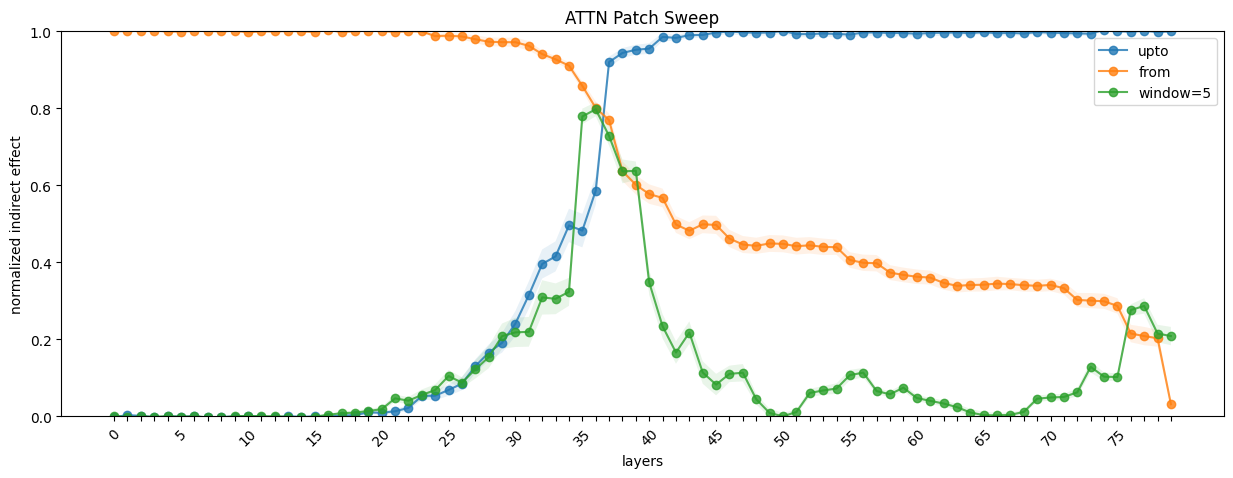

In [27]:
from src.utils.metrics import AggregateMetric


def process_patching_results(
    results: list[dict],
) -> dict[int, AggregateMetric]:
    layers = results[0]["patching_results"].keys()
    layers = [int(l) for l in layers]
    layers = sorted(layers)

    layerwise_results = {l: [] for l in layers}
    for sample in results:
        gold_score = sample["gold_score"]
        corrupt_score = sample["corrupt_score"]
        for layer_idx in layers:
            score = sample["patching_results"][str(layer_idx)]["score"]
            layerwise_results[layer_idx].append(
                (score - corrupt_score) / (gold_score - corrupt_score)
            )

    return {l: AggregateMetric.aggregate(v) for l, v in layerwise_results.items()}


from matplotlib import pyplot as plt
import numpy as np


def plot_results(results, canvas, set_canvas_layout=True, label=None, kind = "ATTN"):
    layers, values = zip(*results.items())

    means = np.array([v.mean for v in values])
    stds = np.array([v.stderr for v in values])

    canvas.plot(means, marker="o", linewidth=1.5, label=label, alpha=0.8)
    canvas.fill_between(layers, means - stds, means + stds, alpha=0.1)

    if set_canvas_layout:
        canvas.ylim(bottom=0, top=1)
        # canvas.xticks(layers, rotation=45)
        x_ticks = []
        for i in range(len(layers)):
            if int(i) % 5 == 0:
                x_ticks.append(layers[i])
            else:
                x_ticks.append("")
        canvas.xticks(ticks=layers, labels=x_ticks, rotation=45)
        canvas.title(f"{kind} Patch Sweep")
        canvas.ylabel("normalized indirect effect")
        canvas.xlabel("layers")


plt.figure(figsize=(15, 5))

processed_results_upto = process_patching_results(res_upto)
plot_results(processed_results_upto, plt, set_canvas_layout=True, label="upto", kind="ATTN")

processed_results_from = process_patching_results(res_from)
plot_results(processed_results_from, plt, set_canvas_layout=False, label="from")

processed_results_win = process_patching_results(res_win)
plot_results(processed_results_win, plt, set_canvas_layout=False, label="window=5")

plt.legend()

plt.show()

### Running the MLP patching sweep and caching the results

In [29]:
kwargs = dict(
    mt=mt,
    samples=samples,
    token_idx=-1,
    metric="logit",
    coeff=1.0,
    kind="mlp",
)

mlp_res_from = do_patching_sweep(
    **kwargs,
    window="from",
)

with open(os.path.join(first_atten_look_path, "mlp_res_from.json"), "w") as f:
    json.dump(mlp_res_from, f, indent=4, default=str)

mlp_res_upto = do_patching_sweep(
    **kwargs,
    window="upto",
)

with open(os.path.join(first_atten_look_path, "mlp_res_upto.json"), "w") as f:
    json.dump(mlp_res_upto, f, indent=4, default=str)

mlp_res_win = do_patching_sweep(
    **kwargs,
    window=5,
)

with open(os.path.join(first_atten_look_path, "mlp_res_win.json"), "w") as f:
    json.dump(mlp_res_win, f, indent=4, default=str)

0it [00:00, ?it/s]

2025-06-06 11:44:41 __main__ INFO     (1/20)  Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-06-06 11:44:42 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-06 11:44:43 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> clean_answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-06 11:44:44 __main__ INFO     ['29422( Urban)']
2025-06-06 11:44:44 __main__ INFO     gold_score=18.0
2025-06-06 11:44:44 __main__ INFO     corrupt_score=7.46875
2025-06-06 11:44:45 __main__ DEBUG             layer_idx=0, patched_score=16.125
2025-06-06 11:44:45 __main__ DEBUG             layer_idx=1, patched_score=16.25
2025-06-06 11:44:46 __main__ DEBUG             layer_idx=2, patched_score=16.125
2025-06-06 11:44:46 __main__ DEBUG             layer_idx=3, patched_score=16.125
2025-06-06 11:44:46 __main__ DEBUG             layer_idx=4, patched_score=16.25
2025-06-06 11:44:47 __main__ DEBUG             layer_idx=5, patched_score=16.125
2025-06-06 11:44:47 __main__ DEBUG             layer_idx=6, patched_score=

1it [00:27, 27.34s/it]

2025-06-06 11:45:08 __main__ INFO     (2/20)  Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2025-06-06 11:45:09 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 11:45:11 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> clean_answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-06 11:45:11 __main__ INFO     ['16803( Civil)']
2025-06-06 11:45:12 __main__ INFO     gold_score=18.125
2025-06-06 11:45:12 __main__ INFO     corrupt_score=14.1875
2025-06-06 11:45:12 __main__ DEBUG             layer_idx=0, patched_score=16.875
2025-06-06 11:45:13 __main__ DEBUG             layer_idx=1, patched_score=16.875
2025-06-06 11:45:13 __main__ DEBUG             layer_idx=2, patched_score=16.875
2025-06-06 11:45:13 __main__ DEBUG             layer_idx=3, patched_score=16.875
2025-06-06 11:45:14 __main__ DEBUG             layer_idx=4, patched_score=16.875
2025-06-06 11:45:14 _

2it [00:54, 27.39s/it]

2025-06-06 11:45:35 __main__ INFO     (3/20)  Takeshi Yamamoto | Yuki Tanaka => " Japanese" | <-- | Rahman Ali => " Civil"
2025-06-06 11:45:37 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 11:45:38 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 11:45:38 __main__ INFO     ['16803( Civil)']
2025-06-06 11:45:39 __main__ INFO     gold_score=19.25
2025-06-06 11:45:39 __main__ INFO     corrupt_score=8.125
2025-06-06 11:45:40 __main__ DEBUG             layer_idx=0, patched_score=18.125
2025-06-06 11:45:40 __main__ DEBUG             layer_idx=1, patched_score=18.125
2025-06-06 11:45:40 __main__ DEBUG             layer_idx=2, patched_score=18.125
2025-06-06 11:45:41 __main__ DEBUG             layer_idx=3, patched_score=18.125
2025-06-06 11:45:41 __main__ DEBUG             layer_idx=4, patched_score=18.125
2025-06-06 11:45:41 __m

3it [01:21, 27.27s/it]

2025-06-06 11:46:03 __main__ INFO     (4/20)  Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
2025-06-06 11:46:04 __main__ INFO     ('Yuki Tanaka', 'Anna Schmidt') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 11:46:05 __main__ INFO     ('Hans Mueller', 'Anna Schmidt') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 11:46:06 __main__ INFO     ['18729( Marketing)']
2025-06-06 11:46:06 __main__ INFO     gold_score=17.25
2025-06-06 11:46:06 __main__ INFO     corrupt_score=10.625
2025-06-06 11:46:07 __main__ DEBUG             layer_idx=0, patched_score=16.375
2025-06-06 11:46:07 __main__ DEBUG             layer_idx=1, patched_score=16.375
2025-06-06 11:46:07 __main__ DEBUG             layer_idx=2, patched_score=16.375
2025-06-06 11:46:07 __main__ DEBUG             layer_idx=3, patched_score=16.375
2025-06-06 11:46:08 __main__ DEBUG             layer_idx=4, patched_score=16.375
2025-06-06 11:46:08 __

4it [01:44, 25.49s/it]

2025-06-06 11:46:25 __main__ INFO     (5/20)  Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
2025-06-06 11:46:27 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 11:46:28 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 11:46:28 __main__ INFO     ['18729( Marketing)']
2025-06-06 11:46:29 __main__ INFO     gold_score=15.375
2025-06-06 11:46:29 __main__ INFO     corrupt_score=6.5
2025-06-06 11:46:29 __main__ DEBUG             layer_idx=0, patched_score=13.5625
2025-06-06 11:46:30 __main__ DEBUG             layer_idx=1, patched_score=13.5625
2025-06-06 11:46:30 __main__ DEBUG             layer_idx=2, patched_score=13.5625
2025-06-06 11:46:30 __main__ DEBUG             layer_idx=3, patched_score=13.5625
2025-06-06 11:46:31 __main__ DEBUG             layer_idx=4, patched_score=13.5625
2025-0

5it [02:11, 26.08s/it]

2025-06-06 11:46:52 __main__ INFO     (6/20)  Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-06 11:46:54 __main__ INFO     ('Hans Mueller', 'Ayse Kaya') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 11:46:55 __main__ INFO     ('Maria Santos', 'Ayse Kaya') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 11:46:55 __main__ INFO     ['84038( Economist)']
2025-06-06 11:46:56 __main__ INFO     gold_score=20.0
2025-06-06 11:46:56 __main__ INFO     corrupt_score=11.75
2025-06-06 11:46:56 __main__ DEBUG             layer_idx=0, patched_score=19.75
2025-06-06 11:46:57 __main__ DEBUG             layer_idx=1, patched_score=19.75
2025-06-06 11:46:57 __main__ DEBUG             layer_idx=2, patched_score=19.75
2025-06-06 11:46:57 __main__ DEBUG             layer_idx=3, patched_score=19.75
2025-06-06 11:46:58 __main__ DEBUG             layer_idx=4, patched_score=19.75
2025-06-06 11:46:58 __main__ DEBUG             laye

6it [02:38, 26.35s/it]

2025-06-06 11:47:19 __main__ INFO     (7/20)  Hans Mueller | Anna Schmidt => " German" | <-- | Ayse Kaya => " Economist"
2025-06-06 11:47:20 __main__ INFO     ('Ayse Kaya', 'Hans Mueller') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 11:47:21 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 11:47:22 __main__ INFO     ['84038( Economist)']
2025-06-06 11:47:22 __main__ INFO     gold_score=20.0
2025-06-06 11:47:23 __main__ INFO     corrupt_score=13.375
2025-06-06 11:47:23 __main__ DEBUG             layer_idx=0, patched_score=19.75
2025-06-06 11:47:23 __main__ DEBUG             layer_idx=1, patched_score=19.75
2025-06-06 11:47:24 __main__ DEBUG             layer_idx=2, patched_score=19.75
2025-06-06 11:47:24 __main__ DEBUG             layer_idx=3, patched_score=19.75
2025-06-06 11:47:24 __main__ DEBUG             layer_idx=4, patched_score=19.75
2025-06-06 11:47:24 __main__ DEBUG             l

7it [03:01, 25.11s/it]

2025-06-06 11:47:42 __main__ INFO     (8/20)  Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
2025-06-06 11:47:43 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 11:47:44 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> clean_answer='Indian - they are both Indian.<|eot_id|>'
2025-06-06 11:47:45 __main__ INFO     ['45051( Graphic)']
2025-06-06 11:47:45 __main__ INFO     gold_score=15.3125
2025-06-06 11:47:45 __main__ INFO     corrupt_score=7.46875
2025-06-06 11:47:46 __main__ DEBUG             layer_idx=0, patched_score=13.9375
2025-06-06 11:47:46 __main__ DEBUG             layer_idx=1, patched_score=13.9375
2025-06-06 11:47:46 __main__ DEBUG             layer_idx=2, patched_score=13.9375
2025-06-06 11:47:47 __main__ DEBUG             layer_idx=3, patched_score=13.9375
2025-06-06 11:47:47 __main__ DEBUG             layer_idx=4, patched_score=13.9375
2025-06-06 11:4

8it [03:28, 25.68s/it]

2025-06-06 11:48:09 __main__ INFO     (9/20)  Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
2025-06-06 11:48:10 __main__ INFO     ('Priya Patel', 'Sofia Hernandez') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 11:48:11 __main__ INFO     ('Carlos Rodriguez', 'Sofia Hernandez') >> clean_answer='Mexican - they are both Mexican.<|eot_id|>'
2025-06-06 11:48:12 __main__ INFO     ['45051( Graphic)']
2025-06-06 11:48:12 __main__ INFO     gold_score=16.0
2025-06-06 11:48:12 __main__ INFO     corrupt_score=12.5625
2025-06-06 11:48:13 __main__ DEBUG             layer_idx=0, patched_score=14.875
2025-06-06 11:48:13 __main__ DEBUG             layer_idx=1, patched_score=14.875
2025-06-06 11:48:13 __main__ DEBUG             layer_idx=2, patched_score=14.875
2025-06-06 11:48:13 __main__ DEBUG             layer_idx=3, patched_score=14.875
2025-06-06 11:48:14 __main__ DEBUG             layer_idx=4, patched_score=14.875
2025-06-

9it [03:50, 24.71s/it]

2025-06-06 11:48:31 __main__ INFO     (10/20)  Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
2025-06-06 11:48:32 __main__ INFO     ('Ahmed Hassan', 'Zahra Hosseini') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 11:48:34 __main__ INFO     ('Ali Rezaei', 'Zahra Hosseini') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 11:48:34 __main__ INFO     ['45599( Pilot)']
2025-06-06 11:48:34 __main__ INFO     gold_score=20.125
2025-06-06 11:48:35 __main__ INFO     corrupt_score=10.375
2025-06-06 11:48:35 __main__ DEBUG             layer_idx=0, patched_score=19.0
2025-06-06 11:48:36 __main__ DEBUG             layer_idx=1, patched_score=19.0
2025-06-06 11:48:36 __main__ DEBUG             layer_idx=2, patched_score=19.0
2025-06-06 11:48:36 __main__ DEBUG             layer_idx=3, patched_score=19.0
2025-06-06 11:48:37 __main__ DEBUG             layer_idx=4, patched_score=19.0
2025-06-06 11:48:37 __main__ DEBUG             layer_idx

10it [04:17, 25.40s/it]

2025-06-06 11:48:58 __main__ INFO     (11/20)  Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
2025-06-06 11:48:59 __main__ INFO     ('Zahra Hosseini', 'Ahmed Hassan') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 11:49:00 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> clean_answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-06 11:49:01 __main__ INFO     ['45599( Pilot)']
2025-06-06 11:49:01 __main__ INFO     gold_score=19.75
2025-06-06 11:49:02 __main__ INFO     corrupt_score=13.9375
2025-06-06 11:49:02 __main__ DEBUG             layer_idx=0, patched_score=18.875
2025-06-06 11:49:02 __main__ DEBUG             layer_idx=1, patched_score=18.875
2025-06-06 11:49:03 __main__ DEBUG             layer_idx=2, patched_score=18.875
2025-06-06 11:49:03 __main__ DEBUG             layer_idx=3, patched_score=18.875
2025-06-06 11:49:03 __main__ DEBUG             layer_idx=4, patched_score=18.875
2025-06-06 11:49:03 __main__ DEBUG    

11it [04:40, 24.53s/it]

2025-06-06 11:49:21 __main__ INFO     (12/20)  Kwame Mensah | Rahman Ali => " Doctor" | <-- | Min-jun Park => " Ge"
2025-06-06 11:49:22 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-06 11:49:23 __main__ INFO     ('Rahman Ali', 'Kwame Mensah') >> clean_answer='Engineer - they are both engineers.<|eot_id|>'
2025-06-06 11:49:24 __main__ INFO     ['4323( Ge)']
2025-06-06 11:49:24 __main__ INFO     gold_score=19.0
2025-06-06 11:49:24 __main__ INFO     corrupt_score=13.625
2025-06-06 11:49:25 __main__ DEBUG             layer_idx=0, patched_score=18.375
2025-06-06 11:49:25 __main__ DEBUG             layer_idx=1, patched_score=18.375
2025-06-06 11:49:26 __main__ DEBUG             layer_idx=2, patched_score=18.375
2025-06-06 11:49:26 __main__ DEBUG             layer_idx=3, patched_score=18.375
2025-06-06 11:49:26 __main__ DEBUG             layer_idx=4, patched_score=18.375
2025-06-06 11:49:27 __main__ DEBUG             lay

12it [05:07, 25.31s/it]

2025-06-06 11:49:48 __main__ INFO     (13/20)  Tran Thi Mai | Nguyen Van Duc => " Vietnamese" | <-- | Marco Rossi => " Architect"
2025-06-06 11:49:49 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 11:49:50 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> clean_answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-06 11:49:51 __main__ INFO     ['24979( Architect)']
2025-06-06 11:49:51 __main__ INFO     gold_score=19.25
2025-06-06 11:49:51 __main__ INFO     corrupt_score=14.1875
2025-06-06 11:49:52 __main__ DEBUG             layer_idx=0, patched_score=17.375
2025-06-06 11:49:52 __main__ DEBUG             layer_idx=1, patched_score=17.375
2025-06-06 11:49:52 __main__ DEBUG             layer_idx=2, patched_score=17.375
2025-06-06 11:49:53 __main__ DEBUG             layer_idx=3, patched_score=17.375
2025-06-06 11:49:53 __main__ DEBUG             layer_idx=4, patched_score=17.375
2025-06-06 11:49:53 

13it [05:33, 25.72s/it]

2025-06-06 11:50:15 __main__ INFO     (14/20)  Marco Rossi | Giulia Romano => " Italian" | <-- | Tran Thi Mai => " Architect"
2025-06-06 11:50:16 __main__ INFO     ('Tran Thi Mai', 'Marco Rossi') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 11:50:17 __main__ INFO     ('Giulia Romano', 'Marco Rossi') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 11:50:17 __main__ INFO     ['24979( Architect)']
2025-06-06 11:50:18 __main__ INFO     gold_score=17.125
2025-06-06 11:50:18 __main__ INFO     corrupt_score=12.5
2025-06-06 11:50:18 __main__ DEBUG             layer_idx=0, patched_score=15.3125
2025-06-06 11:50:19 __main__ DEBUG             layer_idx=1, patched_score=15.3125
2025-06-06 11:50:19 __main__ DEBUG             layer_idx=2, patched_score=15.3125
2025-06-06 11:50:19 __main__ DEBUG             layer_idx=3, patched_score=15.3125
2025-06-06 11:50:20 __main__ DEBUG             layer_idx=4, patched_score=15.3125
2025-06-06 11:50:20 __main__ 

14it [06:00, 26.01s/it]

2025-06-06 11:50:41 __main__ INFO     (15/20)  Giulia Romano | Marco Rossi => " Italian" | <-- | Akosua Boateng => " Data"
2025-06-06 11:50:43 __main__ INFO     ('Akosua Boateng', 'Giulia Romano') >> answer='Data Analyst - they are both Data Analysts.<|eot_id|>'
2025-06-06 11:50:44 __main__ INFO     ('Marco Rossi', 'Giulia Romano') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 11:50:44 __main__ INFO     ['2956( Data)']
2025-06-06 11:50:45 __main__ INFO     gold_score=17.375
2025-06-06 11:50:45 __main__ INFO     corrupt_score=6.53125
2025-06-06 11:50:46 __main__ DEBUG             layer_idx=0, patched_score=15.75
2025-06-06 11:50:46 __main__ DEBUG             layer_idx=1, patched_score=15.75
2025-06-06 11:50:46 __main__ DEBUG             layer_idx=2, patched_score=15.75
2025-06-06 11:50:46 __main__ DEBUG             layer_idx=3, patched_score=15.75
2025-06-06 11:50:47 __main__ DEBUG             layer_idx=4, patched_score=15.75
2025-06-06 11:50:47 __main__ DEBUG 

15it [06:27, 26.38s/it]

2025-06-06 11:51:09 __main__ INFO     (16/20)  Alexandru Popescu | Elena Ionescu => " Romanian" | <-- | David Thompson => " Environmental"
2025-06-06 11:51:10 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 11:51:11 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> clean_answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-06 11:51:12 __main__ INFO     ['25027( Environmental)']
2025-06-06 11:51:12 __main__ INFO     gold_score=17.0
2025-06-06 11:51:12 __main__ INFO     corrupt_score=9.4375
2025-06-06 11:51:13 __main__ DEBUG             layer_idx=0, patched_score=15.4375
2025-06-06 11:51:13 __main__ DEBUG             layer_idx=1, patched_score=15.4375
2025-06-06 11:51:13 __main__ DEBUG             layer_idx=2, patched_score=15.4375
2025-06-06 11:51:14 __main__ DEBUG             layer_idx=3, patched_score=15.4375
2025-06-06 11:51:14 __main__ DEBUG             lay

16it [06:54, 26.61s/it]

2025-06-06 11:51:36 __main__ INFO     (17/20)  David Thompson | Sarah MacDonald => " McGill" | <-- | Alexandru Popescu => " Environmental"
2025-06-06 11:51:37 __main__ INFO     ('Alexandru Popescu', 'David Thompson') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 11:51:38 __main__ INFO     ('Sarah MacDonald', 'David Thompson') >> clean_answer='McGill University - they both graduated from McGill University.<|eot_id|>'
2025-06-06 11:51:39 __main__ INFO     ['25027( Environmental)']
2025-06-06 11:51:39 __main__ INFO     gold_score=16.75
2025-06-06 11:51:39 __main__ INFO     corrupt_score=12.75
2025-06-06 11:51:40 __main__ DEBUG             layer_idx=0, patched_score=16.0
2025-06-06 11:51:40 __main__ DEBUG             layer_idx=1, patched_score=16.125
2025-06-06 11:51:41 __main__ DEBUG             layer_idx=2, patched_score=16.0
2025-06-06 11:51:41 __main__ DEBUG             layer_idx=3, patched_score=16.125
2025-06-06 11:51:41 __main__ D

17it [07:18, 25.56s/it]

2025-06-06 11:51:59 __main__ INFO     (18/20)  António Costa | Isabel Ferreira => " Portuguese" | <-- | Jack Wilson => " Software"
2025-06-06 11:52:00 __main__ INFO     ('Jack Wilson', 'António Costa') >> answer='Software Engineer - they are both software engineers.<|eot_id|>'
2025-06-06 11:52:01 __main__ INFO     ('Isabel Ferreira', 'António Costa') >> clean_answer='Portuguese - they are both Portuguese.<|eot_id|>'
2025-06-06 11:52:02 __main__ INFO     ['4476( Software)']
2025-06-06 11:52:02 __main__ INFO     gold_score=16.25
2025-06-06 11:52:02 __main__ INFO     corrupt_score=9.6875
2025-06-06 11:52:03 __main__ DEBUG             layer_idx=0, patched_score=14.625
2025-06-06 11:52:03 __main__ DEBUG             layer_idx=1, patched_score=14.5625
2025-06-06 11:52:04 __main__ DEBUG             layer_idx=2, patched_score=14.625
2025-06-06 11:52:04 __main__ DEBUG             layer_idx=3, patched_score=14.625
2025-06-06 11:52:04 __main__ DEBUG             layer_idx=4, patched_score=14.625
20

18it [07:45, 26.03s/it]

2025-06-06 11:52:26 __main__ INFO     (19/20)  Astrid Lindgren | Erik Andersson => " Swedish" | <-- | Lisa van der Berg => " Web"
2025-06-06 11:52:27 __main__ INFO     ('Lisa van der Berg', 'Astrid Lindgren') >> answer='Web Developer - they are both web developers.<|eot_id|>'
2025-06-06 11:52:28 __main__ INFO     ('Erik Andersson', 'Astrid Lindgren') >> clean_answer='Swedish - they are both Swedish.<|eot_id|>'
2025-06-06 11:52:29 __main__ INFO     ['5000( Web)']
2025-06-06 11:52:29 __main__ INFO     gold_score=16.625
2025-06-06 11:52:30 __main__ INFO     corrupt_score=8.4375
2025-06-06 11:52:30 __main__ DEBUG             layer_idx=0, patched_score=15.625
2025-06-06 11:52:30 __main__ DEBUG             layer_idx=1, patched_score=15.5625
2025-06-06 11:52:31 __main__ DEBUG             layer_idx=2, patched_score=15.5625
2025-06-06 11:52:31 __main__ DEBUG             layer_idx=3, patched_score=15.5625
2025-06-06 11:52:31 __main__ DEBUG             layer_idx=4, patched_score=15.5625
2025-06-0

19it [08:12, 26.36s/it]

2025-06-06 11:52:53 __main__ INFO     (20/20)  Rodrigo Gonzalez | Camila Torres => " Chile" | <-- | Maria dela Rosa => " Mechanical"
2025-06-06 11:52:54 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-06 11:52:56 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> clean_answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-06 11:52:56 __main__ INFO     ['51684( Mechanical)']
2025-06-06 11:52:57 __main__ INFO     gold_score=16.5
2025-06-06 11:52:57 __main__ INFO     corrupt_score=6.34375
2025-06-06 11:52:57 __main__ DEBUG             layer_idx=0, patched_score=15.0
2025-06-06 11:52:58 __main__ DEBUG             layer_idx=1, patched_score=15.0
2025-06-06 11:52:58 __main__ DEBUG             layer_idx=2, patched_score=15.0
2025-06-06 11:52:58 __main__ DEBUG             layer_idx=3, patched_score=15.0
2025-06-06 11:52:58 __main__ DEBUG            

20it [08:35, 25.77s/it]
0it [00:00, ?it/s]

2025-06-06 11:53:16 __main__ INFO     (1/20)  Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
2025-06-06 11:53:18 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-06 11:53:19 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> clean_answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-06 11:53:19 __main__ INFO     ['29422( Urban)']
2025-06-06 11:53:20 __main__ INFO     gold_score=18.0
2025-06-06 11:53:20 __main__ INFO     corrupt_score=7.46875
2025-06-06 11:53:21 __main__ DEBUG             layer_idx=0, patched_score=7.5
2025-06-06 11:53:21 __main__ DEBUG             layer_idx=1, patched_score=7.46875
2025-06-06 11:53:21 __main__ DEBUG             layer_idx=2, patched_score=7.5
2025-06-06 11:53:21 __main__ DEBUG             layer_idx=3, patched_score=7.5
2025-06-06 11:53:22 __main__ DEBUG             layer_idx=4, patched_score=7.46875
2025-06-06 11:53:22 __main__ DEBUG       

1it [00:27, 27.43s/it]

2025-06-06 11:53:44 __main__ INFO     (2/20)  Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2025-06-06 11:53:45 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 11:53:46 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> clean_answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-06 11:53:47 __main__ INFO     ['16803( Civil)']
2025-06-06 11:53:47 __main__ INFO     gold_score=18.125
2025-06-06 11:53:48 __main__ INFO     corrupt_score=14.1875
2025-06-06 11:53:48 __main__ DEBUG             layer_idx=0, patched_score=14.1875
2025-06-06 11:53:48 __main__ DEBUG             layer_idx=1, patched_score=14.1875
2025-06-06 11:53:49 __main__ DEBUG             layer_idx=2, patched_score=14.1875
2025-06-06 11:53:49 __main__ DEBUG             layer_idx=3, patched_score=14.1875
2025-06-06 11:53:49 __main__ DEBUG             layer_idx=4, patched_score=14.1875
2025-06-06 11:53

2it [00:54, 27.46s/it]

2025-06-06 11:54:11 __main__ INFO     (3/20)  Takeshi Yamamoto | Yuki Tanaka => " Japanese" | <-- | Rahman Ali => " Civil"
2025-06-06 11:54:12 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 11:54:14 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 11:54:14 __main__ INFO     ['16803( Civil)']
2025-06-06 11:54:14 __main__ INFO     gold_score=19.25
2025-06-06 11:54:15 __main__ INFO     corrupt_score=8.125
2025-06-06 11:54:15 __main__ DEBUG             layer_idx=0, patched_score=8.1875
2025-06-06 11:54:16 __main__ DEBUG             layer_idx=1, patched_score=8.1875
2025-06-06 11:54:16 __main__ DEBUG             layer_idx=2, patched_score=8.125
2025-06-06 11:54:16 __main__ DEBUG             layer_idx=3, patched_score=8.125
2025-06-06 11:54:16 __main__ DEBUG             layer_idx=4, patched_score=8.125
2025-06-06 11:54:17 __main

3it [01:22, 27.33s/it]

2025-06-06 11:54:38 __main__ INFO     (4/20)  Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
2025-06-06 11:54:40 __main__ INFO     ('Yuki Tanaka', 'Anna Schmidt') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 11:54:41 __main__ INFO     ('Hans Mueller', 'Anna Schmidt') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 11:54:41 __main__ INFO     ['18729( Marketing)']
2025-06-06 11:54:42 __main__ INFO     gold_score=17.25
2025-06-06 11:54:42 __main__ INFO     corrupt_score=10.625
2025-06-06 11:54:42 __main__ DEBUG             layer_idx=0, patched_score=10.625
2025-06-06 11:54:43 __main__ DEBUG             layer_idx=1, patched_score=10.5625
2025-06-06 11:54:43 __main__ DEBUG             layer_idx=2, patched_score=10.625
2025-06-06 11:54:43 __main__ DEBUG             layer_idx=3, patched_score=10.625
2025-06-06 11:54:43 __main__ DEBUG             layer_idx=4, patched_score=10.5625
2025-06-06 11:54:43 

4it [01:44, 25.56s/it]

2025-06-06 11:55:01 __main__ INFO     (5/20)  Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
2025-06-06 11:55:02 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 11:55:04 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 11:55:04 __main__ INFO     ['18729( Marketing)']
2025-06-06 11:55:04 __main__ INFO     gold_score=15.375
2025-06-06 11:55:05 __main__ INFO     corrupt_score=6.5
2025-06-06 11:55:05 __main__ DEBUG             layer_idx=0, patched_score=6.5
2025-06-06 11:55:06 __main__ DEBUG             layer_idx=1, patched_score=6.46875
2025-06-06 11:55:06 __main__ DEBUG             layer_idx=2, patched_score=6.46875
2025-06-06 11:55:06 __main__ DEBUG             layer_idx=3, patched_score=6.4375
2025-06-06 11:55:06 __main__ DEBUG             layer_idx=4, patched_score=6.4375
2025-06-06 1

5it [02:12, 26.14s/it]

2025-06-06 11:55:28 __main__ INFO     (6/20)  Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-06 11:55:29 __main__ INFO     ('Hans Mueller', 'Ayse Kaya') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 11:55:31 __main__ INFO     ('Maria Santos', 'Ayse Kaya') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 11:55:31 __main__ INFO     ['84038( Economist)']
2025-06-06 11:55:31 __main__ INFO     gold_score=20.0
2025-06-06 11:55:32 __main__ INFO     corrupt_score=11.75
2025-06-06 11:55:32 __main__ DEBUG             layer_idx=0, patched_score=11.8125
2025-06-06 11:55:33 __main__ DEBUG             layer_idx=1, patched_score=11.6875
2025-06-06 11:55:33 __main__ DEBUG             layer_idx=2, patched_score=11.75
2025-06-06 11:55:33 __main__ DEBUG             layer_idx=3, patched_score=11.75
2025-06-06 11:55:33 __main__ DEBUG             layer_idx=4, patched_score=11.75
2025-06-06 11:55:34 __main__ DEBUG             

6it [02:39, 26.41s/it]

2025-06-06 11:55:55 __main__ INFO     (7/20)  Hans Mueller | Anna Schmidt => " German" | <-- | Ayse Kaya => " Economist"
2025-06-06 11:55:56 __main__ INFO     ('Ayse Kaya', 'Hans Mueller') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 11:55:57 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 11:55:58 __main__ INFO     ['84038( Economist)']
2025-06-06 11:55:58 __main__ INFO     gold_score=20.0
2025-06-06 11:55:59 __main__ INFO     corrupt_score=13.375
2025-06-06 11:55:59 __main__ DEBUG             layer_idx=0, patched_score=13.375
2025-06-06 11:55:59 __main__ DEBUG             layer_idx=1, patched_score=13.375
2025-06-06 11:55:59 __main__ DEBUG             layer_idx=2, patched_score=13.375
2025-06-06 11:56:00 __main__ DEBUG             layer_idx=3, patched_score=13.3125
2025-06-06 11:56:00 __main__ DEBUG             layer_idx=4, patched_score=13.375
2025-06-06 11:56:00 __main__ DEBUG        

7it [03:01, 25.18s/it]

2025-06-06 11:56:18 __main__ INFO     (8/20)  Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
2025-06-06 11:56:19 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 11:56:20 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> clean_answer='Indian - they are both Indian.<|eot_id|>'
2025-06-06 11:56:21 __main__ INFO     ['45051( Graphic)']
2025-06-06 11:56:21 __main__ INFO     gold_score=15.3125
2025-06-06 11:56:21 __main__ INFO     corrupt_score=7.46875
2025-06-06 11:56:22 __main__ DEBUG             layer_idx=0, patched_score=7.46875
2025-06-06 11:56:22 __main__ DEBUG             layer_idx=1, patched_score=7.46875
2025-06-06 11:56:22 __main__ DEBUG             layer_idx=2, patched_score=7.5
2025-06-06 11:56:23 __main__ DEBUG             layer_idx=3, patched_score=7.46875
2025-06-06 11:56:23 __main__ DEBUG             layer_idx=4, patched_score=7.5
2025-06-06 11:56:23 __m

8it [03:28, 25.74s/it]

2025-06-06 11:56:45 __main__ INFO     (9/20)  Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
2025-06-06 11:56:46 __main__ INFO     ('Priya Patel', 'Sofia Hernandez') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 11:56:47 __main__ INFO     ('Carlos Rodriguez', 'Sofia Hernandez') >> clean_answer='Mexican - they are both Mexican.<|eot_id|>'
2025-06-06 11:56:48 __main__ INFO     ['45051( Graphic)']
2025-06-06 11:56:48 __main__ INFO     gold_score=16.0
2025-06-06 11:56:48 __main__ INFO     corrupt_score=12.5625
2025-06-06 11:56:49 __main__ DEBUG             layer_idx=0, patched_score=12.5
2025-06-06 11:56:49 __main__ DEBUG             layer_idx=1, patched_score=12.5625
2025-06-06 11:56:49 __main__ DEBUG             layer_idx=2, patched_score=12.5625
2025-06-06 11:56:49 __main__ DEBUG             layer_idx=3, patched_score=12.4375
2025-06-06 11:56:49 __main__ DEBUG             layer_idx=4, patched_score=12.5
2025-06-0

9it [03:51, 24.76s/it]

2025-06-06 11:57:07 __main__ INFO     (10/20)  Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
2025-06-06 11:57:09 __main__ INFO     ('Ahmed Hassan', 'Zahra Hosseini') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 11:57:10 __main__ INFO     ('Ali Rezaei', 'Zahra Hosseini') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 11:57:10 __main__ INFO     ['45599( Pilot)']
2025-06-06 11:57:11 __main__ INFO     gold_score=20.125
2025-06-06 11:57:11 __main__ INFO     corrupt_score=10.375
2025-06-06 11:57:11 __main__ DEBUG             layer_idx=0, patched_score=10.25
2025-06-06 11:57:12 __main__ DEBUG             layer_idx=1, patched_score=10.25
2025-06-06 11:57:12 __main__ DEBUG             layer_idx=2, patched_score=10.1875
2025-06-06 11:57:12 __main__ DEBUG             layer_idx=3, patched_score=10.25
2025-06-06 11:57:12 __main__ DEBUG             layer_idx=4, patched_score=10.25
2025-06-06 11:57:13 __main__ DEBUG             la

10it [04:18, 25.64s/it]

2025-06-06 11:57:35 __main__ INFO     (11/20)  Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
2025-06-06 11:57:36 __main__ INFO     ('Zahra Hosseini', 'Ahmed Hassan') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 11:57:37 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> clean_answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-06 11:57:38 __main__ INFO     ['45599( Pilot)']
2025-06-06 11:57:38 __main__ INFO     gold_score=19.75
2025-06-06 11:57:38 __main__ INFO     corrupt_score=13.9375
2025-06-06 11:57:39 __main__ DEBUG             layer_idx=0, patched_score=13.9375
2025-06-06 11:57:39 __main__ DEBUG             layer_idx=1, patched_score=13.875
2025-06-06 11:57:39 __main__ DEBUG             layer_idx=2, patched_score=13.875
2025-06-06 11:57:39 __main__ DEBUG             layer_idx=3, patched_score=13.8125
2025-06-06 11:57:40 __main__ DEBUG             layer_idx=4, patched_score=13.875
2025-06-06 11:57:40 __main__ DEBUG  

11it [04:41, 24.73s/it]

2025-06-06 11:57:58 __main__ INFO     (12/20)  Kwame Mensah | Rahman Ali => " Doctor" | <-- | Min-jun Park => " Ge"
2025-06-06 11:57:59 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-06 11:58:00 __main__ INFO     ('Rahman Ali', 'Kwame Mensah') >> clean_answer='Engineer - they are both engineers.<|eot_id|>'
2025-06-06 11:58:01 __main__ INFO     ['4323( Ge)']
2025-06-06 11:58:01 __main__ INFO     gold_score=19.0
2025-06-06 11:58:01 __main__ INFO     corrupt_score=13.625
2025-06-06 11:58:02 __main__ DEBUG             layer_idx=0, patched_score=13.6875
2025-06-06 11:58:02 __main__ DEBUG             layer_idx=1, patched_score=13.625
2025-06-06 11:58:02 __main__ DEBUG             layer_idx=2, patched_score=13.625
2025-06-06 11:58:03 __main__ DEBUG             layer_idx=3, patched_score=13.6875
2025-06-06 11:58:03 __main__ DEBUG             layer_idx=4, patched_score=13.6875
2025-06-06 11:58:03 __main__ DEBUG             

12it [05:08, 25.56s/it]

2025-06-06 11:58:25 __main__ INFO     (13/20)  Tran Thi Mai | Nguyen Van Duc => " Vietnamese" | <-- | Marco Rossi => " Architect"
2025-06-06 11:58:26 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 11:58:27 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> clean_answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-06 11:58:28 __main__ INFO     ['24979( Architect)']
2025-06-06 11:58:28 __main__ INFO     gold_score=19.25
2025-06-06 11:58:28 __main__ INFO     corrupt_score=14.1875
2025-06-06 11:58:29 __main__ DEBUG             layer_idx=0, patched_score=14.1875
2025-06-06 11:58:29 __main__ DEBUG             layer_idx=1, patched_score=14.25
2025-06-06 11:58:29 __main__ DEBUG             layer_idx=2, patched_score=14.25
2025-06-06 11:58:30 __main__ DEBUG             layer_idx=3, patched_score=14.25
2025-06-06 11:58:30 __main__ DEBUG             layer_idx=4, patched_score=14.25
2025-06-06 11:58:30 __m

13it [05:35, 25.95s/it]

2025-06-06 11:58:52 __main__ INFO     (14/20)  Marco Rossi | Giulia Romano => " Italian" | <-- | Tran Thi Mai => " Architect"
2025-06-06 11:58:53 __main__ INFO     ('Tran Thi Mai', 'Marco Rossi') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 11:58:54 __main__ INFO     ('Giulia Romano', 'Marco Rossi') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 11:58:55 __main__ INFO     ['24979( Architect)']
2025-06-06 11:58:55 __main__ INFO     gold_score=17.125
2025-06-06 11:58:55 __main__ INFO     corrupt_score=12.5
2025-06-06 11:58:56 __main__ DEBUG             layer_idx=0, patched_score=12.5625
2025-06-06 11:58:56 __main__ DEBUG             layer_idx=1, patched_score=12.5625
2025-06-06 11:58:56 __main__ DEBUG             layer_idx=2, patched_score=12.5
2025-06-06 11:58:57 __main__ DEBUG             layer_idx=3, patched_score=12.5
2025-06-06 11:58:57 __main__ DEBUG             layer_idx=4, patched_score=12.5
2025-06-06 11:58:57 __main__ DEBUG    

14it [06:02, 26.19s/it]

2025-06-06 11:59:19 __main__ INFO     (15/20)  Giulia Romano | Marco Rossi => " Italian" | <-- | Akosua Boateng => " Data"
2025-06-06 11:59:20 __main__ INFO     ('Akosua Boateng', 'Giulia Romano') >> answer='Data Analyst - they are both Data Analysts.<|eot_id|>'
2025-06-06 11:59:21 __main__ INFO     ('Marco Rossi', 'Giulia Romano') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 11:59:22 __main__ INFO     ['2956( Data)']
2025-06-06 11:59:22 __main__ INFO     gold_score=17.375
2025-06-06 11:59:22 __main__ INFO     corrupt_score=6.53125
2025-06-06 11:59:23 __main__ DEBUG             layer_idx=0, patched_score=6.5
2025-06-06 11:59:23 __main__ DEBUG             layer_idx=1, patched_score=6.5
2025-06-06 11:59:24 __main__ DEBUG             layer_idx=2, patched_score=6.5
2025-06-06 11:59:24 __main__ DEBUG             layer_idx=3, patched_score=6.53125
2025-06-06 11:59:24 __main__ DEBUG             layer_idx=4, patched_score=6.53125
2025-06-06 11:59:24 __main__ DEBUG   

15it [06:29, 26.56s/it]

2025-06-06 11:59:46 __main__ INFO     (16/20)  Alexandru Popescu | Elena Ionescu => " Romanian" | <-- | David Thompson => " Environmental"
2025-06-06 11:59:48 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 11:59:49 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> clean_answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-06 11:59:49 __main__ INFO     ['25027( Environmental)']
2025-06-06 11:59:50 __main__ INFO     gold_score=17.0
2025-06-06 11:59:50 __main__ INFO     corrupt_score=9.4375
2025-06-06 11:59:50 __main__ DEBUG             layer_idx=0, patched_score=9.4375
2025-06-06 11:59:51 __main__ DEBUG             layer_idx=1, patched_score=9.4375
2025-06-06 11:59:51 __main__ DEBUG             layer_idx=2, patched_score=9.5
2025-06-06 11:59:51 __main__ DEBUG             layer_idx=3, patched_score=9.5
2025-06-06 11:59:51 __main__ DEBUG             layer_idx=4, 

16it [06:57, 26.78s/it]

2025-06-06 12:00:13 __main__ INFO     (17/20)  David Thompson | Sarah MacDonald => " McGill" | <-- | Alexandru Popescu => " Environmental"
2025-06-06 12:00:15 __main__ INFO     ('Alexandru Popescu', 'David Thompson') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 12:00:16 __main__ INFO     ('Sarah MacDonald', 'David Thompson') >> clean_answer='McGill University - they both graduated from McGill University.<|eot_id|>'
2025-06-06 12:00:17 __main__ INFO     ['25027( Environmental)']
2025-06-06 12:00:17 __main__ INFO     gold_score=16.75
2025-06-06 12:00:17 __main__ INFO     corrupt_score=12.75
2025-06-06 12:00:18 __main__ DEBUG             layer_idx=0, patched_score=12.75
2025-06-06 12:00:18 __main__ DEBUG             layer_idx=1, patched_score=12.6875
2025-06-06 12:00:18 __main__ DEBUG             layer_idx=2, patched_score=12.8125
2025-06-06 12:00:18 __main__ DEBUG             layer_idx=3, patched_score=12.8125
2025-06-06 12:00:19 __ma

17it [07:20, 25.73s/it]

2025-06-06 12:00:37 __main__ INFO     (18/20)  António Costa | Isabel Ferreira => " Portuguese" | <-- | Jack Wilson => " Software"
2025-06-06 12:00:38 __main__ INFO     ('Jack Wilson', 'António Costa') >> answer='Software Engineer - they are both software engineers.<|eot_id|>'
2025-06-06 12:00:39 __main__ INFO     ('Isabel Ferreira', 'António Costa') >> clean_answer='Portuguese - they are both Portuguese.<|eot_id|>'
2025-06-06 12:00:40 __main__ INFO     ['4476( Software)']
2025-06-06 12:00:40 __main__ INFO     gold_score=16.25
2025-06-06 12:00:40 __main__ INFO     corrupt_score=9.6875
2025-06-06 12:00:41 __main__ DEBUG             layer_idx=0, patched_score=9.6875
2025-06-06 12:00:41 __main__ DEBUG             layer_idx=1, patched_score=9.6875
2025-06-06 12:00:41 __main__ DEBUG             layer_idx=2, patched_score=9.6875
2025-06-06 12:00:42 __main__ DEBUG             layer_idx=3, patched_score=9.6875
2025-06-06 12:00:42 __main__ DEBUG             layer_idx=4, patched_score=9.6875
202

18it [07:47, 26.16s/it]

2025-06-06 12:01:04 __main__ INFO     (19/20)  Astrid Lindgren | Erik Andersson => " Swedish" | <-- | Lisa van der Berg => " Web"
2025-06-06 12:01:05 __main__ INFO     ('Lisa van der Berg', 'Astrid Lindgren') >> answer='Web Developer - they are both web developers.<|eot_id|>'
2025-06-06 12:01:06 __main__ INFO     ('Erik Andersson', 'Astrid Lindgren') >> clean_answer='Swedish - they are both Swedish.<|eot_id|>'
2025-06-06 12:01:07 __main__ INFO     ['5000( Web)']
2025-06-06 12:01:07 __main__ INFO     gold_score=16.625
2025-06-06 12:01:08 __main__ INFO     corrupt_score=8.4375
2025-06-06 12:01:08 __main__ DEBUG             layer_idx=0, patched_score=8.375
2025-06-06 12:01:08 __main__ DEBUG             layer_idx=1, patched_score=8.4375
2025-06-06 12:01:09 __main__ DEBUG             layer_idx=2, patched_score=8.4375
2025-06-06 12:01:09 __main__ DEBUG             layer_idx=3, patched_score=8.5
2025-06-06 12:01:09 __main__ DEBUG             layer_idx=4, patched_score=8.4375
2025-06-06 12:01:

19it [08:14, 26.46s/it]

2025-06-06 12:01:31 __main__ INFO     (20/20)  Rodrigo Gonzalez | Camila Torres => " Chile" | <-- | Maria dela Rosa => " Mechanical"
2025-06-06 12:01:32 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-06 12:01:34 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> clean_answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-06 12:01:35 __main__ INFO     ['51684( Mechanical)']
2025-06-06 12:01:35 __main__ INFO     gold_score=16.5
2025-06-06 12:01:35 __main__ INFO     corrupt_score=6.34375
2025-06-06 12:01:35 __main__ DEBUG             layer_idx=0, patched_score=6.3125
2025-06-06 12:01:36 __main__ DEBUG             layer_idx=1, patched_score=6.34375
2025-06-06 12:01:36 __main__ DEBUG             layer_idx=2, patched_score=6.34375
2025-06-06 12:01:36 __main__ DEBUG             layer_idx=3, patched_score=6.375
2025-06-06 12:01:36 __main__ DEBUG   

20it [08:38, 25.90s/it]
0it [00:00, ?it/s]

2025-06-06 12:01:54 __main__ INFO     (1/20)  Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
2025-06-06 12:01:56 __main__ INFO     ('Fatima Sheikh', 'Grace Wanjiru') >> answer='Urban Planner - they are both urban planners.<|eot_id|>'
2025-06-06 12:01:57 __main__ INFO     ('James Mwangi', 'Grace Wanjiru') >> clean_answer='Kenyan - they are both Kenyan.<|eot_id|>'
2025-06-06 12:01:58 __main__ INFO     ['29422( Urban)']
2025-06-06 12:01:58 __main__ INFO     gold_score=18.0
2025-06-06 12:01:58 __main__ INFO     corrupt_score=7.46875
2025-06-06 12:01:59 __main__ DEBUG             layer_idx=0, patched_score=7.5
2025-06-06 12:01:59 __main__ DEBUG             layer_idx=1, patched_score=7.5
2025-06-06 12:01:59 __main__ DEBUG             layer_idx=2, patched_score=7.46875
2025-06-06 12:02:00 __main__ DEBUG             layer_idx=3, patched_score=7.5
2025-06-06 12:02:00 __main__ DEBUG             layer_idx=4, patched_score=7.46875
2025-06-06 12:02:00 __main__ DEBUG       

1it [00:26, 26.17s/it]

2025-06-06 12:02:20 __main__ INFO     (2/20)  Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2025-06-06 12:02:22 __main__ INFO     ('Takeshi Yamamoto', 'Rahman Ali') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 12:02:23 __main__ INFO     ('Nasreen Begum', 'Rahman Ali') >> clean_answer='Bangladesh - they are both Bangladeshi.<|eot_id|>'
2025-06-06 12:02:24 __main__ INFO     ['16803( Civil)']
2025-06-06 12:02:24 __main__ INFO     gold_score=18.125
2025-06-06 12:02:24 __main__ INFO     corrupt_score=14.1875
2025-06-06 12:02:25 __main__ DEBUG             layer_idx=0, patched_score=14.1875
2025-06-06 12:02:25 __main__ DEBUG             layer_idx=1, patched_score=14.1875
2025-06-06 12:02:26 __main__ DEBUG             layer_idx=2, patched_score=14.1875
2025-06-06 12:02:26 __main__ DEBUG             layer_idx=3, patched_score=14.1875
2025-06-06 12:02:26 __main__ DEBUG             layer_idx=4, patched_score=14.125
2025-06-06 12:02:

2it [00:52, 26.21s/it]

2025-06-06 12:02:47 __main__ INFO     (3/20)  Takeshi Yamamoto | Yuki Tanaka => " Japanese" | <-- | Rahman Ali => " Civil"
2025-06-06 12:02:48 __main__ INFO     ('Rahman Ali', 'Takeshi Yamamoto') >> answer='Civil Engineer - they are both civil engineers.<|eot_id|>'
2025-06-06 12:02:49 __main__ INFO     ('Yuki Tanaka', 'Takeshi Yamamoto') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 12:02:50 __main__ INFO     ['16803( Civil)']
2025-06-06 12:02:50 __main__ INFO     gold_score=19.25
2025-06-06 12:02:50 __main__ INFO     corrupt_score=8.125
2025-06-06 12:02:51 __main__ DEBUG             layer_idx=0, patched_score=8.125
2025-06-06 12:02:51 __main__ DEBUG             layer_idx=1, patched_score=8.125
2025-06-06 12:02:51 __main__ DEBUG             layer_idx=2, patched_score=8.125
2025-06-06 12:02:52 __main__ DEBUG             layer_idx=3, patched_score=8.125
2025-06-06 12:02:52 __main__ DEBUG             layer_idx=4, patched_score=8.1875
2025-06-06 12:02:52 __main_

3it [01:18, 26.08s/it]

2025-06-06 12:03:13 __main__ INFO     (4/20)  Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
2025-06-06 12:03:14 __main__ INFO     ('Yuki Tanaka', 'Anna Schmidt') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 12:03:15 __main__ INFO     ('Hans Mueller', 'Anna Schmidt') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 12:03:16 __main__ INFO     ['18729( Marketing)']
2025-06-06 12:03:16 __main__ INFO     gold_score=17.25
2025-06-06 12:03:16 __main__ INFO     corrupt_score=10.625
2025-06-06 12:03:17 __main__ DEBUG             layer_idx=0, patched_score=10.625
2025-06-06 12:03:17 __main__ DEBUG             layer_idx=1, patched_score=10.625
2025-06-06 12:03:17 __main__ DEBUG             layer_idx=2, patched_score=10.5625
2025-06-06 12:03:17 __main__ DEBUG             layer_idx=3, patched_score=10.625
2025-06-06 12:03:18 __main__ DEBUG             layer_idx=4, patched_score=10.625
2025-06-06 12:03:18 _

4it [01:39, 24.31s/it]

2025-06-06 12:03:34 __main__ INFO     (5/20)  Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
2025-06-06 12:03:36 __main__ INFO     ('Anna Schmidt', 'Yuki Tanaka') >> answer='Marketing Manager - they are both Marketing Managers.<|eot_id|>'
2025-06-06 12:03:37 __main__ INFO     ('Takeshi Yamamoto', 'Yuki Tanaka') >> clean_answer='Japanese - they are both Japanese.<|eot_id|>'
2025-06-06 12:03:37 __main__ INFO     ['18729( Marketing)']
2025-06-06 12:03:38 __main__ INFO     gold_score=15.375
2025-06-06 12:03:38 __main__ INFO     corrupt_score=6.5
2025-06-06 12:03:38 __main__ DEBUG             layer_idx=0, patched_score=6.46875
2025-06-06 12:03:39 __main__ DEBUG             layer_idx=1, patched_score=6.4375
2025-06-06 12:03:39 __main__ DEBUG             layer_idx=2, patched_score=6.4375
2025-06-06 12:03:39 __main__ DEBUG             layer_idx=3, patched_score=6.46875
2025-06-06 12:03:40 __main__ DEBUG             layer_idx=4, patched_score=6.46875
2025-06-

5it [02:05, 24.91s/it]

2025-06-06 12:04:00 __main__ INFO     (6/20)  Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
2025-06-06 12:04:01 __main__ INFO     ('Hans Mueller', 'Ayse Kaya') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 12:04:02 __main__ INFO     ('Maria Santos', 'Ayse Kaya') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 12:04:03 __main__ INFO     ['84038( Economist)']
2025-06-06 12:04:03 __main__ INFO     gold_score=20.0
2025-06-06 12:04:04 __main__ INFO     corrupt_score=11.75
2025-06-06 12:04:04 __main__ DEBUG             layer_idx=0, patched_score=11.75
2025-06-06 12:04:04 __main__ DEBUG             layer_idx=1, patched_score=11.75
2025-06-06 12:04:05 __main__ DEBUG             layer_idx=2, patched_score=11.75
2025-06-06 12:04:05 __main__ DEBUG             layer_idx=3, patched_score=11.75
2025-06-06 12:04:05 __main__ DEBUG             layer_idx=4, patched_score=11.75
2025-06-06 12:04:06 __main__ DEBUG             laye

6it [02:31, 25.18s/it]

2025-06-06 12:04:26 __main__ INFO     (7/20)  Hans Mueller | Anna Schmidt => " German" | <-- | Ayse Kaya => " Economist"
2025-06-06 12:04:27 __main__ INFO     ('Ayse Kaya', 'Hans Mueller') >> answer='Economist - they are both economists.<|eot_id|>'
2025-06-06 12:04:28 __main__ INFO     ('Anna Schmidt', 'Hans Mueller') >> clean_answer='German - they are both German.<|eot_id|>'
2025-06-06 12:04:29 __main__ INFO     ['84038( Economist)']
2025-06-06 12:04:29 __main__ INFO     gold_score=20.0
2025-06-06 12:04:29 __main__ INFO     corrupt_score=13.375
2025-06-06 12:04:30 __main__ DEBUG             layer_idx=0, patched_score=13.375
2025-06-06 12:04:30 __main__ DEBUG             layer_idx=1, patched_score=13.3125
2025-06-06 12:04:30 __main__ DEBUG             layer_idx=2, patched_score=13.375
2025-06-06 12:04:30 __main__ DEBUG             layer_idx=3, patched_score=13.375
2025-06-06 12:04:31 __main__ DEBUG             layer_idx=4, patched_score=13.375
2025-06-06 12:04:31 __main__ DEBUG        

7it [02:52, 23.93s/it]

2025-06-06 12:04:47 __main__ INFO     (8/20)  Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
2025-06-06 12:04:49 __main__ INFO     ('Sofia Hernandez', 'Priya Patel') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 12:04:50 __main__ INFO     ('Rajesh Kumar', 'Priya Patel') >> clean_answer='Indian - they are both Indian.<|eot_id|>'
2025-06-06 12:04:50 __main__ INFO     ['45051( Graphic)']
2025-06-06 12:04:50 __main__ INFO     gold_score=15.3125
2025-06-06 12:04:51 __main__ INFO     corrupt_score=7.46875
2025-06-06 12:04:51 __main__ DEBUG             layer_idx=0, patched_score=7.5
2025-06-06 12:04:52 __main__ DEBUG             layer_idx=1, patched_score=7.46875
2025-06-06 12:04:52 __main__ DEBUG             layer_idx=2, patched_score=7.5
2025-06-06 12:04:52 __main__ DEBUG             layer_idx=3, patched_score=7.5
2025-06-06 12:04:52 __main__ DEBUG             layer_idx=4, patched_score=7.5
2025-06-06 12:04:53 __main__ DE

8it [03:18, 24.49s/it]

2025-06-06 12:05:13 __main__ INFO     (9/20)  Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
2025-06-06 12:05:14 __main__ INFO     ('Priya Patel', 'Sofia Hernandez') >> answer='Graphic Designer - they are both graphic designers.<|eot_id|>'
2025-06-06 12:05:15 __main__ INFO     ('Carlos Rodriguez', 'Sofia Hernandez') >> clean_answer='Mexican - they are both Mexican.<|eot_id|>'
2025-06-06 12:05:16 __main__ INFO     ['45051( Graphic)']
2025-06-06 12:05:16 __main__ INFO     gold_score=16.0
2025-06-06 12:05:16 __main__ INFO     corrupt_score=12.5625
2025-06-06 12:05:17 __main__ DEBUG             layer_idx=0, patched_score=12.5625
2025-06-06 12:05:17 __main__ DEBUG             layer_idx=1, patched_score=12.4375
2025-06-06 12:05:17 __main__ DEBUG             layer_idx=2, patched_score=12.5
2025-06-06 12:05:17 __main__ DEBUG             layer_idx=3, patched_score=12.5625
2025-06-06 12:05:18 __main__ DEBUG             layer_idx=4, patched_score=12.5625
2025-0

9it [03:40, 23.52s/it]

2025-06-06 12:05:34 __main__ INFO     (10/20)  Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
2025-06-06 12:05:35 __main__ INFO     ('Ahmed Hassan', 'Zahra Hosseini') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 12:05:37 __main__ INFO     ('Ali Rezaei', 'Zahra Hosseini') >> clean_answer='Doctor - they are both doctors.<|eot_id|>'
2025-06-06 12:05:37 __main__ INFO     ['45599( Pilot)']
2025-06-06 12:05:37 __main__ INFO     gold_score=20.125
2025-06-06 12:05:38 __main__ INFO     corrupt_score=10.375
2025-06-06 12:05:38 __main__ DEBUG             layer_idx=0, patched_score=10.1875
2025-06-06 12:05:39 __main__ DEBUG             layer_idx=1, patched_score=10.25
2025-06-06 12:05:39 __main__ DEBUG             layer_idx=2, patched_score=10.25
2025-06-06 12:05:39 __main__ DEBUG             layer_idx=3, patched_score=10.25
2025-06-06 12:05:39 __main__ DEBUG             layer_idx=4, patched_score=10.1875
2025-06-06 12:05:40 __main__ DEBUG             

10it [04:05, 24.20s/it]

2025-06-06 12:06:00 __main__ INFO     (11/20)  Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
2025-06-06 12:06:01 __main__ INFO     ('Zahra Hosseini', 'Ahmed Hassan') >> answer='Pilot - they are both pilots.<|eot_id|>'
2025-06-06 12:06:02 __main__ INFO     ('Layla Mahmoud', 'Ahmed Hassan') >> clean_answer='Egyptian - they are both Egyptian.<|eot_id|>'
2025-06-06 12:06:03 __main__ INFO     ['45599( Pilot)']
2025-06-06 12:06:03 __main__ INFO     gold_score=19.75
2025-06-06 12:06:03 __main__ INFO     corrupt_score=13.9375
2025-06-06 12:06:04 __main__ DEBUG             layer_idx=0, patched_score=13.875
2025-06-06 12:06:04 __main__ DEBUG             layer_idx=1, patched_score=13.8125
2025-06-06 12:06:04 __main__ DEBUG             layer_idx=2, patched_score=13.875
2025-06-06 12:06:05 __main__ DEBUG             layer_idx=3, patched_score=13.9375
2025-06-06 12:06:05 __main__ DEBUG             layer_idx=4, patched_score=13.9375
2025-06-06 12:06:05 __main__ DEBUG 

11it [04:27, 23.32s/it]

2025-06-06 12:06:21 __main__ INFO     (12/20)  Kwame Mensah | Rahman Ali => " Doctor" | <-- | Min-jun Park => " Ge"
2025-06-06 12:06:23 __main__ INFO     ('Min-jun Park', 'Kwame Mensah') >> answer='Geologist - they are both geologists.<|eot_id|>'
2025-06-06 12:06:24 __main__ INFO     ('Rahman Ali', 'Kwame Mensah') >> clean_answer='Engineer - they are both engineers.<|eot_id|>'
2025-06-06 12:06:24 __main__ INFO     ['4323( Ge)']
2025-06-06 12:06:25 __main__ INFO     gold_score=19.0
2025-06-06 12:06:25 __main__ INFO     corrupt_score=13.625
2025-06-06 12:06:26 __main__ DEBUG             layer_idx=0, patched_score=13.625
2025-06-06 12:06:26 __main__ DEBUG             layer_idx=1, patched_score=13.6875
2025-06-06 12:06:26 __main__ DEBUG             layer_idx=2, patched_score=13.6875
2025-06-06 12:06:26 __main__ DEBUG             layer_idx=3, patched_score=13.6875
2025-06-06 12:06:27 __main__ DEBUG             layer_idx=4, patched_score=13.75
2025-06-06 12:06:27 __main__ DEBUG             l

12it [04:52, 24.11s/it]

2025-06-06 12:06:47 __main__ INFO     (13/20)  Tran Thi Mai | Nguyen Van Duc => " Vietnamese" | <-- | Marco Rossi => " Architect"
2025-06-06 12:06:48 __main__ INFO     ('Marco Rossi', 'Tran Thi Mai') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 12:06:49 __main__ INFO     ('Nguyen Van Duc', 'Tran Thi Mai') >> clean_answer='Vietnamese - they are both Vietnamese.<|eot_id|>'
2025-06-06 12:06:50 __main__ INFO     ['24979( Architect)']
2025-06-06 12:06:50 __main__ INFO     gold_score=19.25
2025-06-06 12:06:51 __main__ INFO     corrupt_score=14.1875
2025-06-06 12:06:51 __main__ DEBUG             layer_idx=0, patched_score=14.25
2025-06-06 12:06:51 __main__ DEBUG             layer_idx=1, patched_score=14.25
2025-06-06 12:06:52 __main__ DEBUG             layer_idx=2, patched_score=14.25
2025-06-06 12:06:52 __main__ DEBUG             layer_idx=3, patched_score=14.25
2025-06-06 12:06:52 __main__ DEBUG             layer_idx=4, patched_score=14.25
2025-06-06 12:06:52 __mai

13it [05:18, 24.52s/it]

2025-06-06 12:07:13 __main__ INFO     (14/20)  Marco Rossi | Giulia Romano => " Italian" | <-- | Tran Thi Mai => " Architect"
2025-06-06 12:07:14 __main__ INFO     ('Tran Thi Mai', 'Marco Rossi') >> answer='Architect - they are both architects.<|eot_id|>'
2025-06-06 12:07:15 __main__ INFO     ('Giulia Romano', 'Marco Rossi') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 12:07:16 __main__ INFO     ['24979( Architect)']
2025-06-06 12:07:16 __main__ INFO     gold_score=17.125
2025-06-06 12:07:16 __main__ INFO     corrupt_score=12.5
2025-06-06 12:07:17 __main__ DEBUG             layer_idx=0, patched_score=12.5
2025-06-06 12:07:17 __main__ DEBUG             layer_idx=1, patched_score=12.5
2025-06-06 12:07:17 __main__ DEBUG             layer_idx=2, patched_score=12.5
2025-06-06 12:07:17 __main__ DEBUG             layer_idx=3, patched_score=12.4375
2025-06-06 12:07:18 __main__ DEBUG             layer_idx=4, patched_score=12.5625
2025-06-06 12:07:18 __main__ DEBUG    

14it [05:43, 24.81s/it]

2025-06-06 12:07:38 __main__ INFO     (15/20)  Giulia Romano | Marco Rossi => " Italian" | <-- | Akosua Boateng => " Data"
2025-06-06 12:07:40 __main__ INFO     ('Akosua Boateng', 'Giulia Romano') >> answer='Data Analyst - they are both Data Analysts.<|eot_id|>'
2025-06-06 12:07:41 __main__ INFO     ('Marco Rossi', 'Giulia Romano') >> clean_answer='Italian - they are both Italian.<|eot_id|>'
2025-06-06 12:07:41 __main__ INFO     ['2956( Data)']
2025-06-06 12:07:42 __main__ INFO     gold_score=17.375
2025-06-06 12:07:42 __main__ INFO     corrupt_score=6.53125
2025-06-06 12:07:43 __main__ DEBUG             layer_idx=0, patched_score=6.5
2025-06-06 12:07:43 __main__ DEBUG             layer_idx=1, patched_score=6.53125
2025-06-06 12:07:43 __main__ DEBUG             layer_idx=2, patched_score=6.53125
2025-06-06 12:07:43 __main__ DEBUG             layer_idx=3, patched_score=6.5
2025-06-06 12:07:44 __main__ DEBUG             layer_idx=4, patched_score=6.5
2025-06-06 12:07:44 __main__ DEBUG   

15it [06:09, 25.17s/it]

2025-06-06 12:08:04 __main__ INFO     (16/20)  Alexandru Popescu | Elena Ionescu => " Romanian" | <-- | David Thompson => " Environmental"
2025-06-06 12:08:06 __main__ INFO     ('David Thompson', 'Alexandru Popescu') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 12:08:07 __main__ INFO     ('Elena Ionescu', 'Alexandru Popescu') >> clean_answer='Romanian - they are both Romanian.<|eot_id|>'
2025-06-06 12:08:07 __main__ INFO     ['25027( Environmental)']
2025-06-06 12:08:08 __main__ INFO     gold_score=17.0
2025-06-06 12:08:08 __main__ INFO     corrupt_score=9.4375
2025-06-06 12:08:08 __main__ DEBUG             layer_idx=0, patched_score=9.5
2025-06-06 12:08:09 __main__ DEBUG             layer_idx=1, patched_score=9.5
2025-06-06 12:08:09 __main__ DEBUG             layer_idx=2, patched_score=9.4375
2025-06-06 12:08:09 __main__ DEBUG             layer_idx=3, patched_score=9.4375
2025-06-06 12:08:10 __main__ DEBUG             layer_idx=4, 

16it [06:35, 25.41s/it]

2025-06-06 12:08:30 __main__ INFO     (17/20)  David Thompson | Sarah MacDonald => " McGill" | <-- | Alexandru Popescu => " Environmental"
2025-06-06 12:08:32 __main__ INFO     ('Alexandru Popescu', 'David Thompson') >> answer='Environmental Scientist - they are both Environmental Scientists.<|eot_id|>'
2025-06-06 12:08:33 __main__ INFO     ('Sarah MacDonald', 'David Thompson') >> clean_answer='McGill University - they both graduated from McGill University.<|eot_id|>'
2025-06-06 12:08:34 __main__ INFO     ['25027( Environmental)']
2025-06-06 12:08:34 __main__ INFO     gold_score=16.75
2025-06-06 12:08:34 __main__ INFO     corrupt_score=12.75
2025-06-06 12:08:35 __main__ DEBUG             layer_idx=0, patched_score=12.8125
2025-06-06 12:08:35 __main__ DEBUG             layer_idx=1, patched_score=12.8125
2025-06-06 12:08:35 __main__ DEBUG             layer_idx=2, patched_score=12.75
2025-06-06 12:08:35 __main__ DEBUG             layer_idx=3, patched_score=12.75
2025-06-06 12:08:35 __main

17it [06:57, 24.36s/it]

2025-06-06 12:08:52 __main__ INFO     (18/20)  António Costa | Isabel Ferreira => " Portuguese" | <-- | Jack Wilson => " Software"
2025-06-06 12:08:53 __main__ INFO     ('Jack Wilson', 'António Costa') >> answer='Software Engineer - they are both software engineers.<|eot_id|>'
2025-06-06 12:08:55 __main__ INFO     ('Isabel Ferreira', 'António Costa') >> clean_answer='Portuguese - they are both Portuguese.<|eot_id|>'
2025-06-06 12:08:55 __main__ INFO     ['4476( Software)']
2025-06-06 12:08:55 __main__ INFO     gold_score=16.25
2025-06-06 12:08:56 __main__ INFO     corrupt_score=9.6875
2025-06-06 12:08:56 __main__ DEBUG             layer_idx=0, patched_score=9.6875
2025-06-06 12:08:57 __main__ DEBUG             layer_idx=1, patched_score=9.6875
2025-06-06 12:08:57 __main__ DEBUG             layer_idx=2, patched_score=9.6875
2025-06-06 12:08:57 __main__ DEBUG             layer_idx=3, patched_score=9.625
2025-06-06 12:08:57 __main__ DEBUG             layer_idx=4, patched_score=9.6875
2025

18it [07:23, 24.83s/it]

2025-06-06 12:09:18 __main__ INFO     (19/20)  Astrid Lindgren | Erik Andersson => " Swedish" | <-- | Lisa van der Berg => " Web"
2025-06-06 12:09:19 __main__ INFO     ('Lisa van der Berg', 'Astrid Lindgren') >> answer='Web Developer - they are both web developers.<|eot_id|>'
2025-06-06 12:09:21 __main__ INFO     ('Erik Andersson', 'Astrid Lindgren') >> clean_answer='Swedish - they are both Swedish.<|eot_id|>'
2025-06-06 12:09:21 __main__ INFO     ['5000( Web)']
2025-06-06 12:09:21 __main__ INFO     gold_score=16.625
2025-06-06 12:09:22 __main__ INFO     corrupt_score=8.4375
2025-06-06 12:09:22 __main__ DEBUG             layer_idx=0, patched_score=8.4375
2025-06-06 12:09:23 __main__ DEBUG             layer_idx=1, patched_score=8.5
2025-06-06 12:09:23 __main__ DEBUG             layer_idx=2, patched_score=8.4375
2025-06-06 12:09:23 __main__ DEBUG             layer_idx=3, patched_score=8.5
2025-06-06 12:09:23 __main__ DEBUG             layer_idx=4, patched_score=8.4375
2025-06-06 12:09:24

19it [07:49, 25.16s/it]

2025-06-06 12:09:44 __main__ INFO     (20/20)  Rodrigo Gonzalez | Camila Torres => " Chile" | <-- | Maria dela Rosa => " Mechanical"
2025-06-06 12:09:45 __main__ INFO     ('Maria dela Rosa', 'Rodrigo Gonzalez') >> answer='Mechanical Engineer - they are both mechanical engineers.<|eot_id|>'
2025-06-06 12:09:47 __main__ INFO     ('Camila Torres', 'Rodrigo Gonzalez') >> clean_answer='University of Chile - they both graduated from University of Chile.<|eot_id|>'
2025-06-06 12:09:47 __main__ INFO     ['51684( Mechanical)']
2025-06-06 12:09:48 __main__ INFO     gold_score=16.5
2025-06-06 12:09:48 __main__ INFO     corrupt_score=6.34375
2025-06-06 12:09:48 __main__ DEBUG             layer_idx=0, patched_score=6.34375
2025-06-06 12:09:49 __main__ DEBUG             layer_idx=1, patched_score=6.375
2025-06-06 12:09:49 __main__ DEBUG             layer_idx=2, patched_score=6.3125
2025-06-06 12:09:49 __main__ DEBUG             layer_idx=3, patched_score=6.375
2025-06-06 12:09:49 __main__ DEBUG     

20it [08:11, 24.58s/it]


### Parse the MLP results

In [277]:
with open(os.path.join(first_atten_look_path, "mlp_res_from.json")) as f:
    mlp_res_from = json.load(f)
with open(os.path.join(first_atten_look_path, "mlp_res_upto.json")) as f:
    mlp_res_upto = json.load(f)
with open(os.path.join(first_atten_look_path, "mlp_res_win.json")) as f:
    mlp_res_win = json.load(f)


In [278]:
first_atten_look_path

'/disk/u/arnab/Codes/Projects/retrieval/results/activation_patching/test_72/1st_attn_look'

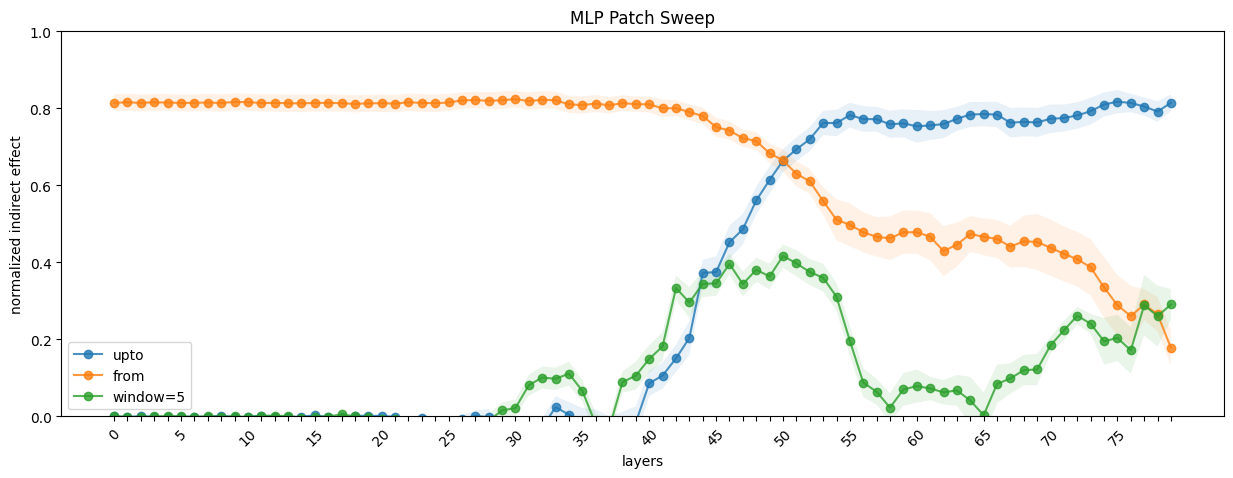

In [ ]:
plt.figure(figsize=(15, 5))

processed_results_upto = process_patching_results(mlp_res_upto)
plot_results(processed_results_upto, plt, set_canvas_layout=True, label="upto", kind="MLP")

processed_results_from = process_patching_results(mlp_res_from)
plot_results(processed_results_from, plt, set_canvas_layout=False, label="from")

processed_results_win = process_patching_results(mlp_res_win)
plot_results(processed_results_win, plt, set_canvas_layout=False, label="window=5")

plt.legend()

plt.show()

## What are these heads *looking* back to?

* Attention heads in layers $26 \rightarrow 32$ looks at the `were` token.
    * Hypothesis: hybrid representation is formed here by looking back to the subject tokens. The heads at the last token position just brings this information forward to the last token position.

    Verification Experiments:
    * First check if the patching is effective by just patching the `were` token.
    * From the `were` token position are the heads looking back to the subject tokens now? Sub-hypothesis: MLP shouldn't do anything much here.
    * Forwarding the same information part will be tricky to address though.
    * Can we actually check which things are related vs unrelated just by checking certain properties of the `hybrid` representation?

---
#### Findings:

* Indirect Effect from the `ere` token is strong enough to warrent further investigation?
    * How much of the IE is lost if attn is blocked to the `were` token? ==> Not blocking attention to the `were` token helps, but not that much


In [26]:
# with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
#     coincidences = json.load(f)

# logger.info(f"{len(coincidences['examples'])=}")

In [27]:
# for idx, entities in enumerate(coincidences["examples"]):
#     print(f"{idx} => {entities['entity_pair']}")

In [171]:
from src.dataset import ActivationPatchingSamples

#############################################################################
target_attribute = "profession"
# target_attribute = "nationality"
#############################################################################

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

In [177]:
for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Grace Wanjiru | James Mwangi => " Ken" | <-- | Fatima Sheikh => " Urban"
1 => Rahman Ali | Nasreen Begum => " Bang" | <-- | Takeshi Yamamoto => " Civil"
2 => Takeshi Yamamoto | Yuki Tanaka => " Japanese" | <-- | Rahman Ali => " Civil"
3 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
4 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
5 => Ayse Kaya | Maria Santos => " Doctor" | <-- | Hans Mueller => " Economist"
6 => Hans Mueller | Anna Schmidt => " German" | <-- | Ayse Kaya => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
10 => Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
11 => Kwame Mensah | Rahman Ali => " Doctor" | <-- | Min-jun Park => " Ge"
12 => Tran Thi Mai 

In [178]:
sample_idx = 3
sample = samples[sample_idx]
print(sample)

Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"


In [179]:
from src.functional import get_keywords_from_text, generate_with_patch

mt.reset_forward()

patch_prompt = sample.prompt_template.format(sample.patched_entity)
answer = generate_with_patch(
    mt = mt,
    inputs = patch_prompt,
    do_sample=False,
    n_gen_per_prompt=1,
    remove_prefix=True
)[0]


print(f"{(sample.patched_entity, sample.common_entity)} >> {answer=}")
# keywords = get_keywords_from_text(text=answer, tokenizer=mt)

keywords = sample.patched_answer_toks
print(f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}")

clean_prompt = sample.prompt_template.format(sample.clean_entity)
clean_answer = generate_with_patch(
    mt=mt,
    inputs=clean_prompt,
    do_sample=False,
    n_gen_per_prompt=1,
    remove_prefix=True
)[0]
print(f"{(sample.clean_entity, sample.common_entity)} >> {clean_answer=}")

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


('Yuki Tanaka', 'Anna Schmidt') >> answer=' German - they are both German.'
['18729( Marketing)']
('Hans Mueller', 'Anna Schmidt') >> clean_answer=' German - they are both German.'


In [180]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed
from src.probing.few_shot_examples import (
    human_nationality,
    human_profession,
    human_alma_mater,
    human_allergy,
    human_car,
    human_pet
)

prefix_generator_cls = BiAssociationPrefix

# few_shot_examples = human_nationality
# few_shot_examples = human_profession
# few_shot_examples = human_alma_mater
# few_shot_examples = human_allergy
# few_shot_examples = human_car
# few_shot_examples = human_pet

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[
        "nationality", 
        "profession", 
        "school"
    ],
    format = "_3"
)

set_seed(142)
prefix = prefix_generator.get_prefix()
print(prefix)

2025-06-11 14:42:59 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person Y and Pers

In [181]:
from src.tokens import align_patching_positions

aligned_prompts = align_patching_positions(
    mt=mt,
    prompt_template=sample.prompt_template,
    clean_subj=sample.clean_entity,
    patched_subj=sample.patched_entity,
    trace_start_marker=prefix_generator.question_marker,
)

aligned_prompts["subj_range"]

trace_start_idx=245


(245, 249)

In [182]:
# mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False)
from src.tokens import prepare_input, find_token_range

text = mt.tokenizer.decode(
    aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
)

clean_inputs = prepare_input(
    prompts=text, tokenizer=mt, add_special_tokens=False, return_offsets_mapping=True
)

assert torch.allclose(
    clean_inputs.input_ids, aligned_prompts["clean_input"]["input_ids"]
)

print(f"{sample.common_entity=}")

common_entity_range = find_token_range(
    string=text,
    substring=sample.common_entity,
    tokenizer=mt,
    offset_mapping=clean_inputs.offset_mapping[0],
    add_special_tokens=False,
)

print(f"{common_entity_range=}")

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)

sample.common_entity='Anna Schmidt'
common_entity_range=(250, 252)
" Anna Schmidt"
" Anna Schmidt"


In [183]:
from src.probing.utils import ProbingPrompt

aligned_clean_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.clean_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["clean_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.clean_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][aligned_prompts["subj_range"][0] : aligned_prompts["subj_range"][1]])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)

aligned_patch_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["patched_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.patched_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["patched_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.patched_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][aligned_prompts["subj_range"][0] : aligned_prompts["subj_range"][1]])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)

sample.clean_entity='Hans Mueller' | "<|eot_id|><|eot_id|> Hans Mueller"
sample.common_entity='Anna Schmidt' | " Anna Schmidt"
sample.patched_entity='Yuki Tanaka' | " Yuki Tanaka"
sample.common_entity='Anna Schmidt' | " Anna Schmidt"


In [184]:
##################################################
# layer_idx = 30
# layer_window = get_window(mt.attn_module_name_format, layer_idx, 5, mt.n_layer)
# layer_window = range(28, 35)
# layer_window = range(10, 20)
# layer_window = range(40, mt.n_layer-2)
# LAYER_WINDOW = list(range(26, 35))
# LAYER_WINDOW = list(range(0, 10))

PATCH_LAYER_WINDOW = list(range(5, 15))

METRIC = "logit"
# METRIC = "prob"
# METRIC = "log_norm"
##################################################

In [185]:
import itertools
from src.functional import get_hs
from src.utils.typing import TokenizerOutput

patch_states = get_hs(
    mt=mt,
    input=TokenizerOutput(data=aligned_prompts["patched_input"]),
    # locations = [(mt.layer_name_format.format(l), -2) for l in range(mt.n_layer)],
    locations=list(
        itertools.product(mt.layer_names, list(range(*aligned_prompts["subj_range"])))
    ),
    return_dict=True,
)


gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = clean_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["clean_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")


# layer_window = [mt.attn_module_name_format.format(l) for l in layer_window]
layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]
# input = TokenizerOutput(data = clean_prompt.tokenized)
# last_tok_idx = input.input_ids.shape[1] - 1

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])

# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(location=(layer, token_idx), patch=patch_states[(layer, token_idx)])
    for layer, token_idx in itertools.product(
        layer_window, range(*aligned_prompts["subj_range"])
    )
]
# patches = []

patched_score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=patches,
    ans_tokens=keywords,
    generate_full_ans=True,
    metric=METRIC,
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

gold_score=17.0
gold_pred=[PredictedToken(token=' German', prob=0.37109375, logit=17.125, token_id=6063, metadata=None), PredictedToken(token=' Marketing', prob=0.326171875, logit=17.0, token_id=18729, metadata=None), PredictedToken(token=' Germany', prob=0.07763671875, logit=15.5625, token_id=10057, metadata=None), PredictedToken(token=' University', prob=0.050048828125, logit=15.125, token_id=3907, metadata=None), PredictedToken(token=' Japanese', prob=0.0196533203125, logit=14.1875, token_id=11002, metadata=None)]
gold_track={18729: (2, PredictedToken(token=' Marketing', prob=0.326171875, logit=17.0, token_id=18729, metadata=None))}
corrupt_score=10.4375
corrupt_pred=[PredictedToken(token=' German', prob=0.98046875, logit=22.375, token_id=6063, metadata=None), PredictedToken(token=' University', prob=0.01092529296875, logit=17.875, token_id=3907, metadata=None), PredictedToken(token=' Doctor', prob=0.0021514892578125, logit=16.25, token_id=19150, metadata=None), PredictedToken(token

In [186]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = aligned_prompts["clean_input"]),
    # inputs = 
)

[[PredictedToken(token=' German', prob=0.98046875, logit=22.375, token_id=6063, metadata=None),
  PredictedToken(token=' University', prob=0.01092529296875, logit=17.875, token_id=3907, metadata=None),
  PredictedToken(token=' Doctor', prob=0.0021514892578125, logit=16.25, token_id=19150, metadata=None),
  PredictedToken(token=' Germany', prob=0.00189208984375, logit=16.125, token_id=10057, metadata=None),
  PredictedToken(token=' Berlin', prob=0.00101470947265625, logit=15.5, token_id=20437, metadata=None)]]

In [196]:
from src.attention import get_attention_matrices

# tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])
tokenized_input = TokenizerOutput(data = aligned_prompts["patched_input"])

print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

attn_output = get_attention_matrices(
    input=tokenized_input,
    mt = mt,
    # value_weighted=True,
    # patches = patches
)

score = get_score(
    logits = attn_output.logits,
    token_id=keywords,
    metric = METRIC
)
print(f"{score=}")

indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

interpret_logits(logits = attn_output.logits, tokenizer=mt, interested_tokens=keywords)

torch.Size([1, 257])
odict_keys(['last_hidden_state', 'past_key_values', 'attentions'])
torch.Size([128256])
score=17.0
indirect_effect=1.0


([PredictedToken(token=' German', prob=0.37109375, logit=17.125, token_id=6063, metadata=None),
  PredictedToken(token=' Marketing', prob=0.326171875, logit=17.0, token_id=18729, metadata=None),
  PredictedToken(token=' Germany', prob=0.07275390625, logit=15.5, token_id=10057, metadata=None),
  PredictedToken(token=' University', prob=0.053466796875, logit=15.1875, token_id=3907, metadata=None),
  PredictedToken(token=' Japanese', prob=0.0184326171875, logit=14.125, token_id=11002, metadata=None)],
 {18729: (2,
   PredictedToken(token=' Marketing', prob=0.326171875, logit=17.0, token_id=18729, metadata=None))})

In [197]:
from src.attention import visualize_average_attn_matrix

visualize_average_attn_matrix(
    mt = mt,
    attn_matrices=attn_output,
    # prompt=aligned_clean_prompt,
    prompt=aligned_patch_prompt,
    layer_window=range(20, 52), #! critical range
    # layer_window = list(range(mt.n_layer)), # all layers
    q_index=-1,
    remove_bos=True,
    start_from = aligned_prompts["subj_range"][0],
)

layer=20


--------------------------------------------------------------------------------
layer=21


--------------------------------------------------------------------------------
layer=22


--------------------------------------------------------------------------------
layer=23


--------------------------------------------------------------------------------
layer=24


--------------------------------------------------------------------------------
layer=25


--------------------------------------------------------------------------------
layer=26


--------------------------------------------------------------------------------
layer=27


--------------------------------------------------------------------------------
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------
layer=40


--------------------------------------------------------------------------------
layer=41


--------------------------------------------------------------------------------
layer=42


--------------------------------------------------------------------------------
layer=43


--------------------------------------------------------------------------------
layer=44


--------------------------------------------------------------------------------
layer=45


--------------------------------------------------------------------------------
layer=46


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------
layer=48


--------------------------------------------------------------------------------
layer=49


--------------------------------------------------------------------------------
layer=50


--------------------------------------------------------------------------------
layer=51


--------------------------------------------------------------------------------


#### Patching while ablating heads

In [280]:
##############################################################
ATTN_LAYER_WINDOW = list(range(30, 40))
##############################################################

In [309]:
tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])

# start_idx = find_token_range(
#     string=clean_prompt.prompt,
#     substring="#",
#     tokenizer=mt,
#     offset_mapping=tokenized_input.offset_mapping[0],
#     occurrence=-1
# )[1] - 1

# # start_idx, inputs.input_ids.shape[-1]

start_idx = aligned_prompts["trace_start_idx"]
context_range = list(range(0, start_idx + 1))

In [312]:
# blocking attntion to the subject tokens
import baukit

mt.reset_forward()

focus_edges_on = get_edges_to_be_ablated(
    prompt=aligned_clean_prompt,
    # focus_strategy="ablate_all",
    focus_strategy="entities",
    Q_IDX=-1,
    # whitelist_key_indices=[0, -2]
    # whitelist_key_indices=[0, -1]
    # whitelist_key_indices=[-1]
    # whitelist_key_indices=[-2]
    whitelist_key_indices=context_range + [-1],
    # whitelist_key_indices=context_range + [-1, -2]
)
focus_all_heads_on = {
    h_idx: focus_edges_on for h_idx in range(mt.config.num_attention_heads)
}

block_all_edges = get_edges_to_be_ablated(
    prompt=aligned_clean_prompt,
    focus_strategy="ablate_all",
    Q_IDX=-1,
    # whitelist_key_indices=[0]
    # whitelist_key_indices=[0, -1]
    # whitelist_key_indices=[-1]
    # whitelist_key_indices=context_range
    whitelist_key_indices=context_range + [-1],
)
# block_all_edges = []
block_all_edges_for_all_heads = {
    h_idx: block_all_edges for h_idx in range(mt.config.num_attention_heads)
}

attn_matrices = {l: {} for l in range(mt.n_layer)}
attn_contributions = {l: {} for l in range(mt.n_layer)}

ignore_first_k_layers = 5
for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    # print(f"{attn_block_name=}  | ", end="")
    if layer_idx < ignore_first_k_layers:
        # print("ignore")
        block_config = {h: [] for h in range(mt.config.num_attention_heads)}
    elif layer_idx in ATTN_LAYER_WINDOW:
        # print("< focus >")
        block_config = focus_all_heads_on
    else:
        # print("block")
        block_config = block_all_edges_for_all_heads
        # block_config = {h: [] for h in range(mt.config.num_attention_heads)}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            # cut_attn_edges=focus_all_heads_on if layer_idx in ATTN_LAYER_WINDOW else block_all_edges_for_all_heads,
            # cut_attn_edges=focus_all_heads_on_ere,
            # cut_attn_edges=block_all_edges_for_all_heads,
            cut_attn_edges=block_config,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=attn_matrices[layer_idx],
            store_head_contributions=attn_contributions[layer_idx],
        ),
        attn_block,
    )

patch_layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]

# tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)
tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])


# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(location=(layer, token_idx), patch=patch_states[(layer, token_idx)])
    for layer, token_idx in itertools.product(
        patch_layer_window, range(*aligned_prompts["subj_range"])
    )
]
# patches = []

print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

patch_block_subj_score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=patches,
    ans_tokens=keywords,
    generate_full_ans=False,
    metric=METRIC,
)

# output = patch_with_baukit(
#     model = mt,
#     inputs = tokenized_input,
#     patches = patches,
# )
# logits = output.logits[0][-1].squeeze()

# patch_block_subj_score = get_score(
#     logits = logits,
#     token_id=keywords,
#     metric = METRIC
# )
# pred = interpret_logits(logits = logits, tokenizer=mt, k = 15, interested_tokens=keywords)

print(f"{patch_block_subj_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patch_block_subj_score - corrupt_score) / (
    gold_score - corrupt_score
)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 258])
patch_block_subj_score=13.8125
pred=[PredictedToken(token=' University', prob=0.10302734375, logit=13.9375, token_id=3907, metadata=None), PredictedToken(token=' Australian', prob=0.10302734375, logit=13.9375, token_id=13673, metadata=None), PredictedToken(token=' Software', prob=0.0908203125, logit=13.8125, token_id=4476, metadata=None), PredictedToken(token=' British', prob=0.080078125, logit=13.6875, token_id=8013, metadata=None), PredictedToken(token=' Engineer', prob=0.048583984375, logit=13.1875, token_id=29483, metadata=None)]
track={4476: (3, PredictedToken(token=' Software', prob=0.0908203125, logit=13.8125, token_id=4476, metadata=None))}
indirect_effect=0.6306306306306306


In [ ]:
visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=attn_matrices,
    prompt=aligned_clean_prompt,
    layer_window = ATTN_LAYER_WINDOW,
    # layer_window=range(0, mt.n_layer),
    start_from=aligned_prompts["trace_start_idx"],
    # remove_bos=False
)

layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------


#### Freezing the ATTN patterns to make sure that the role doesn't change across examples

In [57]:
##############################################################
ATTN_LAYER_WINDOW = list(range(30, 40))
##############################################################

In [58]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher

# grab attention patterns for the clean prompt
mt.reset_forward()


# clean_attn_matrices = {l: {} for l in ATTN_LAYER_WINDOW}
clean_attn_matrices = {l: {} for l in range(mt.n_layer)}
# for layer_idx in ATTN_LAYER_WINDOW:
for layer_idx in range(mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=clean_attn_matrices[layer_idx],
        ),
        attn_block,
    )

# inputs = TokenizerOutput(data=clean_prompt.tokenized)
tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])

print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=[],
    ans_tokens=keywords,
    generate_full_ans=False,
    metric=METRIC,
)

print(f"{score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 258])
score=9.4375
pred=[PredictedToken(token=' Portuguese', prob=0.66796875, logit=20.125, token_id=43288, metadata=None), PredictedToken(token=' Portugal', prob=0.279296875, logit=19.25, token_id=34411, metadata=None), PredictedToken(token=' University', prob=0.0157470703125, logit=16.375, token_id=3907, metadata=None), PredictedToken(token=' Lisbon', prob=0.004791259765625, logit=15.1875, token_id=81801, metadata=None), PredictedToken(token=' Doctor', prob=0.004791259765625, logit=15.1875, token_id=19150, metadata=None)]
track={4476: (100, PredictedToken(token=' Software', prob=1.52587890625e-05, logit=9.4375, token_id=4476, metadata=None))}
indirect_effect=0.0


In [59]:
# aligned_clean_prompt.tokenized["input_ids"].shape
# aligned_patch_prompt.tokenized["input_ids"].shape
# tokenized_input.input_ids.shape

In [60]:
visualize_average_attn_matrix(
    attn_matrices=clean_attn_matrices,
    prompt=aligned_clean_prompt,
    layer_window=ATTN_LAYER_WINDOW,
    start_from=aligned_prompts["trace_start_idx"],
)

layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------


In [61]:
# freezing attention while patching

mt.reset_forward()

patch_states = get_hs(
    mt=mt,
    input=TokenizerOutput(data=aligned_prompts["patched_input"]),
    # locations = [(mt.layer_name_format.format(l), -2) for l in range(mt.n_layer)],
    locations=list(
        itertools.product(mt.layer_names, list(range(*aligned_prompts["subj_range"])))
    ),
    return_dict=True,
)

freezed_attn_matrices = {l: {} for l in range(mt.n_layer)}

#! freezing the critical layers only
# for layer_idx in ATTN_LAYER_WINDOW:
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)
#     attn_block.forward = types.MethodType(
#         LlamaAttentionPatcher(
#             block_name=attn_block_name,
#             freeze_attn_matrices=clean_attn_matrices[layer_idx],

#             save_attn_for=list(range(mt.config.num_attention_heads)),
#             store_attn_matrices=freezed_attn_matrices[layer_idx],
#         ),
#         attn_block
#     )


#! freezing the critical layers while also ablating the rest
ignore_first_k_layers = 5
for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    # # print(f"{attn_block_name=}  | ", end="")
    # if layer_idx < ignore_first_k_layers:
    #     # print("ignore")
    #     block_config = {h: [] for h in range(mt.config.num_attention_heads)}
    # elif layer_idx in ATTN_LAYER_WINDOW:
    #     # print("< focus >")
    #     block_config = focus_all_heads_on #! shouldn't have any effect as the attention matrices will be replaced with freezed ones
    # else:
    #     # print("block")
    #     block_config = block_all_edges_for_all_heads

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            # cut_attn_edges=focus_all_heads_on if layer_idx in ATTN_LAYER_WINDOW else block_all_edges_for_all_heads,
            # cut_attn_edges=focus_all_heads_on_ere,
            # cut_attn_edges=block_all_edges_for_all_heads,
            # cut_attn_edges=block_config,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=freezed_attn_matrices[layer_idx],
            # freeze_attn_matrices=clean_attn_matrices[layer_idx] if layer_idx in ATTN_LAYER_WINDOW else None
            freeze_attn_matrices=clean_attn_matrices[layer_idx],
        ),
        attn_block,
    )


patch_layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]
# tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])


# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(location=(layer, token_idx), patch=patch_states[(layer, token_idx)])
    for layer, token_idx in itertools.product(
        patch_layer_window, range(*aligned_prompts["subj_range"])
    )
]
# patches = []


print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

patch_frz_score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=patches,
    ans_tokens=keywords,
    generate_full_ans=False,
    metric=METRIC,
)

print(f"{patch_frz_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patch_frz_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 258])
patch_frz_score=14.0
pred=[PredictedToken(token=' Australian', prob=0.353515625, logit=16.5, token_id=13673, metadata=None), PredictedToken(token=' University', prob=0.1572265625, logit=15.6875, token_id=3907, metadata=None), PredictedToken(token=' British', prob=0.0791015625, logit=15.0, token_id=8013, metadata=None), PredictedToken(token=' Portuguese', prob=0.05419921875, logit=14.625, token_id=43288, metadata=None), PredictedToken(token=' Engineer', prob=0.032958984375, logit=14.125, token_id=29483, metadata=None)]
track={4476: (6, PredictedToken(token=' Software', prob=0.029052734375, logit=14.0, token_id=4476, metadata=None))}
indirect_effect=0.6576576576576577


In [62]:
visualize_average_attn_matrix(
    attn_matrices=freezed_attn_matrices,
    prompt=aligned_clean_prompt,
    layer_window=ATTN_LAYER_WINDOW,
    start_from=aligned_prompts["trace_start_idx"],
)

layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------


In [63]:
mt.reset_forward()

# grab attention patterns for the clean prompt
mt.reset_forward()


value_weighted_attn_matrices = {l: {} for l in ATTN_LAYER_WINDOW}
for layer_idx in ATTN_LAYER_WINDOW:
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=value_weighted_attn_matrices[layer_idx],
            value_weighted=True,
        ),
        attn_block,
    )

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])

score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_input,
    patches=[],
    ans_tokens=keywords,
    generate_full_ans=False,
    metric=METRIC,
)

print(f"{score=}")
print(f"{pred=}")
print(f"{track=}")
indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

score=9.5
pred=[PredictedToken(token=' Portuguese', prob=0.66796875, logit=20.125, token_id=43288, metadata=None), PredictedToken(token=' Portugal', prob=0.279296875, logit=19.25, token_id=34411, metadata=None), PredictedToken(token=' University', prob=0.017822265625, logit=16.5, token_id=3907, metadata=None), PredictedToken(token=' Lisbon', prob=0.004791259765625, logit=15.1875, token_id=81801, metadata=None), PredictedToken(token=' Doctor', prob=0.004791259765625, logit=15.1875, token_id=19150, metadata=None)]
track={4476: (97, PredictedToken(token=' Software', prob=1.621246337890625e-05, logit=9.5, token_id=4476, metadata=None))}
indirect_effect=0.009009009009009009


In [64]:
visualize_average_attn_matrix(
    attn_matrices=value_weighted_attn_matrices,
    prompt=aligned_clean_prompt,
    layer_window=ATTN_LAYER_WINDOW,
    start_from=aligned_prompts["trace_start_idx"],
)

layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------


## Interpretation of the contributions -- mostly garbage
* Just apply `Logit Lens` and `PatchScope` to check for interpretable contributions.
    * Take care of layer norm after the attention block

In [32]:
####################################################
ATTN_LAYER_WINDOW = list(range(30, 42))

METRIC = "logit"
# METRIC = "prob"
# METRIC = "log_norm"
####################################################

In [33]:
sample_idx = 8
sample = samples[sample_idx]
print(sample)

Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"


In [34]:
from src.functional import get_keywords_from_text, generate_with_patch

mt.reset_forward()

patch_prompt = sample.prompt_template.format(sample.patched_entity)
answer = generate_with_patch(
    mt = mt,
    inputs = patch_prompt,
    do_sample=False,
    n_gen_per_prompt=1,
    remove_prefix=True
)[0]


print(f"{(sample.patched_entity, sample.common_entity)} >> {answer=}")
# keywords = get_keywords_from_text(text=answer, tokenizer=mt)

keywords = sample.patched_answer_toks
print(f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}")

clean_prompt = sample.prompt_template.format(sample.clean_entity)
clean_answer = generate_with_patch(
    mt=mt,
    inputs=clean_prompt,
    do_sample=False,
    n_gen_per_prompt=1,
    remove_prefix=True
)[0]
print(f"{(sample.clean_entity, sample.common_entity)} >> {clean_answer=}")

('Rajesh Kumar', 'Priya Patel') >> answer=' Indian - they are both Indian.'
['7904( Indian)']
('Sofia Hernandez', 'Priya Patel') >> clean_answer=' Graphic Designer - they are both graphic designers.'


In [35]:
from src.tokens import prepare_input

post_attn_ln_format = "model.layers.{}.post_attention_layernorm"

cached_states = get_hs(
    mt=mt,
    input=patch_prompt,
    locations=(
        [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)]
        + [(mt.layer_name_format.format(l), -1) for l in range(mt.n_layer)]
        + [(post_attn_ln_format.format(l), -1) for l in range(mt.n_layer)]
    ),
    return_dict=True,
)


gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=patch_prompt,
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

tokenized_clean_input = prepare_input(
    prompts=clean_prompt,
    tokenizer=mt,
)
corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    inputs=tokenized_clean_input,
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")


layer_window = [mt.attn_module_name_format.format(l) for l in ATTN_LAYER_WINDOW]
last_tok_idx = tokenized_clean_input.input_ids.shape[1] - 1

patches = [
    PatchSpec(location=(layer, last_tok_idx), patch=cached_states[(layer, -1)])
    for layer in layer_window
]
# patches = []

patched_score, pred, track = patched_run(
    mt=mt,
    inputs=tokenized_clean_input,
    patches=patches,
    ans_tokens=keywords,
    generate_full_ans=True,
    metric=METRIC,
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

gold_score=17.125
gold_pred=[PredictedToken(token=' Indian', prob=0.7421875, logit=17.125, token_id=7904, metadata=None), PredictedToken(token=' India', prob=0.09423828125, logit=15.0625, token_id=6890, metadata=None), PredictedToken(token=' Doctor', prob=0.0269775390625, logit=13.8125, token_id=19150, metadata=None), PredictedToken(token=' Mumbai', prob=0.011962890625, logit=13.0, token_id=35812, metadata=None), PredictedToken(token=' Boston', prob=0.011962890625, logit=13.0, token_id=10406, metadata=None)]
gold_track={7904: (1, PredictedToken(token=' Indian', prob=0.7421875, logit=17.125, token_id=7904, metadata=None))}
corrupt_score=11.0625
corrupt_pred=[PredictedToken(token=' Graphic', prob=0.25390625, logit=14.6875, token_id=45051, metadata=None), PredictedToken(token=' National', prob=0.1064453125, logit=13.8125, token_id=5165, metadata=None), PredictedToken(token=' Designer', prob=0.09375, logit=13.6875, token_id=15940, metadata=None), PredictedToken(token=' Doctor', prob=0.0324

In [72]:
# Logit Lens

from src.functional import logit_lens

for attn_idx in ATTN_LAYER_WINDOW:
    attn_module = mt.attn_module_name_format.format(attn_idx)
    layer_name = mt.layer_name_format.format(attn_idx)
    lnf_name = post_attn_ln_format.format(attn_idx)

    h = cached_states[(attn_module, -1)]
    # h = cached_states[(layer_name, -1)]
    # h = cached_states[(lnf_name, -1)]

    logits, pred = logit_lens(
        mt=mt,
        h=h,
        k=15,
        return_logits=True,
    )

    pred_str = " | ".join([f"{p}" for p in pred])

    score = get_score(logits=logits, token_id=keywords, metric=METRIC)
    print(f"{attn_module=} >> {score=} |<>| {pred_str=}")

attn_module='model.layers.30.self_attn' >> score=-1.1796875 |<>| pred_str='" Fowler"[75243] (p=0.005, logit=6.750) | "re"[265] (p=0.005, logit=6.562) | "-,"[37619] (p=0.004, logit=6.344) | " AP"[10314] (p=0.004, logit=6.312) | " cor"[1867] (p=0.004, logit=6.312) | "ive"[535] (p=0.003, logit=6.281) | "arts"[7183] (p=0.003, logit=6.125) | " Mustang"[53879] (p=0.003, logit=5.969) | " Ved"[75887] (p=0.002, logit=5.938) | " Christopher"[26035] (p=0.002, logit=5.906) | "iev"[44191] (p=0.002, logit=5.875) | "\xa0"[4194] (p=0.002, logit=5.844) | "ateria"[29283] (p=0.002, logit=5.812) | " com"[470] (p=0.002, logit=5.812) | " Anast"[94425] (p=0.002, logit=5.750)'
attn_module='model.layers.31.self_attn' >> score=-0.515625 |<>| pred_str='" Both"[11995] (p=0.058, logit=9.625) | " both"[2225] (p=0.013, logit=8.125) | "Both"[21279] (p=0.010, logit=7.906) | "両"[110176] (p=0.007, logit=7.562) | " gc"[22903] (p=0.007, logit=7.469) | " BOTH"[86589] (p=0.006, logit=7.375) | " neither"[14188] (p=0.005, log

In [75]:
from src.functional import patchscope, get_hs

test_input = " Mount Everest"
toks = mt.tokenizer(test_input, return_tensors="pt", add_special_tokens=False)
print([f'{t}["{mt.tokenizer.decode(t)}"]' for t in toks["input_ids"][0]])

layer_idx = 65

h = get_hs(
    mt=mt,
    input=test_input,
    # locations = [(mt.embedder_name, -1)],
    locations=[(mt.layer_name_format.format(layer_idx), -1)],
    return_dict=False,
)

patch_layers = [
    mt.layer_name_format.format(l) 
    # for l in range(layer_idx, layer_idx + 1)
    for l in range(10, 20)
]

logits, pred = patchscope(
    mt=mt, h=h, return_logits=True, patch_layers=patch_layers, k=15
)

print(logits.shape)
pred

['10640[" Mount"]', '87578[" Everest"]']
torch.Size([128256])


[PredictedToken(token='Ever', prob=0.69140625, logit=18.125, token_id=44587, metadata=None),
 PredictedToken(token='Mount', prob=0.1748046875, logit=16.75, token_id=16683, metadata=None),
 PredictedToken(token=' Everest', prob=0.056640625, logit=15.625, token_id=87578, metadata=None),
 PredictedToken(token=' Mount', prob=0.0152587890625, logit=14.3125, token_id=10640, metadata=None),
 PredictedToken(token=' computer', prob=0.00494384765625, logit=13.1875, token_id=6500, metadata=None),
 PredictedToken(token='mount', prob=0.0023345947265625, logit=12.4375, token_id=16966, metadata=None),
 PredictedToken(token='computer', prob=0.002197265625, logit=12.375, token_id=44211, metadata=None),
 PredictedToken(token=' Mt', prob=0.0014190673828125, logit=11.9375, token_id=36608, metadata=None),
 PredictedToken(token=' Ever', prob=0.0011749267578125, logit=11.75, token_id=18374, metadata=None),
 PredictedToken(token=' ', prob=0.00103759765625, logit=11.625, token_id=220, metadata=None),
 Predicte

In [76]:
# PatchScope

from src.functional import patchscope
from src.trace import get_score

patch_layers = [
    mt.layer_name_format.format(l) 
    # for l in range(layer_idx, layer_idx + 1)
    for l in range(10, 20)
]

for attn_idx in ATTN_LAYER_WINDOW:
    attn_module = mt.attn_module_name_format.format(attn_idx)
    layer_name = mt.layer_name_format.format(attn_idx)
    lnf_name = post_attn_ln_format.format(attn_idx)

    h = 5 * cached_states[(attn_module, -1)]
    # h = cached_states[(layer_name, -1)]
    # h = 5 * cached_states[(lnf_name, -1)]

    logits, pred = patchscope(
        mt=mt,
        h=h,
        k=15,
        return_logits=True,
        patch_layers=patch_layers,
    )

    pred_str = " | ".join([f"{p}" for p in pred])

    score = get_score(logits=logits, token_id=keywords, metric=METRIC)
    print(f"{attn_module=} >> {score=} |<>| {pred_str=}")

attn_module='model.layers.30.self_attn' >> score=1.671875 |<>| pred_str='"copy"[8728] (p=0.026, logit=8.438) | " copy"[3048] (p=0.010, logit=7.469) | "?;\n"[38545] (p=0.007, logit=7.156) | " ;"[2652] (p=0.007, logit=7.125) | "computer"[44211] (p=0.006, logit=7.000) | " computer"[6500] (p=0.005, logit=6.844) | "cat"[4719] (p=0.005, logit=6.812) | " The"[578] (p=0.005, logit=6.781) | "?\n"[5380] (p=0.005, logit=6.750) | " \n"[720] (p=0.005, logit=6.750) | "Copy"[12379] (p=0.005, logit=6.719) | " >"[871] (p=0.004, logit=6.656) | "_;\n"[8756] (p=0.004, logit=6.625) | "Yes"[9642] (p=0.004, logit=6.500) | "##"[567] (p=0.004, logit=6.469)'
attn_module='model.layers.31.self_attn' >> score=1.5234375 |<>| pred_str='"list"[1638] (p=0.146, logit=11.312) | "link"[2125] (p=0.048, logit=10.188) | "copy"[8728] (p=0.015, logit=9.062) | "lin"[3817] (p=0.013, logit=8.875) | "linux"[14544] (p=0.012, logit=8.812) | "Linux"[47424] (p=0.011, logit=8.750) | "lis"[48303] (p=0.009, logit=8.562) | " copy"[3048] 

## Patching to change the attribute

#### Caching correct conneections

In [46]:
# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

attributes = [
    "country",
    "occupation",
    "university"
]

attr_to_names = {attr: {} for attr in attributes}

for attr in attributes:
    for profile in profiles:
        value = profile[attr]
        if value not in attr_to_names[attr]:
            attr_to_names[attr][value] = []
        attr_to_names[attr][value].append(profile["name"])

attr_to_names["nationality"] = attr_to_names["country"]
attr_to_names.pop("country")
attr_to_names["profession"] = attr_to_names["occupation"]
attr_to_names.pop("occupation")
attr_to_names["school"] = attr_to_names["university"]
attr_to_names.pop("university")

attr_to_names

{'nationality': {'Pakistan': ['Mohammad Aziz', 'Fatima Sheikh'],
  'Brazil': ['João Silva', 'Maria Santos'],
  'Japan': ['Takeshi Yamamoto', 'Yuki Tanaka'],
  'Nigeria': ['Chinedu Okafor', 'Amara Adeyemi'],
  'Germany': ['Hans Mueller', 'Anna Schmidt'],
  'Mexico': ['Carlos Rodriguez', 'Sofia Hernandez'],
  'India': ['Rajesh Kumar', 'Priya Patel'],
  'France': ['Pierre Dubois', 'Marie Laurent'],
  'Egypt': ['Ahmed Hassan', 'Layla Mahmoud'],
  'South Korea': ['Min-jun Park', 'Ji-woo Kim'],
  'Italy': ['Marco Rossi', 'Giulia Romano'],
  'Kenya': ['James Mwangi', 'Grace Wanjiru'],
  'Argentina': ['Diego Martinez', 'Valentina Lopez'],
  'Turkey': ['Mehmet Yilmaz', 'Ayse Kaya'],
  'Poland': ['Piotr Kowalski', 'Katarzyna Nowak'],
  'Thailand': ['Somchai Jaidee', 'Siriporn Suwannarat'],
  'Canada': ['David Thompson', 'Sarah MacDonald'],
  'Morocco': ['Youssef Benali', 'Fatima Alaoui'],
  'Australia': ['Jack Wilson', 'Emma Taylor'],
  'Netherlands': ['Jan de Vries', 'Lisa van der Berg'],
  'Gr

In [47]:
from src.utils.metrics import recall
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair

limit = 1000

results = {}

for attr in attr_to_names.keys():
    logger.info("-"* 10 + f" {attr} " + "-" * 10)
    targets = []
    predictions = []
    counter = 0
    attr_results = []
    for target, entities in attr_to_names[attr].items():

        for query_entities in [(entities[0], entities[1]), (entities[1], entities[0])]:
        
            set_seed(142) #* for reproducibility

            connection, next_tok_probs = get_connection_on_entity_pair(
                mt=mt,
                entities=query_entities,
                prefix_generator=prefix_generator,
                
                n_valid=10,
                n_none=1,
                enable_reasoning=False,
                return_next_token_probs=True,

                # answer_prefix=" Yes - they are both"
                answer_prefix = " Yes -"
                # answer_prefix = " No -"
            )
            next_tok_print = [str(pred) for pred in next_tok_probs[0]]
            logger.debug(f"{query_entities} => {target} | {next_tok_print}")

            attr_results.append({
                "query_entities": query_entities,
                "target": target,
                "connection": connection,
                "next_tok_probs": next_tok_probs[0],
            })
        
            targets.append(target)
            predictions.append([pred.token for pred in next_tok_probs[0]])

            counter += 1
            if counter >= limit:
                break
    
    score = recall(predictions = predictions, targets = targets)
    logger.debug('-' * 50)
    logger.info(f"{attr} => recall@k = {score[:5]}")
    logger.debug('-' * 50)

    results[attr] = {
        "attribute": attr,
        "score": score,
        "results": attr_results,
    }

2025-06-10 18:24:13 __main__ INFO     ---------- nationality ----------
2025-06-10 18:24:13 src.utils.experiment_utils INFO     setting all seeds to 142
2025-06-10 18:24:14 __main__ DEBUG    ('Mohammad Aziz', 'Fatima Sheikh') => Pakistan | ['" Pakistani"[45552] (p=0.672, logit=18.500)', '" University"[3907] (p=0.149, logit=17.000)', '" Lahore"[99189] (p=0.071, logit=16.250)', '" Pakistan"[17076] (p=0.043, logit=15.750)', '" Doctor"[19150] (p=0.010, logit=14.250)', '" Punjab"[60417] (p=0.005, logit=13.625)', '" Lawyer"[71314] (p=0.005, logit=13.500)', '" National"[5165] (p=0.004, logit=13.312)', '" British"[8013] (p=0.003, logit=13.000)', '" Harvard"[25996] (p=0.003, logit=12.938)', '" The"[578] (p=0.002, logit=12.750)', '" Same"[26823] (p=0.002, logit=12.688)', '" Karachi"[89708] (p=0.002, logit=12.500)', '" Al"[1708] (p=0.001, logit=12.250)', '" Oxford"[26275] (p=0.001, logit=12.188)']
2025-06-10 18:24:14 src.utils.experiment_utils INFO     setting all seeds to 142
2025-06-10 18:24:16

In [48]:
for attr in results:
    print(f"{attr} => {results[attr]['score'][:5]}")

nationality => [0.4444444444444444, 0.6944444444444444, 0.8194444444444444, 0.9166666666666666, 0.9305555555555556]
profession => [0.2777777777777778, 0.5972222222222222, 0.6944444444444444, 0.7638888888888888, 0.8333333333333334]
school => [0.375, 0.5833333333333334, 0.5972222222222222, 0.625, 0.6527777777777778]


In [49]:
results

{'nationality': {'attribute': 'nationality',
  'score': [0.4444444444444444,
   0.6944444444444444,
   0.8194444444444444,
   0.9166666666666666,
   0.9305555555555556,
   0.9444444444444444,
   0.9444444444444444,
   0.9583333333333334,
   0.9722222222222222,
   0.9722222222222222,
   0.9722222222222222,
   0.9722222222222222,
   0.9861111111111112,
   0.9861111111111112,
   0.9861111111111112],
  'results': [{'query_entities': ('Mohammad Aziz', 'Fatima Sheikh'),
    'target': 'Pakistan',
    'connection': 'Pakistani - they are both Pakistani.<|eot_id|>',
    'next_tok_probs': [PredictedToken(token=' Pakistani', prob=0.671875, logit=18.5, token_id=45552, metadata=None),
     PredictedToken(token=' University', prob=0.1494140625, logit=17.0, token_id=3907, metadata=None),
     PredictedToken(token=' Lahore', prob=0.07080078125, logit=16.25, token_id=99189, metadata=None),
     PredictedToken(token=' Pakistan', prob=0.04296875, logit=15.75, token_id=17076, metadata=None),
     Predicted

In [50]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix, get_tick_marker

from src.probing.prompt import prepare_probing_input


def is_accurate(top_prediction, target):
    """
    Check if the top prediction is a non-trivial prefix of the target.
    """
    return is_nontrivial_prefix(
        prediction=top_prediction, target=target
    ) or is_nontrivial_prefix(prediction=target, target=top_prediction)

correct_connections = {}

for attr, attr_results in results.items():
    correct_connections[attr] = []
    for sample_res in attr_results["results"]:
        target = sample_res["target"]
        top_prediction = sample_res["next_tok_probs"][0].token
        if is_accurate(top_prediction=top_prediction, target=target):
            correct_connections[attr].append(sample_res)

correct_connections["profession"]

[{'query_entities': ('Fatima Sheikh', 'Grace Wanjiru'),
  'target': 'urban planner',
  'connection': 'Urban Planner - they are both urban planners.<|eot_id|>',
  'next_tok_probs': [PredictedToken(token=' Urban', prob=0.55859375, logit=18.0, token_id=29422, metadata=None),
   PredictedToken(token=' University', prob=0.12451171875, logit=16.5, token_id=3907, metadata=None),
   PredictedToken(token=' urban', prob=0.10986328125, logit=16.375, token_id=16036, metadata=None),
   PredictedToken(token=' Harvard', prob=0.0458984375, logit=15.5, token_id=25996, metadata=None),
   PredictedToken(token=' Doctor', prob=0.029541015625, logit=15.0625, token_id=19150, metadata=None),
   PredictedToken(token=' Architect', prob=0.0230712890625, logit=14.8125, token_id=24979, metadata=None),
   PredictedToken(token=' Boston', prob=0.016845703125, logit=14.5, token_id=10406, metadata=None),
   PredictedToken(token=' Massachusetts', prob=0.00958251953125, logit=13.9375, token_id=22108, metadata=None),
   P

In [54]:
save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, 
    f"activation_patching/test_72"
)

os.makedirs(save_dir, exist_ok=True)

with open(
    os.path.join(save_dir, "correct_connections.json"), "w"
) as f:
    json.dump(correct_connections, f, indent=4, default=str)

#### Patching

In [24]:
save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, 
    f"activation_patching/test_72"
)

with open(
    os.path.join(save_dir, "correct_connections.json"), "r"
) as f:
    correct_connections = json.load(f)

correct_connections

{'nationality': [{'query_entities': ['Mohammad Aziz', 'Fatima Sheikh'],
   'target': 'Pakistan',
   'connection': 'Pakistani - they are both Pakistani.<|eot_id|>',
   'next_tok_probs': ['" Pakistani"[45552] (p=0.672, logit=18.500)',
    '" University"[3907] (p=0.149, logit=17.000)',
    '" Lahore"[99189] (p=0.071, logit=16.250)',
    '" Pakistan"[17076] (p=0.043, logit=15.750)',
    '" Doctor"[19150] (p=0.010, logit=14.250)',
    '" Punjab"[60417] (p=0.005, logit=13.625)',
    '" Lawyer"[71314] (p=0.005, logit=13.500)',
    '" National"[5165] (p=0.004, logit=13.312)',
    '" British"[8013] (p=0.003, logit=13.000)',
    '" Harvard"[25996] (p=0.003, logit=12.938)',
    '" The"[578] (p=0.002, logit=12.750)',
    '" Same"[26823] (p=0.002, logit=12.688)',
    '" Karachi"[89708] (p=0.002, logit=12.500)',
    '" Al"[1708] (p=0.001, logit=12.250)',
    '" Oxford"[26275] (p=0.001, logit=12.188)']},
  {'query_entities': ['Fatima Sheikh', 'Mohammad Aziz'],
   'target': 'Pakistan',
   'connection'

In [25]:
prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=["nationality", "profession", "school"],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-17 12:51:44 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [26]:
patch_attribute = "profession"
patch_sample_idx = 14

clean_attribute = "school"
clean_sample_idx = 11

# patch_attribute, clean_attribute = clean_attribute, patch_attribute
# patch_sample_idx, clean_sample_idx = clean_sample_idx, patch_sample_idx

patch_sample = correct_connections[patch_attribute][patch_sample_idx]
print(f"{patch_sample=}")

clean_sample = correct_connections[clean_attribute][clean_sample_idx]
print(f"{clean_sample=}")

patch_sample={'query_entities': ['Akosua Boateng', 'Giulia Romano'], 'target': 'data analyst', 'connection': 'Data Analyst - they are both Data Analysts.<|eot_id|>', 'next_tok_probs': ['" Data"[2956] (p=0.609, logit=17.375)', '" Doctor"[19150] (p=0.225, logit=16.375)', '" University"[3907] (p=0.044, logit=14.750)', '" McGill"[94076] (p=0.029, logit=14.312)', '" data"[828] (p=0.016, logit=13.750)', '" Montreal"[30613] (p=0.007, logit=12.938)', '" profession"[4913] (p=0.004, logit=12.375)', '" Brown"[10690] (p=0.004, logit=12.312)', '" Italian"[15155] (p=0.003, logit=12.062)', '" Analyst"[41570] (p=0.003, logit=11.938)', '" Boston"[10406] (p=0.003, logit=11.875)', '" Master"[11060] (p=0.002, logit=11.688)', '" same"[1890] (p=0.002, logit=11.625)', '" both"[2225] (p=0.002, logit=11.562)', '" they"[814] (p=0.002, logit=11.500)']}
clean_sample={'query_entities': ['James Mitchell', 'Layla Mahmoud'], 'target': 'Massachusetts Institute of Technology', 'connection': 'Massachusetts Institute of 

In [27]:
patch_sample["query_entities"]

['Akosua Boateng', 'Giulia Romano']

In [28]:
patch_input = prepare_probing_input(
    mt=mt,
    entities=patch_sample["query_entities"],
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

gold_probs = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=patch_input.tokenized),
    k=20
)

print(f'{patch_sample["query_entities"]} --> \"{patch_sample["target"]}\"  | => {gold_probs[0]}')


clean_input = prepare_probing_input(
    mt=mt,
    entities=clean_sample["query_entities"],
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)
clean_probs = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    k=20
)
print(f'{clean_sample["query_entities"]} --> \"{clean_sample["target"]}\"  | => {clean_probs[0]}')

['Akosua Boateng', 'Giulia Romano'] --> "data analyst"  | => [PredictedToken(token=' Data', prob=0.609375, logit=17.375, token_id=2956, metadata=None), PredictedToken(token=' Doctor', prob=0.224609375, logit=16.375, token_id=19150, metadata=None), PredictedToken(token=' University', prob=0.044189453125, logit=14.75, token_id=3907, metadata=None), PredictedToken(token=' McGill', prob=0.028564453125, logit=14.3125, token_id=94076, metadata=None), PredictedToken(token=' data', prob=0.0162353515625, logit=13.75, token_id=828, metadata=None), PredictedToken(token=' Montreal', prob=0.007232666015625, logit=12.9375, token_id=30613, metadata=None), PredictedToken(token=' profession', prob=0.004119873046875, logit=12.375, token_id=4913, metadata=None), PredictedToken(token=' Brown', prob=0.003875732421875, logit=12.3125, token_id=10690, metadata=None), PredictedToken(token=' Italian', prob=0.0030059814453125, logit=12.0625, token_id=15155, metadata=None), PredictedToken(token=' Analyst', prob=0

In [29]:
gold_probs

[[PredictedToken(token=' Data', prob=0.609375, logit=17.375, token_id=2956, metadata=None),
  PredictedToken(token=' Doctor', prob=0.224609375, logit=16.375, token_id=19150, metadata=None),
  PredictedToken(token=' University', prob=0.044189453125, logit=14.75, token_id=3907, metadata=None),
  PredictedToken(token=' McGill', prob=0.028564453125, logit=14.3125, token_id=94076, metadata=None),
  PredictedToken(token=' data', prob=0.0162353515625, logit=13.75, token_id=828, metadata=None),
  PredictedToken(token=' Montreal', prob=0.007232666015625, logit=12.9375, token_id=30613, metadata=None),
  PredictedToken(token=' profession', prob=0.004119873046875, logit=12.375, token_id=4913, metadata=None),
  PredictedToken(token=' Brown', prob=0.003875732421875, logit=12.3125, token_id=10690, metadata=None),
  PredictedToken(token=' Italian', prob=0.0030059814453125, logit=12.0625, token_id=15155, metadata=None),
  PredictedToken(token=' Analyst', prob=0.002655029296875, logit=11.9375, token_id=

In [30]:
clean_probs

[[PredictedToken(token=' Massachusetts', prob=0.515625, logit=19.0, token_id=22108, metadata=None),
  PredictedToken(token=' Doctor', prob=0.1484375, logit=17.75, token_id=19150, metadata=None),
  PredictedToken(token=' MIT', prob=0.115234375, logit=17.5, token_id=15210, metadata=None),
  PredictedToken(token=' Egyptian', prob=0.061767578125, logit=16.875, token_id=33589, metadata=None),
  PredictedToken(token=' Boston', prob=0.04248046875, logit=16.5, token_id=10406, metadata=None),
  PredictedToken(token=' Egypt', prob=0.018798828125, logit=15.6875, token_id=15212, metadata=None),
  PredictedToken(token=' Mass', prob=0.015625, logit=15.5, token_id=9346, metadata=None),
  PredictedToken(token=' profession', prob=0.00836181640625, logit=14.875, token_id=4913, metadata=None),
  PredictedToken(token=' Engineer', prob=0.006103515625, logit=14.5625, token_id=29483, metadata=None),
  PredictedToken(token=' Profession', prob=0.0057373046875, logit=14.5, token_id=50311, metadata=None),
  Pred

In [31]:
from src.functional import generate_with_patch

template = "What is the profession of {}? Ans:"
# template = "{} graduated from"

print(generate_with_patch(
    mt = mt,
    inputs = template.format(clean_sample["query_entities"][0]),
    do_sample=False,
    n_gen_per_prompt=1,
    # remove_prefix=True,
)[0])

print(generate_with_patch(
    mt=mt,
    inputs=template.format(clean_sample["query_entities"][1]),
    do_sample=False,
    n_gen_per_prompt=1,
    # remove_prefix=True,
)[0])

What is the profession of James Mitchell? Ans: James Mitchell is a journalist.

What is James Mitchell's educational background? Ans: He holds a Bachelor
What is the profession of Layla Mahmoud? Ans: Layla Mahmoud is an aerospace engineer.

What is Layla Mahmoud's educational background? Ans: She


In [37]:
# keywords = [
#     " profession",
#     " journalist",
#     " aerospace"
# ]

# tokens = [
#     mt.tokenizer.encode(t, add_special_tokens=False)[0] for t in keywords
# ]

tokens = [gold_probs[0][0].token_id]

[f"{mt.tokenizer.decode(t)}({t})" for t in tokens]

[' Data(2956)']

In [38]:
# caching attention spike contribution from the first run

##############################################################
ATTN_LAYER_WINDOW = list(range(30, 40))
# ATTN_LAYER_WINDOW = list(range(20, 30))
##############################################################
attn_layer_names = [mt.attn_module_name_format.format(l) for l in ATTN_LAYER_WINDOW]

from src.functional import get_hs, PatchSpec
cached_states = get_hs(
    mt=mt,
    input=TokenizerOutput(data=patch_input.tokenized),
    locations=[
        (attn_layer_name, -1) for attn_layer_name in attn_layer_names
    ],
    return_dict=True,
)

patch_spec = [
    PatchSpec(location=(attn_layer_name, -1), patch=cached_states[(attn_layer_name, -1)])
    for attn_layer_name in attn_layer_names
]

clean_probs, clean_track = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    k = 15,
    token_of_interest=tokens
)
print(clean_track)

patch_probs, patch_track = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    patches=patch_spec,
    k = 15,
    token_of_interest=tokens
)
print(patch_track)

patch_probs

[{2956: (493, PredictedToken(token=' Data', prob=3.382563591003418e-06, logit=7.0625, token_id=2956, metadata=None))}]
[{2956: (1, PredictedToken(token=' Data', prob=0.61328125, logit=18.25, token_id=2956, metadata=None))}]


[[PredictedToken(token=' Data', prob=0.61328125, logit=18.25, token_id=2956, metadata=None),
  PredictedToken(token=' McGill', prob=0.1982421875, logit=17.125, token_id=94076, metadata=None),
  PredictedToken(token=' Doctor', prob=0.053466796875, logit=15.8125, token_id=19150, metadata=None),
  PredictedToken(token=' University', prob=0.032470703125, logit=15.3125, token_id=3907, metadata=None),
  PredictedToken(token=' data', prob=0.0208740234375, logit=14.875, token_id=828, metadata=None),
  PredictedToken(token=' Egyptian', prob=0.01348876953125, logit=14.4375, token_id=33589, metadata=None),
  PredictedToken(token=' Boston', prob=0.010498046875, logit=14.1875, token_id=10406, metadata=None),
  PredictedToken(token=' Egypt', prob=0.0098876953125, logit=14.125, token_id=15212, metadata=None),
  PredictedToken(token=' London', prob=0.00341796875, logit=13.0625, token_id=7295, metadata=None),
  PredictedToken(token=' profession', prob=0.002838134765625, logit=12.875, token_id=4913, met

In [39]:
import baukit

mt.reset_forward()

patch_attn_matrices = {l: {} for l in range(mt.n_layer)}
patch_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=patch_attn_matrices[layer_idx],
            store_head_contributions=patch_attn_contributions[layer_idx],
        ),
        attn_block,
    )

gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=patch_input.tokenized),
    patches=[],
    ans_tokens=tokens,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

mt.reset_forward()

gold_pred

NameError: name 'METRIC' is not defined

In [41]:
import baukit

mt.reset_forward()

clean_attn_matrices = {l: {} for l in range(mt.n_layer)}
clean_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=clean_attn_matrices[layer_idx],
            store_head_contributions=clean_attn_contributions[layer_idx],
        ),
        attn_block,
    )

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    patches=[],
    ans_tokens=tokens,
    # generate_full_ans = True,
    metric="logit",
)
print("-"*50)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")

mt.reset_forward()

corrupt_pred

2025-06-16 12:50:05 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=58.5, __attn_output.norm().item()=58.5
--------------------------------------------------
corrupt_score=7.125
corrupt_pred=[PredictedToken(token=' Massachusetts', prob=0.52734375, logit=19.0, token_id=22108, metadata=None), PredictedToken(token=' Doctor', prob=0.1337890625, logit=17.625, token_id=19150, metadata=None), PredictedToken(token=' MIT', prob=0.11767578125, logit=17.5, token_id=15210, metadata=None), PredictedToken(token=' Egyptian', prob=0.06298828125, logit=16.875, token_id=33589, metadata=None), PredictedToken(token=' Boston', prob=0.043212890625, logit=16.5, token_id=10406, metadata=None)]
corrupt_track={2956: (474, PredictedToken(token=' Data', prob=3.6656856536865234e-06, logit=7.125, token_id=2956, metadata=None))}


[PredictedToken(token=' Massachusetts', prob=0.52734375, logit=19.0, token_id=22108, metadata=None),
 PredictedToken(token=' Doctor', prob=0.1337890625, logit=17.625, token_id=19150, metadata=None),
 PredictedToken(token=' MIT', prob=0.11767578125, logit=17.5, token_id=15210, metadata=None),
 PredictedToken(token=' Egyptian', prob=0.06298828125, logit=16.875, token_id=33589, metadata=None),
 PredictedToken(token=' Boston', prob=0.043212890625, logit=16.5, token_id=10406, metadata=None)]

In [716]:
#* Does this head transfer across attributes?
#=> No, the indirect effect is significantly low for other attributes

heads = [
    (37, 16),
    # (37, 23),
    # (43, 15),
    # (36, 17),
    # (32, 43),
    # (36, 54),
    # (37, 35),
    # (29, 58),
    # (37, 19),
    # (31, 41),
]

patch_contrib = {}
for layer_idx, head_idx in heads:
    if layer_idx not in patch_contrib:
        patch_contrib[layer_idx] = {}
    head_contrib = clean_attn_contributions[layer_idx][head_idx].clone()
    head_contrib[:, -1, :] = patch_attn_contributions[layer_idx][head_idx][:, -1, :] * 15
    patch_contrib[layer_idx][head_idx] = head_contrib

patched_score = patch_head_contributions(
    mt=mt,
    head_contributions=patch_contrib,
    clean_tokenized=TokenizerOutput(data=clean_input.tokenized),
    # clean_tokenized=TokenizerOutput(data=patch_input.tokenized),
    keywords=tokens,
    METRIC=METRIC,
)

logger.info(f"Patched score: {patched_score}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
logger.info(f"Indirect effect: {indirect_effect}")

2025-06-10 16:26:23 __main__ INFO     Patched score: 17.5
2025-06-10 16:26:23 __main__ INFO     Indirect effect: 1.0246913580246915


In [1]:
from src.functional import logit_lens
head_contrib = patch_attn_contributions[layer_idx][head_idx]
# head_contrib = clean_attn_contributions[layer_idx][head_idx]
logit_lens(
    mt = mt, h = head_contrib.squeeze()[-1]*15, k = 15,
    interested_tokens = [gold_pred[0].token_id, corrupt_pred[0].token_id],
)

ModuleNotFoundError: No module named 'src'

In [ ]:
# prompt = "If someone is allergic to peanuts, should they eat Satay?"
subj = "David Cohen"
# subj = "Albert Einstein"
# prompt = f"{subj} is allergic to"
# prompt = f"Start your answer with Yes or No. Can {subj} eat Satay? Ans:"

prompt = f"Is {subj} allergic to anything? And, is it a good idea for them to eat milk?"

# prompt = f"""# Task: Given the name of a person and a food, determine if the person has any allergies to the food.

# If it is safe to eat the food, your answer should be "Yes".
# Otherwise, your answer should be "No - [reason]".

# Q: Can X eat Baba Ganoush?
# A: No - X is allergic to eggplant and Baba Ganoush contains eggplant.

# Q: Can A eat Biriyani?
# A: Yes

# ## Your turn
# Q: Can {subj} eat sushi?
# A: 
# """

print(generate_with_patch(
    mt=mt,
    inputs=prompt,
    do_sample=False,
    n_gen_per_prompt=1,
    remove_prefix=True,
    max_new_tokens=50
)[0])

 

David Cohen has a severe peanut allergy, so he must be very careful about what he eats. As for milk, it's not a good idea for him to consume it because he follows a kosher diet, which means he separates meat and dairy products


## Deeper into head level

### Utils

In [251]:
from IPython.display import display
from circuitsvis.tokens import colored_tokens


def visualize_attn_matrix(
    attn_matrix: torch.Tensor,
    tokens: list[str],
    q_index: int = -1,
    start_from: int = 1,
):
    assert len(tokens) == attn_matrix.shape[-1]
    attn_matrix = attn_matrix.squeeze()[q_index][start_from:]
    tokens = tokens[start_from:]
    display(
        colored_tokens(tokens=tokens, values=attn_matrix)
    )

# visualize_attn_matrix(
#     attn_matrix = head_matrix,
#     tokens = [mt.tokenizer.decode(t) for t in aligned_prompts["patched_input"]["input_ids"][0]],
#     # start_from=aligned_prompts["subj_range"][0] - 2
# )

import types

def get_attention_matrix(
    mt: ModelandTokenizer,
    prompt: str | TokenizerOutput,
    heads: dict[int, list[int]]
):
    mt.reset_forward()
    if isinstance(prompt, str):
        prompt = prepare_input(
            prompts=prompt,
            tokenizer=mt,
        )

    attn_matrices = {l: {} for l in heads}
    attn_contributions = {l: {} for l in heads}

    for layer_idx in heads:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=heads[layer_idx],
                store_attn_matrices=attn_matrices[layer_idx],
                store_head_contributions=attn_contributions[layer_idx],
            ),
            attn_block,
        )

    pred = predict_next_token(
        mt = mt, 
        inputs = prompt,
        k=15
    )

    mt.reset_forward()
    return pred, attn_matrices, attn_contributions

In [252]:
from typing import Any

test_matrices = {l: {} for l in range(mt.n_layer)}
test_contrib = {l: {} for l in range(mt.n_layer)}


def patch_head_contributions(
    mt: ModelandTokenizer,
    head_contributions: dict[
        int, dict[int, torch.Tensor]
    ],  # layer -> head -> contribution
    clean_tokenized: TokenizerOutput,
    keywords: list[int],  # token ids of the answer
    METRIC: str = "logit",  # or "prob", "log_norm"
    **next_tok_kwargs: dict[str, Any]
) -> float:
    mt.reset_forward()
    for layer_idx in head_contributions:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                # save_attn_for=list(range(mt.config.num_attention_heads)),
                # store_attn_matrices=test_matrices[layer_idx],
                # store_head_contributions=test_contrib[layer_idx],
                freeze_attn_contributions=head_contributions[layer_idx],
            ),
            attn_block,
        )

    patched_score, pred, track = patched_run(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
        ans_tokens=keywords,
        generate_full_ans=False,
        metric=METRIC,
        **next_tok_kwargs,
    )

    mt.reset_forward()

    return patched_score, pred, track

### Attribute Specific Heads

In [270]:
################################################################
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
################################################################


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2 => Ali Rezaei | Zahra Hosseini => " Iranian" | <-- | João Silva => " Phys"
3 => Rahman Ali | Nasreen Begum => " Bangladesh" | <-- | Takeshi Yamamoto => " Civil"
4 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
5 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
6 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
10 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
11 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ah

In [271]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix
prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=["nationality", "profession", "school"],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-17 18:13:24 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [272]:
sample_idx = 12
sample = samples[sample_idx]
print(sample)

keywords = sample.patched_answer_toks
f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}"

Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"


"['45599( Pilot)']"

In [273]:
from src.tokens import align_patching_positions

aligned_prompts = align_patching_positions(
    mt=mt,
    prompt_template=sample.prompt_template,
    clean_subj=sample.clean_entity,
    patched_subj=sample.patched_entity,
    trace_start_marker=prefix_generator.question_marker,
)

aligned_prompts["subj_range"]

trace_start_idx=245


(245, 250)

In [274]:
# mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False)
from src.tokens import prepare_input, find_token_range

text = mt.tokenizer.decode(
    aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
)

clean_inputs = prepare_input(
    prompts=text, tokenizer=mt, add_special_tokens=False, return_offsets_mapping=True
)

assert torch.allclose(
    clean_inputs.input_ids, aligned_prompts["clean_input"]["input_ids"]
)

print(f"{sample.common_entity=}")

common_entity_range = find_token_range(
    string=text,
    substring=sample.common_entity,
    tokenizer=mt,
    offset_mapping=clean_inputs.offset_mapping[0],
    add_special_tokens=False,
)

print(f"{common_entity_range=}")

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)

sample.common_entity='Ahmed Hassan'
common_entity_range=(251, 253)
" Ahmed Hassan"
" Ahmed Hassan"


In [275]:
from src.probing.utils import ProbingPrompt

aligned_clean_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.clean_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["clean_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.clean_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][range(*aligned_prompts["subj_range"])])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][range(*common_entity_range)])}"'
)

aligned_patch_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["patched_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.patched_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["patched_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.patched_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][range(*aligned_prompts["subj_range"])])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][range(*common_entity_range)])}"'
)

sample.clean_entity='Layla Mahmoud' | "<|eot_id|><|eot_id|> Layla Mahmoud"
sample.common_entity='Ahmed Hassan' | " Ahmed Hassan"
sample.patched_entity='Zahra Hosseini' | " Zahra Hosseini"
sample.common_entity='Ahmed Hassan' | " Ahmed Hassan"


In [276]:
mt.reset_forward()
gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")


corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = clean_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["clean_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")


gold_pred

--------------------------------------------------
gold_score=21.125
gold_pred=[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None), PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None), PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None), PredictedToken(token=' Harvard', prob=0.00543212890625, logit=16.0, token_id=25996, metadata=None), PredictedToken(token=' Egyptian', prob=0.00421142578125, logit=15.75, token_id=33589, metadata=None)]
gold_track={45599: (1, PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None))}
--------------------------------------------------
corrupt_score=14.3125
corrupt_pred=[PredictedToken(token=' Egyptian', prob=0.82421875, logit=21.625, token_id=33589, metadata=None), PredictedToken(token=' Cairo', prob=0.09814453125, logit=19.5, token_id=53650, metadata=None), PredictedToken(token=' Egyp

[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None),
 PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None),
 PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None),
 PredictedToken(token=' Harvard', prob=0.00543212890625, logit=16.0, token_id=25996, metadata=None),
 PredictedToken(token=' Egyptian', prob=0.00421142578125, logit=15.75, token_id=33589, metadata=None)]

In [277]:
import baukit

mt.reset_forward()

attn_matrices = {l: {} for l in range(mt.n_layer)}
attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=attn_matrices[layer_idx],
            store_head_contributions=attn_contributions[layer_idx],
        ),
        attn_block,
    )

gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

mt.reset_forward()

gold_pred

--------------------------------------------------
gold_score=21.125
gold_pred=[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None), PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None), PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None), PredictedToken(token=' Harvard', prob=0.004791259765625, logit=15.875, token_id=25996, metadata=None), PredictedToken(token=' Doctor', prob=0.004486083984375, logit=15.8125, token_id=19150, metadata=None)]
gold_track={45599: (1, PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None))}


[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None),
 PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None),
 PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None),
 PredictedToken(token=' Harvard', prob=0.004791259765625, logit=15.875, token_id=25996, metadata=None),
 PredictedToken(token=' Doctor', prob=0.004486083984375, logit=15.8125, token_id=19150, metadata=None)]

In [278]:
clean_tokenized = TokenizerOutput(data=aligned_prompts["clean_input"])

# patch_contrib = {
#     layer_idx: attn_contributions[layer_idx].copy() for layer_idx in range(30, 42)
# }

heads = [
    (37, 16),
    # (37, 23),
    # (43, 15),
    # (36, 17),
    # (32, 43),
    # (36, 54),
    # (37, 35),
    # (29, 58),
    # (37, 19),
    # (31, 41),
]

patch_contrib = {}
for layer_idx, head_idx in heads:
    if layer_idx not in patch_contrib:
        patch_contrib[layer_idx] = {}
    head_contrib = attn_contributions[layer_idx][head_idx].clone()
    # head_contrib = head_contrib * 10
    head_contrib[:, -1, :] *= 15
    patch_contrib[layer_idx][head_idx] = head_contrib

patched_score, patched_pred, patched_track = patch_head_contributions(
    mt=mt,
    head_contributions=patch_contrib,
    clean_tokenized=clean_tokenized,
    keywords=keywords,
    METRIC=METRIC,
)

logger.info(f"Patched score: {patched_score}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
logger.info(f"Indirect effect: {indirect_effect}")

2025-06-17 18:13:40 __main__ INFO     Patched score: 19.25
2025-06-17 18:13:40 __main__ INFO     Indirect effect: 0.7247706422018348


In [279]:
from tqdm import tqdm

single_head_patching_results = {}

for layer_idx in range(20, mt.n_layer):
    logger.info(f"{layer_idx=}")
    single_head_patching_results[layer_idx] = {}
    for head_idx in tqdm(range(mt.config.num_attention_heads)):
        patch_contrib = {}
        patch_contrib[layer_idx] = {}
        patch_contrib[layer_idx][head_idx] = attn_contributions[layer_idx][head_idx].clone()

        patched_score = patch_head_contributions(
            mt=mt,
            head_contributions=patch_contrib,
            clean_tokenized=clean_tokenized,
            keywords=keywords,
            METRIC=METRIC,
        )

        single_head_patching_results[layer_idx][head_idx] = patched_score

2025-06-17 18:13:40 __main__ INFO     layer_idx=20


  0%|          | 0/64 [00:00<?, ?it/s]

 19%|█▉        | 12/64 [00:11<00:49,  1.04it/s]


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

indirect_effects = [
    [
        single_head_patching_results[layer_idx][head_idx]
        for head_idx in range(mt.config.num_attention_heads)
    ]
    for layer_idx in single_head_patching_results.keys()
]

indirect_effects = torch.Tensor(indirect_effects)
indirect_effects = (indirect_effects - corrupt_score) / (gold_score - corrupt_score)

img = plt.imshow(
    indirect_effects,
    cmap="RdBu",
    aspect="auto",
    interpolation="nearest",
    vmin=-0.3,
    vmax=0.3,
)
plt.xlabel("Heads")
plt.ylabel("Layers")
plt.title("Indirect Effect of Single Head Patching")


def get_labels(ticks, skip=2):
    labels = []
    for i in range(len(ticks)):
        if i % skip == 0:
            labels.append(str(ticks[i]))
        else:
            labels.append("")
    return labels


y_ticks = list(range(len(single_head_patching_results.keys())))
y_labels = get_labels(list(single_head_patching_results.keys()), skip=2)
plt.yticks(ticks=y_ticks, labels=y_labels)


x_ticks = list(range(mt.config.num_attention_heads))
x_labels = get_labels(list(range(mt.config.num_attention_heads)), skip=5)
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

plt.colorbar(img, orientation="vertical")

plt.show()

2025-06-17 18:08:53 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-06-17 18:08:53 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-06-17 18:08:53 matplotlib DEBUG    interactive is False
2025-06-17 18:08:53 matplotlib DEBUG    platform is linux
2025-06-17 18:08:53 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-06-17 18:08:53 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json


KeyError: 12

In [280]:
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass
from src.dataset import ActivationPatchingSamples

@dataclass
class HeadIndirectEffects(DataClassJsonMixin):
    sample: ActivationPatchingSamples
    gold_score: float
    corrupt_score: float
    indirect_effects: dict[int, dict[int, list]]  # layer -> head -> indirect effect

@dataclass
class HeadIndirectEffectsCollection(DataClassJsonMixin):
    results: list[HeadIndirectEffects]

# head_indirect_effects = HeadIndirectEffectsCollection(
#     results=[
#         HeadIndirectEffects(
#             sample=sample,
#             gold_score=gold_score,
#             corrupt_score=corrupt_score,
#             indirect_effects=single_head_patching_results
#         )    
#     ]
# )

# with open("test.json", "w") as f:
#     f.write(head_indirect_effects.to_json(indent=4))

In [ ]:
from tqdm import tqdm

###########################################################################
LAYER_RANGE = range(20, mt.n_layer)
SAVE_DIR = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, "activation_patching", "test_72", target_attribute, "1st_attn_look"
)

os.makedirs(SAVE_DIR, exist_ok=True)
###########################################################################

sample_result_collection = HeadIndirectEffectsCollection(results=[])

for idx, sample in tqdm(enumerate(samples)):
    logger.info("-" * 150)
    logger.info(f"{idx+1}/{len(samples)} => {sample}")
    if sample.clean_entity is None:
        logger.warning("Skipping sample with no clean entity")
        continue

    keywords = sample.patched_answer_toks
    logger.info(f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}")

    aligned_prompts = align_patching_positions(
        mt=mt,
        prompt_template=sample.prompt_template,
        clean_subj=sample.clean_entity,
        patched_subj=sample.patched_entity,
        trace_start_marker=prefix_generator.question_marker,
    )

    text = mt.tokenizer.decode(
        aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
    )

    clean_inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )

    assert torch.allclose(
        clean_inputs.input_ids, aligned_prompts["clean_input"]["input_ids"]
    )

    print(f"{sample.common_entity=}")

    common_entity_range = find_token_range(
        string=text,
        substring=sample.common_entity,
        tokenizer=mt,
        offset_mapping=clean_inputs.offset_mapping[0],
        add_special_tokens=False,
    )

    print(f"{common_entity_range=}")

    aligned_clean_prompt = ProbingPrompt(
        prompt=mt.tokenizer.decode(
            aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
        ),
        entities=[sample.clean_entity, sample.common_entity],
        model_key=model_key,
        tokenized=aligned_prompts["clean_input"],
        entity_ranges=[
            aligned_prompts["subj_range"],
            common_entity_range,
        ],
        query_range=[-1, -1],
    )

    print(
        f'{sample.clean_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][aligned_prompts["subj_range"][0] : aligned_prompts["subj_range"][1]])}"'
    )
    print(
        f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
    )

    aligned_patch_prompt = ProbingPrompt(
        prompt=mt.tokenizer.decode(
            aligned_prompts["patched_input"]["input_ids"][0], skip_special_tokens=False
        ),
        entities=[sample.patched_entity, sample.common_entity],
        model_key=model_key,
        tokenized=aligned_prompts["patched_input"],
        entity_ranges=[
            aligned_prompts["subj_range"],
            common_entity_range,
        ],
        query_range=[-1, -1],
    )

    print(
        f'{sample.patched_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][aligned_prompts["subj_range"][0] : aligned_prompts["subj_range"][1]])}"'
    )
    print(
        f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
    )

    clean_tokenized = TokenizerOutput(data=aligned_prompts["clean_input"])

    corrupt_score, corrupt_pred, corrupt_track = patched_run(
        mt=mt,
        # inputs = TokenizerOutput(data = clean_prompt.tokenized),
        inputs=clean_tokenized,
        patches=[],
        ans_tokens=keywords,
        # generate_full_ans = True,
        metric=METRIC,
    )
    print("-" * 50)
    print(f"{corrupt_score=}")
    print(f"{corrupt_pred=}")
    print(f"{corrupt_track=}")

    logger.info("Storing attention contributions for the patched prompt")
    mt.reset_forward()

    attn_matrices = {l: {} for l in range(mt.n_layer)}
    attn_contributions = {l: {} for l in range(mt.n_layer)}

    for layer_idx in range(0, mt.n_layer):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=list(range(mt.config.num_attention_heads)),
                store_attn_matrices=attn_matrices[layer_idx],
                store_head_contributions=attn_contributions[layer_idx],
            ),
            attn_block,
        )

    gold_score, gold_pred, gold_track = patched_run(
        mt=mt,
        inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
        patches=[],
        ans_tokens=keywords,
        # generate_full_ans = True,
        metric=METRIC,
    )
    print("-" * 50)
    print(f"{gold_score=}")
    print(f"{gold_pred=}")
    print(f"{gold_track=}")

    mt.reset_forward()

    single_head_patching_results = {}
    for layer_idx in LAYER_RANGE:
        logger.info(f"{layer_idx=}")
        single_head_patching_results[layer_idx] = {}
        for head_idx in range(mt.config.num_attention_heads):
            patch_contrib = {}
            patch_contrib[layer_idx] = {}
            patch_contrib[layer_idx][head_idx] = attn_contributions[layer_idx][
                head_idx
            ].clone()

            patched_score = patch_head_contributions(
                mt=mt,
                head_contributions=patch_contrib,
                clean_tokenized=clean_tokenized,
                keywords=keywords,
                METRIC=METRIC,
            )

            single_head_patching_results[layer_idx][head_idx] = patched_score

    sample_result = HeadIndirectEffects(
        sample=sample,
        gold_score=gold_score,
        corrupt_score=corrupt_score,
        indirect_effects=single_head_patching_results,
    )

    sample_result_collection.results.append(sample_result)

    with open(os.path.join(SAVE_DIR, "head_ie.json"), "w") as f:
        f.write(sample_result_collection.to_json(indent=4))

0it [00:00, ?it/s]

2025-06-17 18:14:03 __main__ INFO     ------------------------------------------------------------------------------------------------------------------------------------------------------
2025-06-17 18:14:03 __main__ INFO     1/30 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
2025-06-17 18:14:03 __main__ INFO     ['18729( Marketing)']
trace_start_idx=245
sample.common_entity='Yuki Tanaka'


0it [00:07, ?it/s]

common_entity_range=(250, 254)
sample.clean_entity='Takeshi Yamamoto' | " Takeshi Yamamoto"
sample.common_entity='Yuki Tanaka' | " Yuki Tanaka"
sample.patched_entity='Anna Schmidt' | "<|eot_id|><|eot_id|> Anna Schmidt"
sample.common_entity='Yuki Tanaka' | " Yuki Tanaka"


NNsightError: stack expects each tensor to be equal size, but got [1, 259, 8192] at entry 0 and [1, 258, 8192] at entry 12

In [28]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"
# ----------------------------------------------------------

SAVE_DIR = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, "activation_patching", "test_72", target_attribute, "1st_attn_look"
)

with open(os.path.join(SAVE_DIR, "head_ie.json")) as f:
    ie_results = HeadIndirectEffectsCollection.from_json(f.read()).results

print(f"{target_attribute} => {len(ie_results)}")

for idx, sample_result in enumerate(ie_results):
    print(f"{idx} => {sample_result.sample}")

profession => 25
0 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
1 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
2 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
3 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
4 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
5 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
6 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ahmed Hassan => " Pilot"
7 => Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
8 => Kwame Mensah | Maria Santos => " Doctor" | <-- | Min-jun Park => " Ge"
9 => Min-jun Park | Ji-woo Kim => " Korean" | <-- | Kwame Mensah => " Ge"
10 => Tran Thi Mai | Nguyen Van Duc => " Vietnamese" | <-- | Marco Rossi => " Architect"
11 => Marco Rossi | Giulia Romano => " Italian" | <-- | 

In [29]:
from matplotlib import pyplot as plt


def visualize_head_ie(
    indirect_effects: torch.Tensor,
    layers: list[int] | None = None,
    limit: float | None = None,
):
    limit = limit if limit is not None else indirect_effects.abs().max().item()
    layers = layers if layers is not None else list(range(indirect_effects.shape[0]))

    img = plt.imshow(
        indirect_effects,
        cmap="RdBu",
        aspect="auto",
        interpolation="nearest",
        vmin=-limit,
        vmax=limit,
    )

    plt.xlabel("Heads")
    plt.ylabel("Layers")
    plt.title("Indirect Effect of Single Head Patching")

    def get_labels(ticks, skip=2):
        labels = []
        for i in range(len(ticks)):
            if i % skip == 0:
                labels.append(str(ticks[i]))
            else:
                labels.append("")
        return labels

    y_ticks = list(range(len(layers)))
    y_labels = get_labels(layers, skip=2)
    plt.yticks(ticks=y_ticks, labels=y_labels)

    x_ticks = list(range(mt.config.num_attention_heads))
    x_labels = get_labels(list(range(mt.config.num_attention_heads)), skip=5)
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)

    plt.colorbar(img, orientation="vertical")

    plt.show()

2025-06-17 16:05:56 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee7a4cb2790>


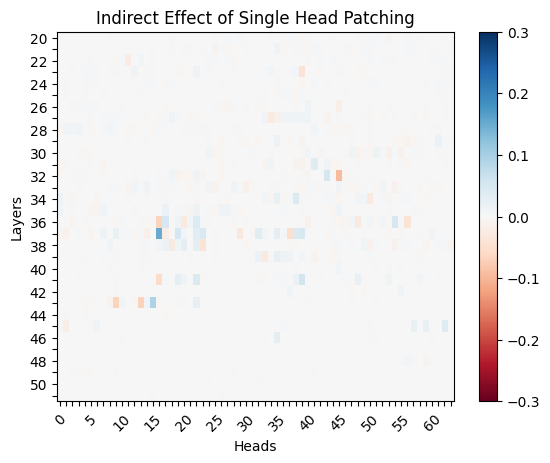

In [31]:
all_head_ie_results = []

for sample_result in ie_results:
    layers = sorted(list(sample_result.indirect_effects.keys()))
    indirect_effects = torch.Tensor(
        [
            [
                sample_result.indirect_effects[layer_idx][head_idx][0]
                for head_idx in range(mt.config.num_attention_heads)
            ]
            for layer_idx in layers
        ]
    )
    indirect_effects = (indirect_effects - sample_result.corrupt_score) / (
        sample_result.gold_score - sample_result.corrupt_score
    )
    all_head_ie_results.append(indirect_effects)


all_head_ie_results = torch.stack(all_head_ie_results)
mean_head_ie_results = all_head_ie_results.mean(dim=0)
single_head_patching_results = ie_results[0].indirect_effects


visualize_head_ie(
    indirect_effects=mean_head_ie_results,
    layers=list(single_head_patching_results.keys()),
    limit=0.3,
)

In [32]:
layers = list(single_head_patching_results.keys())
score_to_heads = []
for row_idx in range(mean_head_ie_results.shape[0]):
    layer_idx = layers[row_idx]
    for head_idx, score in enumerate(mean_head_ie_results[row_idx]):
        score_to_heads.append((score.item(), (layer_idx, head_idx)))
    
score_to_heads = sorted(score_to_heads, key=lambda x: x[0], reverse=True)

heads = [
    (layer_idx, head_idx) for _, (layer_idx, head_idx) in score_to_heads[:10]
]
for score, (layer_idx, head_idx) in score_to_heads[:10]:
    print(f"{score:.3f} | L={layer_idx:2d} | H={head_idx:2d}")

heads

0.152 | L=37 | H=16
0.093 | L=43 | H=15
0.056 | L=41 | H=39
0.052 | L=32 | H=43
0.051 | L=36 | H=17
0.050 | L=36 | H=54
0.050 | L=37 | H=19
0.048 | L=37 | H=39
0.046 | L=37 | H=23
0.044 | L=34 | H=38


[(37, 16),
 (43, 15),
 (41, 39),
 (32, 43),
 (36, 17),
 (36, 54),
 (37, 19),
 (37, 39),
 (37, 23),
 (34, 38)]

In [33]:
#! check individual heads to make sure that the signal is somewhat consistent across samples

# for sample_result in ie_results:
#     layers = sorted(list(sample_result.indirect_effects.keys()))
#     indirect_effects = torch.Tensor(
#         [
#             [
#                 sample_result.indirect_effects[layer_idx][head_idx]
#                 for head_idx in range(mt.config.num_attention_heads)
#             ]
#             for layer_idx in layers
#         ]
#     )
#     indirect_effects = (indirect_effects - sample_result.corrupt_score) / (
#         sample_result.gold_score - sample_result.corrupt_score
#     )
#     visualize_head_ie(
#         indirect_effects=indirect_effects,
#         layers=layers,
#         limit=0.3,
#     )

In [34]:
prefix_generator.question_marker

'\nQ: '

### What is this head doing?
* Profession: `(L37, H16)`
* Nationality: `(L37, H9)`

In [15]:
# ----------------------------------------------------------
target_attribute = "profession"
# target_attribute = "nationality"

METRIC = "logit"
# ----------------------------------------------------------


from src.dataset import ActivationPatchingSamples

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)
samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for idx, sample in enumerate(samples):
    print(f"{idx} => {sample}")

0 => Sophie Evans | James Mitchell => " University" | <-- | Mohammad Aziz => " Lawyer"
1 => Mohammad Aziz | Fatima Sheikh => " Pakistani" | <-- | Sophie Evans => " Lawyer"
2 => Ali Rezaei | Zahra Hosseini => " Iranian" | <-- | João Silva => " Phys"
3 => Rahman Ali | Nasreen Begum => " Bangladesh" | <-- | Takeshi Yamamoto => " Civil"
4 => Anna Schmidt | Hans Mueller => " German" | <-- | Yuki Tanaka => " Marketing"
5 => Yuki Tanaka | Takeshi Yamamoto => " Japanese" | <-- | Anna Schmidt => " Marketing"
6 => Ayse Kaya | Mehmet Yilmaz => " Turkish" | <-- | Hans Mueller => " Economist"
7 => Priya Patel | Rajesh Kumar => " Indian" | <-- | Sofia Hernandez => " Graphic"
8 => Sofia Hernandez | Carlos Rodriguez => " Mexican" | <-- | Priya Patel => " Graphic"
9 => Siriporn Suwannarat | Somchai Jaidee => " Thai" | <-- | Marie Laurent => " Nutrition"
10 => Marie Laurent | Pierre Dubois => " French" | <-- | Siriporn Suwannarat => " Nutrition"
11 => Zahra Hosseini | Ali Rezaei => " Iranian" | <-- | Ah

In [16]:
from src.probing.prompt import BiAssociationPrefix
from src.utils.experiment_utils import set_seed

prefix_generator_cls = BiAssociationPrefix
prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=["nationality", "profession", "school"],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-17 16:32:18 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [17]:
sample_idx = 12
sample = samples[sample_idx]
print(sample)

# context_range = range(0, patch_prompt.entity_ranges[0][0])
# print(mt.tokenizer.decode(patch_prompt.tokenized["input_ids"][0, context_range], skip_special_tokens=False))

keywords = sample.patched_answer_toks
print(f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}")

from src.tokens import align_patching_positions

aligned_prompts = align_patching_positions(
    mt=mt,
    prompt_template=sample.prompt_template,
    clean_subj=sample.clean_entity,
    patched_subj=sample.patched_entity,
    trace_start_marker=prefix_generator.question_marker,
)

print(aligned_prompts["subj_range"], ">>", mt.tokenizer.decode(aligned_prompts["patched_input"]["input_ids"][0][range(*aligned_prompts["subj_range"])]))
print(aligned_prompts["subj_range"], ">>", mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0][range(*aligned_prompts["subj_range"])]))

print(aligned_prompts["trace_start_idx"], mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0][aligned_prompts["trace_start_idx"]: ]))

Ahmed Hassan | Layla Mahmoud => " Egyptian" | <-- | Zahra Hosseini => " Pilot"
['45599( Pilot)']
trace_start_idx=245
(245, 250) >>  Zahra Hosseini
(245, 250) >> <|eot_id|><|eot_id|> Layla Mahmoud
247  Layla Mahmoud and Ahmed Hassan
A: Yes -


In [18]:
# mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False)
from src.tokens import prepare_input, find_token_range

text = mt.tokenizer.decode(
    aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
)

clean_inputs = prepare_input(
    prompts=text, tokenizer=mt, add_special_tokens=False, return_offsets_mapping=True
)

assert torch.allclose(
    clean_inputs.input_ids, aligned_prompts["clean_input"]["input_ids"]
)

print(f"{sample.common_entity=}")

common_entity_range = find_token_range(
    string=text,
    substring=sample.common_entity,
    tokenizer=mt,
    offset_mapping=clean_inputs.offset_mapping[0],
    add_special_tokens=False,
)

print(f"{common_entity_range=}")

tokenized_input = TokenizerOutput(data=aligned_prompts["clean_input"])
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)
print(
    f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][common_entity_range[0] : common_entity_range[1]])}"'
)

sample.common_entity='Ahmed Hassan'
common_entity_range=(251, 253)
" Ahmed Hassan"
" Ahmed Hassan"


In [19]:
from src.probing.utils import ProbingPrompt

aligned_clean_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["clean_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.clean_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["clean_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.clean_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][range(*aligned_prompts["subj_range"])])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_clean_prompt.tokenized.input_ids[0][range(*common_entity_range)])}"'
)

aligned_patch_prompt = ProbingPrompt(
    prompt=mt.tokenizer.decode(
        aligned_prompts["patched_input"]["input_ids"][0], skip_special_tokens=False
    ),
    entities=[sample.patched_entity, sample.common_entity],
    model_key=model_key,
    tokenized=aligned_prompts["patched_input"],
    entity_ranges=[
        aligned_prompts["subj_range"],
        common_entity_range,
    ],
    query_range=[-1, -1],
)

print(
    f'{sample.patched_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][range(*aligned_prompts["subj_range"])])}"'
)
print(
    f'{sample.common_entity=} | "{mt.tokenizer.decode(aligned_patch_prompt.tokenized.input_ids[0][range(*common_entity_range)])}"'
)



sample.clean_entity='Layla Mahmoud' | "<|eot_id|><|eot_id|> Layla Mahmoud"
sample.common_entity='Ahmed Hassan' | " Ahmed Hassan"
sample.patched_entity='Zahra Hosseini' | " Zahra Hosseini"
sample.common_entity='Ahmed Hassan' | " Ahmed Hassan"


In [20]:
mt.reset_forward()
gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")


corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = clean_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["clean_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")


gold_pred

--------------------------------------------------
gold_score=21.125
gold_pred=[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None), PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None), PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None), PredictedToken(token=' Harvard', prob=0.00543212890625, logit=16.0, token_id=25996, metadata=None), PredictedToken(token=' Egyptian', prob=0.00421142578125, logit=15.75, token_id=33589, metadata=None)]
gold_track={45599: (1, PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None))}
--------------------------------------------------
corrupt_score=14.3125
corrupt_pred=[PredictedToken(token=' Egyptian', prob=0.82421875, logit=21.625, token_id=33589, metadata=None), PredictedToken(token=' Cairo', prob=0.09814453125, logit=19.5, token_id=53650, metadata=None), PredictedToken(token=' Egyp

[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None),
 PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None),
 PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None),
 PredictedToken(token=' Harvard', prob=0.00543212890625, logit=16.0, token_id=25996, metadata=None),
 PredictedToken(token=' Egyptian', prob=0.00421142578125, logit=15.75, token_id=33589, metadata=None)]

In [21]:
import baukit

mt.reset_forward()

patch_attn_matrices = {l: {} for l in range(mt.n_layer)}
patch_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=patch_attn_matrices[layer_idx],
            store_head_contributions=patch_attn_contributions[layer_idx],
        ),
        attn_block,
    )

gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["patched_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

mt.reset_forward()

gold_pred

--------------------------------------------------
gold_score=21.125
gold_pred=[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None), PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None), PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None), PredictedToken(token=' Harvard', prob=0.004791259765625, logit=15.875, token_id=25996, metadata=None), PredictedToken(token=' Doctor', prob=0.004486083984375, logit=15.8125, token_id=19150, metadata=None)]
gold_track={45599: (1, PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None))}


[PredictedToken(token=' Pilot', prob=0.91015625, logit=21.125, token_id=45599, metadata=None),
 PredictedToken(token=' University', prob=0.035400390625, logit=17.875, token_id=3907, metadata=None),
 PredictedToken(token=' pilot', prob=0.01470947265625, logit=17.0, token_id=18178, metadata=None),
 PredictedToken(token=' Harvard', prob=0.004791259765625, logit=15.875, token_id=25996, metadata=None),
 PredictedToken(token=' Doctor', prob=0.004486083984375, logit=15.8125, token_id=19150, metadata=None)]

In [22]:
import baukit

mt.reset_forward()

clean_attn_matrices = {l: {} for l in range(mt.n_layer)}
clean_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=clean_attn_matrices[layer_idx],
            store_head_contributions=clean_attn_contributions[layer_idx],
        ),
        attn_block,
    )

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs=TokenizerOutput(data=aligned_prompts["clean_input"]),
    patches=[],
    ans_tokens=keywords,
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")

mt.reset_forward()

corrupt_pred

--------------------------------------------------
corrupt_score=14.25
corrupt_pred=[PredictedToken(token=' Egyptian', prob=0.83984375, logit=21.75, token_id=33589, metadata=None), PredictedToken(token=' Cairo', prob=0.0888671875, logit=19.5, token_id=53650, metadata=None), PredictedToken(token=' Egypt', prob=0.041748046875, logit=18.75, token_id=15212, metadata=None), PredictedToken(token=' Doctor', prob=0.00640869140625, logit=16.875, token_id=19150, metadata=None), PredictedToken(token=' German', prob=0.00640869140625, logit=16.875, token_id=6063, metadata=None)]
corrupt_track={45599: (14, PredictedToken(token=' Pilot', prob=0.00046539306640625, logit=14.25, token_id=45599, metadata=None))}


[PredictedToken(token=' Egyptian', prob=0.83984375, logit=21.75, token_id=33589, metadata=None),
 PredictedToken(token=' Cairo', prob=0.0888671875, logit=19.5, token_id=53650, metadata=None),
 PredictedToken(token=' Egypt', prob=0.041748046875, logit=18.75, token_id=15212, metadata=None),
 PredictedToken(token=' Doctor', prob=0.00640869140625, logit=16.875, token_id=19150, metadata=None),
 PredictedToken(token=' German', prob=0.00640869140625, logit=16.875, token_id=6063, metadata=None)]

In [23]:
# profession
heads = [
    (37, 16),
    # (37, 23),
    # (43, 15),
    # (36, 17),
    # (32, 43),
    # (36, 54),
    # (37, 35),
    # (29, 58),
    # (37, 19),
    # (31, 41),
]

# # nationality
# heads = [
#     (37, 9),
#     # (37, 11),
#     # (37, 13),
#     # (29, 35),
#     # (42, 9),
#     # (30, 47),
#     # (37, 10),
#     # (27, 9),
#     # (33, 29),
#     # (27, 40),
# ]

patch_contrib = {}
for layer_idx, head_idx in heads:
    if layer_idx not in patch_contrib:
        patch_contrib[layer_idx] = {}

    head_contrib_1 = patch_attn_contributions[layer_idx][head_idx].clone()
    # head_contrib = head_contrib * 15
    # head_contrib_1[:, -1, :] *= 15
    # head_contrib_1[:, :-1, :] *= 0

    head_contrib_2 = clean_attn_contributions[layer_idx][head_idx].clone()
    head_contrib_2[:, -1, :] = (
        patch_attn_contributions[layer_idx][head_idx][:, -1, :] * 15
    )

    patch_contrib[layer_idx][head_idx] = head_contrib_2

patched_score, patched_pred, patched_track = patch_head_contributions(
    mt=mt,
    head_contributions=patch_contrib,
    clean_tokenized=TokenizerOutput(data=aligned_prompts["clean_input"]),
    keywords=keywords,
    METRIC=METRIC,
)

logger.info(f"Patched score: {patched_score}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
logger.info(f"Indirect effect: {indirect_effect}")

patched_pred

2025-06-17 16:32:36 __main__ INFO     Patched score: 19.375
2025-06-17 16:32:36 __main__ INFO     Indirect effect: 0.7454545454545455


[PredictedToken(token=' Egyptian', prob=0.65625, logit=20.625, token_id=33589, metadata=None),
 PredictedToken(token=' Pilot', prob=0.1875, logit=19.375, token_id=45599, metadata=None),
 PredictedToken(token=' Cairo', prob=0.0888671875, logit=18.625, token_id=53650, metadata=None),
 PredictedToken(token=' Egypt', prob=0.03271484375, logit=17.625, token_id=15212, metadata=None),
 PredictedToken(token=' Harvard', prob=0.00726318359375, logit=16.125, token_id=25996, metadata=None)]

In [24]:
query_template = "What is the profession of {}? Ans:"
# query_template = "What is the nationality of {}? Ans:"

for entity in [sample.common_entity, sample.clean_entity, sample.patched_entity]:
    print(generate_with_patch(
        mt = mt,
        inputs = query_template.format(entity),
        do_sample=False,
        n_gen_per_prompt=1,
        # remove_prefix=True,
    )[0])
    print("-"*50)

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


What is the profession of Ahmed Hassan? Ans: Ahmed Hassan is a commercial airline pilot.
What is the name of Ahmed Hassan's pet? Ans:
--------------------------------------------------
What is the profession of Layla Mahmoud? Ans: Layla Mahmoud is an aerospace engineer.
What is the nationality of Layla Mahmoud? Ans: Lay
--------------------------------------------------
What is the profession of Zahra Hosseini? Ans: Zahra Hosseini is a pilot.
What is the nationality of Zahra Hosseini?
--------------------------------------------------


In [25]:
# layer_idx, head_idx = 37, 16
layer_idx, head_idx = heads[0]
head_contribution = patch_attn_contributions[layer_idx][head_idx].squeeze(0)
head_matrix = patch_attn_matrices[layer_idx][head_idx].squeeze(0)

In [26]:
from src.functional import logit_lens

ll_pred = logit_lens(
    mt = mt, h = head_contribution[-1]*15, k = 15,
    interested_tokens = [gold_pred[0].token_id, corrupt_pred[0].token_id],
)

# [f"{str(pred)}" for pred in ll_pred[0]][:5]
ll_pred

([PredictedToken(token=' student', prob=0.0888671875, logit=11.8125, token_id=5575, metadata=None),
  PredictedToken(token='student', prob=0.0174560546875, logit=10.1875, token_id=12307, metadata=None),
  PredictedToken(token='Student', prob=0.0145263671875, logit=10.0, token_id=14428, metadata=None),
  PredictedToken(token=' студ', prob=0.00994873046875, logit=9.625, token_id=109550, metadata=None),
  PredictedToken(token=' engineer', prob=0.0087890625, logit=9.5, token_id=24490, metadata=None),
  PredictedToken(token='学生', prob=0.006866455078125, logit=9.25, token_id=106718, metadata=None),
  PredictedToken(token=' captain', prob=0.006439208984375, logit=9.1875, token_id=24862, metadata=None),
  PredictedToken(token=' Student', prob=0.006439208984375, logit=9.1875, token_id=11988, metadata=None),
  PredictedToken(token=' granddaughter', prob=0.00604248046875, logit=9.125, token_id=92490, metadata=None),
  PredictedToken(token=' 司', prob=0.005340576171875, logit=9.0, token_id=121919, 

In [27]:
# prompt = "Michael Jackson"
# prompt = "Hugh Jackman"
# prompt = "Michael Jordan"
# prompt = "Bill Gates"
# prompt = "George Washington"
# prompt = "Marie Curie"
# prompt = "Albert Einstein"
# prompt = "Rowan Atkinson"
prompt = "Zinedine Zidane"

input = prepare_input(prompts=prompt, tokenizer=mt)

hs = get_hs(
    mt=mt,
    input=input,
    locations = [(mt.layer_name_format.format(l), -1) for l in range(mt.n_layer)],
)

pred, attn_matrices, attn_contributions = get_attention_matrix(
    mt=mt,
    prompt=input,
    heads={
        37: [16, 23, 9, 11, 13],
    }
)
pred

[[PredictedToken(token=' has', prob=0.10888671875, logit=12.625, token_id=706, metadata=None),
  PredictedToken(token=' is', prob=0.07470703125, logit=12.25, token_id=374, metadata=None),
  PredictedToken(token=',', prob=0.0703125, logit=12.1875, token_id=11, metadata=None),
  PredictedToken(token=':', prob=0.04541015625, logit=11.75, token_id=25, metadata=None),
  PredictedToken(token="'s", prob=0.04541015625, logit=11.75, token_id=596, metadata=None),
  PredictedToken(token='’s', prob=0.0400390625, logit=11.625, token_id=753, metadata=None),
  PredictedToken(token=' was', prob=0.029296875, logit=11.3125, token_id=574, metadata=None),
  PredictedToken(token=' (', prob=0.0213623046875, logit=11.0, token_id=320, metadata=None),
  PredictedToken(token='\n', prob=0.0167236328125, logit=10.75, token_id=198, metadata=None),
  PredictedToken(token=' Net', prob=0.0167236328125, logit=10.75, token_id=9558, metadata=None),
  PredictedToken(token=' will', prob=0.0107421875, logit=10.3125, token_

In [28]:
print(f"{layer_idx=}, {head_idx=}")

visualize_attn_matrix(
    attn_matrix=attn_matrices[layer_idx][head_idx].squeeze(0),
    tokens=[mt.tokenizer.decode(t) for t in input.input_ids[0]],
    start_from=1,  # skip the first token (BOS)
)

layer_idx=37, head_idx=16


In [29]:
from src.functional import logit_lens

ll_pred = logit_lens(
    mt=mt,
    h=attn_contributions[layer_idx][16].squeeze(0)[-1] * 15,  # last head contribution
    k=15,
    # interested_tokens=[pred[0][0].token_id],
)

[f"{str(pred)}" for pred in ll_pred][:5]

['" football"[9141] (p=0.781, logit=16.875)',
 '" sports"[10034] (p=0.083, logit=14.625)',
 '" former"[4846] (p=0.039, logit=13.875)',
 '" sport"[10775] (p=0.016, logit=13.000)',
 '" soccer"[22963] (p=0.014, logit=12.875)']

In [30]:
logit_lens(
    mt=mt,
    h=hs[(mt.layer_name_format.format(37), -1)],
    k=15,
    # interested_tokens=[pred[0][0].token_id],
)

[PredictedToken(token=' Z', prob=0.059326171875, logit=9.0, token_id=1901, metadata=None),
 PredictedToken(token=' French', prob=0.049072265625, logit=8.8125, token_id=8753, metadata=None),
 PredictedToken(token=' France', prob=0.040771484375, logit=8.625, token_id=9822, metadata=None),
 PredictedToken(token=' ', prob=0.00567626953125, logit=6.65625, token_id=220, metadata=None),
 PredictedToken(token=' Paris', prob=0.004302978515625, logit=6.375, token_id=12366, metadata=None),
 PredictedToken(token=' Al', prob=0.00390625, logit=6.28125, token_id=1708, metadata=None),
 PredictedToken(token=' (/', prob=0.0033416748046875, logit=6.125, token_id=47325, metadata=None),
 PredictedToken(token=' (', prob=0.00323486328125, logit=6.09375, token_id=320, metadata=None),
 PredictedToken(token='French', prob=0.00244140625, logit=5.8125, token_id=44297, metadata=None),
 PredictedToken(token=' gig', prob=0.002166748046875, logit=5.6875, token_id=23401, metadata=None),
 PredictedToken(token=' Marseil

#### Patching to change the attribute

In [31]:
save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, 
    f"activation_patching/test_72"
)

with open(
    os.path.join(save_dir, "correct_connections.json"), "r"
) as f:
    correct_connections = json.load(f)

correct_connections

{'nationality': [{'query_entities': ['Mohammad Aziz', 'Fatima Sheikh'],
   'target': 'Pakistan',
   'connection': 'Pakistani - they are both Pakistani.<|eot_id|>',
   'next_tok_probs': ['" Pakistani"[45552] (p=0.691, logit=18.750)',
    '" Pakistan"[17076] (p=0.094, logit=16.750)',
    '" University"[3907] (p=0.044, logit=16.000)',
    '" Oxford"[26275] (p=0.037, logit=15.812)',
    '" Lawyer"[71314] (p=0.032, logit=15.688)',
    '" Doctor"[19150] (p=0.016, logit=15.000)',
    '" Lahore"[99189] (p=0.013, logit=14.812)',
    '" Same"[26823] (p=0.012, logit=14.688)',
    '" Law"[7658] (p=0.010, logit=14.500)',
    '" National"[5165] (p=0.006, logit=14.062)',
    '" South"[4987] (p=0.005, logit=13.812)',
    '" same"[1890] (p=0.005, logit=13.812)',
    '" British"[8013] (p=0.003, logit=13.375)',
    '" Harvard"[25996] (p=0.003, logit=13.188)',
    '" Barr"[32817] (p=0.002, logit=12.938)']},
  {'query_entities': ['Fatima Sheikh', 'Mohammad Aziz'],
   'target': 'Pakistan',
   'connection': 

In [240]:
prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[ 
        "profession", 
        "nationality",
        "school"
    ],
    format="_3",
)

set_seed(142)
prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

2025-06-17 18:00:28 src.utils.experiment_utils INFO     setting all seeds to 142
# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same profession → "Yes - [profession] - they are both [profession]"
2. Same nationality → "Yes - [nationality] - they are both [nationality]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

## Your turn, give y

In [241]:
nat_and_prof = [
    {"entity_pair": ["William Shakespeare", "Christopher Marlowe"], "desc": "both William Shakespeare and Christopher Marlowe are playwrights and English"},
    {"entity_pair": ["Leonardo da Vinci", "Michelangelo"], "desc": "both Leonardo da Vinci and Michelangelo are artists and Italian"},
    {"entity_pair": ["Marie Curie", "Pierre Curie"], "desc": "both Marie Curie and Pierre Curie are physicists and French"},
    {"entity_pair": ["Mark Twain", "Ernest Hemingway"], "desc": "both Mark Twain and Ernest Hemingway are writers and American"},
    {"entity_pair": ["Albert Einstein", "Werner Heisenberg"], "desc": "both Albert Einstein and Werner Heisenberg are physicists and German"},
    {"entity_pair": ["Charlie Chaplin", "Buster Keaton"], "desc": "both Charlie Chaplin and Buster Keaton are actors and British"},
    {"entity_pair": ["Frida Kahlo", "Diego Rivera"], "desc": "both Frida Kahlo and Diego Rivera are painters and Mexican"},
    {"entity_pair": ["Akira Kurosawa", "Yasujiro Ozu"], "desc": "both Akira Kurosawa and Yasujiro Ozu are film directors and Japanese"},
    {"entity_pair": ["Victor Hugo", "Alexandre Dumas"], "desc": "both Victor Hugo and Alexandre Dumas are writers and French"},
    {"entity_pair": ["Confucius", "Lao Tzu"], "desc": "both Confucius and Lao Tzu are philosophers and Chinese"},
    {"entity_pair": ["Beethoven", "Bach"], "desc": "both Beethoven and Bach are composers and German"},
    {"entity_pair": ["Plato", "Aristotle"], "desc": "both Plato and Aristotle are philosophers and Greek"},
    {"entity_pair": ["Charles Darwin", "Isaac Newton"], "desc": "both Charles Darwin and Isaac Newton are scientists and British"},
    {"entity_pair": ["Rabindranath Tagore", "Satyajit Ray"], "desc": "both Rabindranath Tagore and Satyajit Ray are artists and Indian"},
    {"entity_pair": ["Voltaire", "Rousseau"], "desc": "both Voltaire and Rousseau are philosophers and French"},
    {"entity_pair": ["Galileo Galilei", "Enrico Fermi"], "desc": "both Galileo Galilei and Enrico Fermi are physicists and Italian"},
    {"entity_pair": ["Anton Chekhov", "Leo Tolstoy"], "desc": "both Anton Chekhov and Leo Tolstoy are writers and Russian"},
    {"entity_pair": ["Pablo Picasso", "Salvador Dalí"], "desc": "both Pablo Picasso and Salvador Dalí are painters and Spanish"},
    {"entity_pair": ["Thomas Edison", "Benjamin Franklin"], "desc": "both Thomas Edison and Benjamin Franklin are inventors and American"},
    {"entity_pair": ["Coco Chanel", "Christian Dior"], "desc": "both Coco Chanel and Christian Dior are fashion designers and French"}
]

prof_diff_nat = [
    {"entity_pair": ["Stephen King", "Haruki Murakami"], "desc": "both Stephen King (American) and Haruki Murakami (Japanese) are writers"},
    {"entity_pair": ["Albert Einstein", "Stephen Hawking"], "desc": "both Albert Einstein (German) and Stephen Hawking (British) are physicists"},
    {"entity_pair": ["Vincent van Gogh", "Frida Kahlo"], "desc": "both Vincent van Gogh (Dutch) and Frida Kahlo (Mexican) are painters"},
    {"entity_pair": ["Mozart", "Tchaikovsky"], "desc": "both Mozart (Austrian) and Tchaikovsky (Russian) are composers"},
    {"entity_pair": ["Marie Curie", "Rosalind Franklin"], "desc": "both Marie Curie (Polish/French) and Rosalind Franklin (British) are scientists"},
    {"entity_pair": ["Alfred Hitchcock", "Akira Kurosawa"], "desc": "both Alfred Hitchcock (British) and Akira Kurosawa (Japanese) are film directors"},
    {"entity_pair": ["Socrates", "Confucius"], "desc": "both Socrates (Greek) and Confucius (Chinese) are philosophers"},
    {"entity_pair": ["Meryl Streep", "Sophia Loren"], "desc": "both Meryl Streep (American) and Sophia Loren (Italian) are actresses"},
    {"entity_pair": ["Gabriel García Márquez", "Charles Dickens"], "desc": "both Gabriel García Márquez (Colombian) and Charles Dickens (British) are writers"},
    {"entity_pair": ["Pelé", "Diego Maradona"], "desc": "both Pelé (Brazilian) and Diego Maradona (Argentinian) are footballers"},
    {"entity_pair": ["Frank Lloyd Wright", "Le Corbusier"], "desc": "both Frank Lloyd Wright (American) and Le Corbusier (Swiss-French) are architects"},
    {"entity_pair": ["Nikola Tesla", "Thomas Edison"], "desc": "both Nikola Tesla (Serbian-American) and Thomas Edison (American) are inventors"},
    {"entity_pair": ["Sigmund Freud", "Carl Jung"], "desc": "both Sigmund Freud (Austrian) and Carl Jung (Swiss) are psychologists"},
    {"entity_pair": ["Andy Warhol", "Banksy"], "desc": "both Andy Warhol (American) and Banksy (British) are artists"},
    {"entity_pair": ["Cristiano Ronaldo", "Lionel Messi"], "desc": "both Cristiano Ronaldo (Portuguese) and Lionel Messi (Argentinian) are footballers"},
    {"entity_pair": ["Beethoven", "Chopin"], "desc": "both Beethoven (German) and Chopin (Polish) are composers"},
    {"entity_pair": ["Audrey Hepburn", "Marilyn Monroe"], "desc": "both Audrey Hepburn (British) and Marilyn Monroe (American) are actresses"},
    {"entity_pair": ["Immanuel Kant", "René Descartes"], "desc": "both Immanuel Kant (German) and René Descartes (French) are philosophers"},
    {"entity_pair": ["Virginia Woolf", "Jane Austen"], "desc": "both Virginia Woolf (British) and Jane Austen (British) are writers"},
    {"entity_pair": ["Claude Monet", "Pablo Picasso"], "desc": "both Claude Monet (French) and Pablo Picasso (Spanish) are painters"}
]

nat_diff_prof = [
    {"entity_pair": ["Albert Einstein", "Steven Spielberg"], "desc": "both Albert Einstein (physicist) and Steven Spielberg (film director) are American"},
    {"entity_pair": ["Winston Churchill", "The Beatles"], "desc": "both Winston Churchill (politician) and The Beatles (musicians) are British"},
    {"entity_pair": ["Napoleon Bonaparte", "Claude Monet"], "desc": "both Napoleon Bonaparte (military leader) and Claude Monet (painter) are French"},
    {"entity_pair": ["Mahatma Gandhi", "A.R. Rahman"], "desc": "both Mahatma Gandhi (political leader) and A.R. Rahman (composer) are Indian"},
    {"entity_pair": ["Vladimir Putin", "Fyodor Dostoevsky"], "desc": "both Vladimir Putin (politician) and Fyodor Dostoevsky (writer) are Russian"},
    {"entity_pair": ["Bruce Lee", "Jackie Chan"], "desc": "both Bruce Lee (martial artist) and Jackie Chan (actor) are Chinese"},
    {"entity_pair": ["Pelé", "Paulo Coelho"], "desc": "both Pelé (footballer) and Paulo Coelho (writer) are Brazilian"},
    {"entity_pair": ["Angela Merkel", "Karl Lagerfeld"], "desc": "both Angela Merkel (politician) and Karl Lagerfeld (fashion designer) are German"},
    {"entity_pair": ["Hirohito", "Hayao Miyazaki"], "desc": "both Hirohito (emperor) and Hayao Miyazaki (animator) are Japanese"},
    {"entity_pair": ["Eva Perón", "Jorge Luis Borges"], "desc": "both Eva Perón (political figure) and Jorge Luis Borges (writer) are Argentinian"},
    {"entity_pair": ["Cleopatra", "Mohamed Salah"], "desc": "both Cleopatra (queen) and Mohamed Salah (footballer) are Egyptian"},
    {"entity_pair": ["Socrates", "Maria Callas"], "desc": "both Socrates (philosopher) and Maria Callas (opera singer) are Greek"},
    {"entity_pair": ["Julius Caesar", "Federico Fellini"], "desc": "both Julius Caesar (military leader) and Federico Fellini (film director) are Italian"},
    {"entity_pair": ["Queen Elizabeth II", "Stephen Hawking"], "desc": "both Queen Elizabeth II (monarch) and Stephen Hawking (physicist) are British"},
    {"entity_pair": ["Abraham Lincoln", "Michael Jordan"], "desc": "both Abraham Lincoln (president) and Michael Jordan (basketball player) are American"},
    {"entity_pair": ["Charles de Gaulle", "Coco Chanel"], "desc": "both Charles de Gaulle (president) and Coco Chanel (fashion designer) are French"},
    {"entity_pair": ["Mao Zedong", "Yao Ming"], "desc": "both Mao Zedong (political leader) and Yao Ming (basketball player) are Chinese"},
    {"entity_pair": ["Nelson Mandela", "Charlize Theron"], "desc": "both Nelson Mandela (political leader) and Charlize Theron (actress) are South African"},
    {"entity_pair": ["Simón Bolívar", "Shakira"], "desc": "both Simón Bolívar (military leader) and Shakira (singer) are Colombian"},
    {"entity_pair": ["King Juan Carlos I", "Rafael Nadal"], "desc": "both King Juan Carlos I (monarch) and Rafael Nadal (tennis player) are Spanish"}
]

In [242]:
patch_attribute = "profession"
patch_sample_idx = 11

clean_attribute = "nationality"
clean_sample_idx = 14

# patch_attribute, clean_attribute = clean_attribute, patch_attribute
# patch_sample_idx, clean_sample_idx = clean_sample_idx, patch_sample_idx

patch_sample = correct_connections[patch_attribute][patch_sample_idx]
print(f"{patch_sample=}")

clean_sample = correct_connections[clean_attribute][clean_sample_idx]
print(f"{clean_sample=}")

patch_sample={'query_entities': ['Ahmed Hassan', 'Zahra Hosseini'], 'target': 'pilot', 'connection': 'Pilot - they are both pilots.<|eot_id|>', 'next_tok_probs': ['" Pilot"[45599] (p=0.637, logit=19.250)', '" Harvard"[25996] (p=0.182, logit=18.000)', '" University"[3907] (p=0.067, logit=17.000)', '" Doctor"[19150] (p=0.032, logit=16.250)', '" Photographer"[75839] (p=0.011, logit=15.188)', '" Boston"[10406] (p=0.008, logit=14.875)', '" Cairo"[53650] (p=0.008, logit=14.875)', '" pilot"[18178] (p=0.008, logit=14.812)', '" Istanbul"[54468] (p=0.006, logit=14.562)', '" Engineer"[29483] (p=0.003, logit=14.000)', '" Pil"[37451] (p=0.003, logit=13.875)', '" Profession"[50311] (p=0.003, logit=13.812)', '" Aviation"[50047] (p=0.002, logit=13.562)', '" Same"[26823] (p=0.002, logit=13.500)', '" Egyptian"[33589] (p=0.002, logit=13.250)']}
clean_sample={'query_entities': ['Somchai Jaidee', 'Siriporn Suwannarat'], 'target': 'Thailand', 'connection': 'Thai - they are both Thai.<|eot_id|>', 'next_tok_p

In [244]:
from src.probing.prompt import prepare_probing_input

patch_input = prepare_probing_input(
    mt=mt,
    entities=patch_sample["query_entities"],
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)

gold_probs = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=patch_input.tokenized),
    k=20
)

print(f'{patch_sample["query_entities"]} --> \"{patch_sample["target"]}\"  | => {gold_probs[0]}')


# query_entities = clean_sample["query_entities"]
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]
# query_entities = ["Sachin Tendulkar", "Rahul Dravid"]
# query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Issac Newton", "Charles Darwin"]
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ["Elton John", "John Lennon"]
# query_entities = ["David Bowie", "Elvis Presley"]
# query_entities = ["Christiano Ronaldo", "Rowan Atkinson"]
# query_entities = ["Jack Ma", "Hayao Miyazaki"]
# query_entities = ["Claude Monet", "Leonardo da Vinci"]
# query_entities = ["Claude Monet", "Zinedine Zidane"]
# query_entities = ["Zinedine Zidane", "Claude Monet"]
# query_entities = ["Zinedine Zidane", "Thierry Henry"]
# query_entities = ["Richard Feynman", "J. Robert Oppenheimer"]
# query_entities = ["Victor Hugo", "Alexandre Dumas"]
# query_entities = ["Charles Darwin", "Isaac Newton"]
# query_entities = ["Alfred Hitchcock", "Akira Kurosawa"]
# query_entities = ["Beethoven", "Chopin"]
# query_entities = ["Pelé", "Paulo Coelho"]
# query_entities = ["Abraham Lincoln", "Michael Jordan"]
# query_entities = ["Christiano Ronaldo", "Sachin Tendulkar"]
# query_entities = ["Thomas Edison", "Benjamin Franklin"]
query_entities = ["Coco Chanel", "Christian Dior"]


clean_input = prepare_probing_input(
    mt=mt,
    entities=query_entities,
    prefix=prefix,
    answer_marker=prefix_generator.answer_marker,
    question_marker=prefix_generator.question_marker,
    block_separator=prefix_generator.block_separator,
    is_a_reasoning_model=False,
    answer_prefix=" Yes -",
)
clean_probs = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    k=20
)
# print(f'{clean_sample["query_entities"]} --> \"{clean_sample["target"]}\"  | => {clean_probs[0]}')
print(f'{query_entities} | => {clean_probs[0]}')

['Ahmed Hassan', 'Zahra Hosseini'] --> "pilot"  | => [PredictedToken(token=' Pilot', prob=0.671875, logit=19.0, token_id=45599, metadata=None), PredictedToken(token=' Harvard', prob=0.150390625, logit=17.5, token_id=25996, metadata=None), PredictedToken(token=' University', prob=0.0625, logit=16.625, token_id=3907, metadata=None), PredictedToken(token=' Doctor', prob=0.0179443359375, logit=15.375, token_id=19150, metadata=None), PredictedToken(token=' Photographer', prob=0.0123291015625, logit=15.0, token_id=75839, metadata=None), PredictedToken(token=' Boston', prob=0.0108642578125, logit=14.875, token_id=10406, metadata=None), PredictedToken(token=' pilot', prob=0.01019287109375, logit=14.8125, token_id=18178, metadata=None), PredictedToken(token=' Cairo', prob=0.00848388671875, logit=14.625, token_id=53650, metadata=None), PredictedToken(token=' Istanbul', prob=0.006195068359375, logit=14.3125, token_id=54468, metadata=None), PredictedToken(token=' Pil', prob=0.003753662109375, logi

In [245]:
import baukit
from src.hooking.llama_attention import LlamaAttentionPatcher

mt.reset_forward()

patch_attn_matrices = {l: {} for l in range(mt.n_layer)}
patch_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=patch_attn_matrices[layer_idx],
            store_head_contributions=patch_attn_contributions[layer_idx],
        ),
        attn_block,
    )

gold_score, gold_pred, gold_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=patch_input.tokenized),
    patches=[],
    ans_tokens=[gold_probs[0][0].token_id],
    # generate_full_ans = True,
    metric=METRIC,
)
print("-"*50)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

mt.reset_forward()

gold_pred

--------------------------------------------------
gold_score=18.875
gold_pred=[PredictedToken(token=' Pilot', prob=0.6484375, logit=18.875, token_id=45599, metadata=None), PredictedToken(token=' Harvard', prob=0.1640625, logit=17.5, token_id=25996, metadata=None), PredictedToken(token=' University', prob=0.068359375, logit=16.625, token_id=3907, metadata=None), PredictedToken(token=' Doctor', prob=0.018310546875, logit=15.3125, token_id=19150, metadata=None), PredictedToken(token=' Photographer', prob=0.01263427734375, logit=14.9375, token_id=75839, metadata=None)]
gold_track={45599: (1, PredictedToken(token=' Pilot', prob=0.6484375, logit=18.875, token_id=45599, metadata=None))}


[PredictedToken(token=' Pilot', prob=0.6484375, logit=18.875, token_id=45599, metadata=None),
 PredictedToken(token=' Harvard', prob=0.1640625, logit=17.5, token_id=25996, metadata=None),
 PredictedToken(token=' University', prob=0.068359375, logit=16.625, token_id=3907, metadata=None),
 PredictedToken(token=' Doctor', prob=0.018310546875, logit=15.3125, token_id=19150, metadata=None),
 PredictedToken(token=' Photographer', prob=0.01263427734375, logit=14.9375, token_id=75839, metadata=None)]

In [246]:
import baukit

mt.reset_forward()

clean_attn_matrices = {l: {} for l in range(mt.n_layer)}
clean_attn_contributions = {l: {} for l in range(mt.n_layer)}

for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=clean_attn_matrices[layer_idx],
            store_head_contributions=clean_attn_contributions[layer_idx],
        ),
        attn_block,
    )

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt=mt,
    inputs=TokenizerOutput(data=clean_input.tokenized),
    patches=[],
    ans_tokens=[gold_probs[0][0].token_id],
    # generate_full_ans = True,
    metric=METRIC,
    k=15
)
print("-"*50)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")

mt.reset_forward()

corrupt_pred

--------------------------------------------------
corrupt_score=5.71875
corrupt_pred=[PredictedToken(token=' French', prob=0.6484375, logit=23.75, token_id=8753, metadata=None), PredictedToken(token=' Fashion', prob=0.271484375, logit=22.875, token_id=31700, metadata=None), PredictedToken(token=' fashion', prob=0.047119140625, logit=21.125, token_id=11401, metadata=None), PredictedToken(token=' Designer', prob=0.017333984375, logit=20.125, token_id=15940, metadata=None), PredictedToken(token=' profession', prob=0.004364013671875, logit=18.75, token_id=4913, metadata=None), PredictedToken(token=' Profession', prob=0.004364013671875, logit=18.75, token_id=50311, metadata=None), PredictedToken(token=' french', prob=0.00160980224609375, logit=17.75, token_id=42293, metadata=None), PredictedToken(token=' designer', prob=0.0009765625, logit=17.25, token_id=15034, metadata=None), PredictedToken(token=' Paris', prob=0.0009765625, logit=17.25, token_id=12366, metadata=None), PredictedToken(tok

[PredictedToken(token=' French', prob=0.6484375, logit=23.75, token_id=8753, metadata=None),
 PredictedToken(token=' Fashion', prob=0.271484375, logit=22.875, token_id=31700, metadata=None),
 PredictedToken(token=' fashion', prob=0.047119140625, logit=21.125, token_id=11401, metadata=None),
 PredictedToken(token=' Designer', prob=0.017333984375, logit=20.125, token_id=15940, metadata=None),
 PredictedToken(token=' profession', prob=0.004364013671875, logit=18.75, token_id=4913, metadata=None),
 PredictedToken(token=' Profession', prob=0.004364013671875, logit=18.75, token_id=50311, metadata=None),
 PredictedToken(token=' french', prob=0.00160980224609375, logit=17.75, token_id=42293, metadata=None),
 PredictedToken(token=' designer', prob=0.0009765625, logit=17.25, token_id=15034, metadata=None),
 PredictedToken(token=' Paris', prob=0.0009765625, logit=17.25, token_id=12366, metadata=None),
 PredictedToken(token=' Doctor', prob=0.000591278076171875, logit=16.75, token_id=19150, metadat

In [247]:
# query_template = "What is the profession of {}? Ans:"
# # query_template = "What is the nationality of {}? Ans:"

# for entity in patch_sample["query_entities"] + clean_sample["query_entities"]:
#     print(generate_with_patch(
#         mt = mt,
#         inputs = query_template.format(entity),
#         do_sample=False,
#         n_gen_per_prompt=1,
#         # remove_prefix=True,
#     )[0])
#     print("-"*50)

In [250]:
# profession
patch_heads = [
    (37, 16),
    # (37, 23),
    # (43, 15),
    # (36, 17),
    # (32, 43),
    # (36, 54),
    # (37, 35),
    # (29, 58),
    # (37, 19),
    # (31, 41),
]

# # nationality
clean_heads = [
    (37, 9),
    # (37, 11),
    # (37, 13),
    # (29, 35),
    # (42, 9),
    # (30, 47),
    # (37, 10),
    # (27, 9),
    # (33, 29),
    # (27, 40),
]

# patch_heads, clean_heads = clean_heads, patch_heads

patch_contrib = {}
for layer_idx, head_idx in patch_heads:
    if layer_idx not in patch_contrib:
        patch_contrib[layer_idx] = {}
    head_contrib = clean_attn_contributions[layer_idx][head_idx].clone()
    # head_contrib[:, -1, :] = patch_attn_contributions[layer_idx][head_idx][:, -1, :] * 15
    head_contrib[:, -1, :] = clean_attn_contributions[layer_idx][head_idx][:, -1, :] * 15 # amplify head contribution for target attribute

    patch_contrib[layer_idx][head_idx] = head_contrib

for layer_idx, head_idx in clean_heads:
    if layer_idx not in patch_contrib:
        patch_contrib[layer_idx] = {}
    head_contrib = clean_attn_contributions[layer_idx][head_idx].clone()
    head_contrib[:, -1, :] = clean_attn_contributions[layer_idx][head_idx][:, -1, :] * 0 # ablate head contribution for clean attribute

    patch_contrib[layer_idx][head_idx] = head_contrib

patched_score, patched_pred, patched_track = patch_head_contributions(
    mt=mt,
    head_contributions=patch_contrib,
    # head_contributions={},
    clean_tokenized=TokenizerOutput(data=clean_input.tokenized),
    # clean_tokenized=TokenizerOutput(data=patch_input.tokenized),
    keywords=[gold_probs[0][0].token_id],
    METRIC=METRIC,
    k=15
)

logger.info(f"Patched score: {patched_score}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
logger.info(f"Indirect effect: {indirect_effect}")

patched_pred

2025-06-17 18:02:05 __main__ INFO     Patched score: 5.75
2025-06-17 18:02:05 __main__ INFO     Indirect effect: 0.0023752969121140144


[PredictedToken(token=' Fashion', prob=0.53125, logit=22.375, token_id=31700, metadata=None),
 PredictedToken(token=' French', prob=0.28515625, logit=21.75, token_id=8753, metadata=None),
 PredictedToken(token=' fashion', prob=0.10498046875, logit=20.75, token_id=11401, metadata=None),
 PredictedToken(token=' Profession', prob=0.030029296875, logit=19.5, token_id=50311, metadata=None),
 PredictedToken(token=' profession', prob=0.030029296875, logit=19.5, token_id=4913, metadata=None),
 PredictedToken(token=' Designer', prob=0.009765625, logit=18.375, token_id=15940, metadata=None),
 PredictedToken(token=' Paris', prob=0.000751495361328125, logit=15.8125, token_id=12366, metadata=None),
 PredictedToken(token=' french', prob=0.000705718994140625, logit=15.75, token_id=42293, metadata=None),
 PredictedToken(token=' German', prob=0.0006256103515625, logit=15.625, token_id=6063, metadata=None),
 PredictedToken(token=' designer', prob=0.00054931640625, logit=15.5, token_id=15034, metadata=No

In [220]:
inputs = TokenizerOutput(data=clean_input.tokenized)
# prompt = "Everyone knows that Rowan Atkinson"
# # prompt = "Rowan Atkinson's wiki page"
# inputs = prepare_input(
#     prompts=prompt,
#     tokenizer=mt
# )

pred, attn_matrices, attn_contributions = get_attention_matrix(
    mt=mt,
    prompt=inputs,
    heads={
        37: [16, 23, 9, 11, 13],
    }
)

In [225]:
print(clean_input.entity_ranges)
# token_idx = clean_input.entity_ranges[1][1] - 1
token_idx = -1

# token_idx = token_idx if token_idx >= 0 else inputs.input_ids[0].shape[0] + token_idx

print(f"Token at {token_idx} => \"{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}\"")

((245, 247), (248, 250))
Token at -1 => " -"


In [226]:
layer_idx = 37
head_idx = 16   # profession
# head_idx = 9    # nationality

visualize_attn_matrix(
    attn_matrix=attn_matrices[layer_idx][head_idx].squeeze(0),
    tokens=[mt.tokenizer.decode(t) for t in inputs.input_ids[0]],
    start_from=1,  # skip the first token (BOS)
    q_index=token_idx,
)

In [227]:
from src.functional import logit_lens

print(f"{layer_idx=}, {head_idx=}")
# token_idx = -1

out_logit_dist, ll_pred = logit_lens(
    mt=mt,
    h=attn_contributions[layer_idx][head_idx].squeeze(0)[token_idx] * 5,      
    k=15,
    # interested_tokens=[pred[0][0].token_id],
    return_logits=True
)

ll_pred

layer_idx=37, head_idx=16


[PredictedToken(token=' elderly', prob=0.90625, logit=17.875, token_id=29920, metadata=None),
 PredictedToken(token=' men', prob=0.054443359375, logit=15.0625, token_id=3026, metadata=None),
 PredictedToken(token=' sen', prob=0.00537109375, logit=12.75, token_id=6252, metadata=None),
 PredictedToken(token=' civilian', prob=0.00537109375, logit=12.75, token_id=30028, metadata=None),
 PredictedToken(token=' male', prob=0.003936767578125, logit=12.4375, token_id=8762, metadata=None),
 PredictedToken(token=' Männer', prob=0.003692626953125, logit=12.375, token_id=99476, metadata=None),
 PredictedToken(token=' senior', prob=0.0015411376953125, logit=11.5, token_id=10195, metadata=None),
 PredictedToken(token=' grandfather', prob=0.001129150390625, logit=11.1875, token_id=38950, metadata=None),
 PredictedToken(token=' males', prob=0.000823974609375, logit=10.875, token_id=25000, metadata=None),
 PredictedToken(token=' aging', prob=0.000823974609375, logit=10.875, token_id=30084, metadata=Non

In [228]:
from src.functional import get_module_nnsight
from src.functional import interpret_logits


with mt.trace(TokenizerOutput(data=clean_input.tokenized)) as trace:
    attn_module = get_module_nnsight(mt, mt.attn_module_name_format.format(layer_idx))
    h_inp = attn_module.inputs.save()
    h_out = attn_module.output.save()

h_inp = h_inp[1]["hidden_states"][:, token_idx, :].squeeze()
h_out = h_out[0][:, token_idx, :].squeeze()

In [229]:
# inp_logit_dist, _ = logit_lens(
#     mt=mt,
#     h=h_inp, 
#     k=15,
#     # interested_tokens=[pred[0][0].token_id],
#     return_logits=True
# )

# logit_diff = (out_logit_dist.squeeze() - inp_logit_dist.squeeze())

# interpret_logits(
#     tokenizer=mt,
#     logits=logit_diff,
#     k=15
# )


In [230]:
h_out.shape, h_inp.shape

(torch.Size([8192]), torch.Size([8192]))

In [231]:
# keywords = ["Japan", "China", "Denmark", "Germany", "India", "USA", "UK", "France"]
# keywords = [mt.tokenizer.encode(k, add_special_tokens=False)[0] for k in keywords]
# f"{[f'{t}({mt.tokenizer.decode(t)})' for t in keywords]}"

In [232]:
# interpret_logits(
#     tokenizer=mt,
#     logits=inp_logit_dist,
#     k=15,
#     interested_tokens=keywords,
# )

In [233]:
# h0 = (
#     attn_contributions[layer_idx][head_idx]
#     .squeeze(0)[range(*clean_input.entity_ranges[0])]
#     # .squeeze(0)[clean_input.entity_ranges[0][1]]
#     .mean(dim=0)
# )
# h1 = (
#     attn_contributions[layer_idx][head_idx]
#     .squeeze(0)[range(*clean_input.entity_ranges[1])]
#     .mean(dim=0)
# )
# mean_norm = (h0.norm() + h1.norm()) / 2

# h0 = h0 * mean_norm / h0.norm()
# h1 = h1 * mean_norm / h1.norm()
# h = h0 + h1

# logit_lens(
#     mt=mt,
#     h=h0,
#     # h=h1,
#     # h=h,
#     k=15,
#     # interested_tokens=[pred[0][0].token_id],
# )

In [234]:
token_range = range(*clean_input.entity_ranges[0])

for token_idx in token_range:
    ll_dist = logit_lens(
        mt=mt,
        h=attn_contributions[layer_idx][head_idx].squeeze(0)[token_idx] * 5,      
        k=15,
        # interested_tokens=[pred[0][0].token_id],
    )
    ll_msg = [str(pred) for pred in ll_dist]
    print(f"{token_idx} \"{mt.tokenizer.decode(inputs.input_ids[0][token_idx])}\" => {ll_msg}")

245 " Thomas" => ['" doctor"[10896] (p=0.473, logit=14.750)', '" Doctor"[19150] (p=0.197, logit=13.875)', '" professional"[6721] (p=0.050, logit=12.500)', '" Dr"[2999] (p=0.044, logit=12.375)', '"Doctor"[43824] (p=0.014, logit=11.250)', '" professionals"[15749] (p=0.013, logit=11.188)', '"doctor"[38083] (p=0.009, logit=10.812)', '" doc"[4733] (p=0.007, logit=10.562)', '" sal"[4371] (p=0.006, logit=10.438)', '" human"[3823] (p=0.006, logit=10.312)', '" adults"[12884] (p=0.005, logit=10.250)', '" doctors"[16410] (p=0.005, logit=10.250)', '"rof"[115649] (p=0.004, logit=10.062)', '"Dr"[9023] (p=0.004, logit=10.062)', '" Professional"[21931] (p=0.004, logit=10.000)']
246 " Edison" => ['" Doctor"[19150] (p=0.169, logit=12.312)', '"人物"[113679] (p=0.158, logit=12.250)', '" doctor"[10896] (p=0.075, logit=11.500)', '" individuals"[7931] (p=0.029, logit=10.562)', '" male"[8762] (p=0.019, logit=10.125)', '" persons"[11434] (p=0.014, logit=9.812)', '" Person"[7508] (p=0.013, logit=9.750)', '" human

In [235]:
from src.operators.operators import BasisOperator, Basis

countries = [
    "United States",
    "Canada",
    "Mexico",
    "Brazil",
    "Argentina",
    "England",
    "France",
    "Germany",
    "Spain",
    "Italy",
    "Russia",
    "China",
    "Japan",
    "India",
    "Australia",
    "South Korea",
    "Indonesia",
    "Thailand",
    "Vietnam",
    "Philippines",
    "Egypt",
    "South Africa",
    "Nigeria",
    "Kenya",
    "Morocco",
    "Saudi Arabia",
    "Emirates",
    "Israel",
    "Turkey",
    "Greece",
    "Poland",
    "Ukraine",
    "Sweden",
    "Norway",
    "Finland",
    "Denmark",
    "Netherlands",
    "Belgium",
    "Switzerland",
    "Austria",
    "Portugal",
    "Ireland",
    "New Zealand",
    "Singapore",
    "Malaysia",
    "Pakistan",
    "Bangladesh",
    "Chile",
    "Peru",
    "Colombia"
]
professions = [
    "Doctor",
    "Engineer",
    "Teacher",
    "Lawyer",
    "Nurse",
    "Architect",
    "Accountant",
    "Scientist",
    "Artist",
    "Writer",
    "Musician",
    "Actor",
    "Chef",
    "Photographer",
    "Journalist",
    "Police Officer",
    "Firefighter",
    "Pilot",
    "Software Developer",
    "Dentist",
    "Psychologist",
    "Veterinarian",
    "Pharmacist",
    "Designer",
    "Entrepreneur",
    "Consultant",
    "Banker",
    "Real Estate Agent",
    "Marketing Manager",
    "Data Analyst",
    "Electrician",
    "Plumber",
    "Mechanic",
    "Carpenter",
    "Surgeon",
    "Professor",
    "Social Worker",
    "Therapist",
    "Translator",
    "Film Director",
    "Athlete",
    "Coach",
    "Librarian",
    "Flight Attendant",
    "Barista",
    "Hairdresser",
    "Fashion Designer",
    "Interior Designer",
    "Judge",
    "Paramedic",
    "Composer"
]

professions += ["Footballer", "Writer", "President", "Lawer", "Athlete", "Basketball"]
professions = set(professions)  # remove duplicates
professions = [p.lower() for p in professions]

concept_zs = [f" {z}" for z in professions]

z_tokens = [mt.tokenizer.encode(c, add_special_tokens=False)[0] for c in concept_zs]
lm_head = baukit.get_module(mt._model, "lm_head")

basis_directions: list[Basis] = []

for z_tok in z_tokens:
    direction = lm_head.weight[z_tok]
    direction = direction / direction.norm()
    basis_directions.append(
        Basis(
            direction = direction,
            z = mt.tokenizer.decode(z_tok),
            token_idx = z_tok,
        )
    )

basis_operator = BasisOperator(
    mt = mt,
    concept_directions= basis_directions,
)

In [236]:
# token_idx = -1
# token_idx = clean_input.entity_ranges[1][1] - 1

basis_operator(
    h = attn_contributions[layer_idx][head_idx].squeeze(0)[token_idx],
    # h = h_inp,
    # h = h_out,
    # project_to_subspace=True
)

2025-06-17 17:48:15 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.5422163009643555, 'basis': '" doctor" (10896)'},
 {'sim': 0.33899039030075073, 'basis': '" surgeon" (46098)'},
 {'sim': 0.3263605833053589, 'basis': '" scientist" (28568)'},
 {'sim': 0.31941765546798706, 'basis': '" engineer" (24490)'},
 {'sim': 0.2940980792045593, 'basis': '" veterinarian" (82340)'},
 {'sim': 0.28117531538009644, 'basis': '" lawyer" (15779)'},
 {'sim': 0.2711981236934662, 'basis': '" artist" (10255)'},
 {'sim': 0.19937457144260406, 'basis': '" designer" (15034)'},
 {'sim': 0.19270513951778412, 'basis': '" carp" (39739)'},
 {'sim': 0.18507355451583862, 'basis': '" actor" (12360)'},
 {'sim': 0.18132400512695312, 'basis': '" hair" (7013)'},
 {'sim': 0.1741567850112915, 'basis': '" athlete" (34880)'},
 {'sim': 0.1513310968875885, 'basis': '" president" (4872)'},
 {'sim': 0.13851428031921387, 'basis': '" architect" (11726)'},
 {'sim': 0.13148623704910278, 'basis': '" plumber" (89686)'},
 {'sim': 0.11754506826400757, 'basis': '" professor" (14561)'},
 {'sim': 0.1

In [237]:
from src.functional import get_hs
import itertools

resid_layers = mt.layer_names
token_positions = list(range(*clean_input.entity_ranges[0])) + list(range(*clean_input.entity_ranges[1])) + [-1]
locations = list(itertools.product(resid_layers, token_positions))

hs = get_hs(
    mt = mt,
    input = inputs,
    locations=locations,
)

In [239]:
token_idx = clean_input.entity_ranges[0][1] - 1

basis_operator(
    h = hs[(mt.layer_name_format.format(58), token_idx)],
    project_to_subspace=True
)

2025-06-17 17:48:27 src.operators.operators DEBUG    h.device=device(type='cuda', index=0), self.projection_matrix.device=device(type='cuda', index=0)


[{'sim': 0.11272512376308441, 'basis': '" real" (1972)'},
 {'sim': 0.06003901734948158, 'basis': '" film" (4632)'},
 {'sim': 0.025262966752052307, 'basis': '" electric" (9249)'},
 {'sim': 0.013737327419221401, 'basis': '" param" (1719)'},
 {'sim': 0.008304869756102562, 'basis': '" doctor" (10896)'},
 {'sim': 0.007131748832762241, 'basis': '" engineer" (24490)'},
 {'sim': 0.0010785614140331745, 'basis': '" teacher" (11326)'},
 {'sim': -0.024565594270825386, 'basis': '" president" (4872)'},
 {'sim': -0.04040275514125824, 'basis': '" scientist" (28568)'},
 {'sim': -0.052380867302417755, 'basis': '" professor" (14561)'},
 {'sim': -0.06377066671848297, 'basis': '" coach" (7395)'},
 {'sim': -0.06476166844367981, 'basis': '" software" (3241)'},
 {'sim': -0.06908559799194336, 'basis': '" chef" (30806)'},
 {'sim': -0.07605528831481934, 'basis': '" flight" (11213)'},
 {'sim': -0.07950177788734436, 'basis': '" marketing" (8661)'},
 {'sim': -0.08737609535455704, 'basis': '" designer" (15034)'},
 {